In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os
from get_model import getmodel
import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    #file_tot=file_end-file_start
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C4_12')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((n,n,121))
y=np.zeros((n,n,121))
vx=np.zeros((n,n,121))
vy=np.zeros((n,n,121))

#print(x[0,:,:])

In [4]:
#u is not pre adding, v add a median

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)

spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

u=np.zeros((n,n,121, 3))
u[:, :, :, 0] = vx
u[:, :, :, 1] = vy

t=np.linspace(0,60/800,121)

t_in=np.zeros((n,n,121))
for i in range (len(t)):
    t_in[:,:,i]=t[i]

u[:, :, :, 2] = t_in

dt=t[1]-t[0]

t_adding=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
print(t_adding.shape)
dt_adding=t_adding[1]-t_adding[0]

u_train=np.zeros((n,n,len(t_adding),3))

for i in range(len(t)-1):
    for j in range(addp):
        u_train[:,:,addp*i+j]=(u[:,:,i]*(addp-j)+u[:,:,i+1]*j)/addp
u_train[:,:,-1]=u[:,:,-1]


(601,)


In [5]:
# import test data
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,51,100,xstart,xend)
ut=np.zeros((n,n,121, 3))

ut[:, :, :, 0] = vx_test
ut[:, :, :, 1] = vy_test
ut[:, :, :, 2] = t_in

u_test=np.zeros((n,n,len(t_adding), 3))

for i in range(len(t)-1):
    for j in range(addp):
        u_test[:,:,addp*i+j]=(ut[:,:,i]*(addp-j)+ut[:,:,i+1]*j)/addp
u_test[:,:,-1]=ut[:,:,-1]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

round: 0
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -3.387 1 + 87.573 Vx + 33.550 Vy + 2516.258 t + -12.692 VxVx + 17.472 VyVy + -14354.621 tt + 24.192 VxVy + -9481.577 Vxt + 7549.479 Vyt + 6.680 VxVxVy + 1367.356 VxVxt + 1427.176 VyVyt + -4508.296 VxVyt + -79.992 Vx_2 + -295.540 Vy_2 + 137.078 Vx_1 + 258.266 Vy_1 + -52.890 VxVx_2 + -387.018 VxVy_2 + 10941.582 Vxt_2 + -15.612 VyVx_2 + -14.203 VyVy_2 + -186507.768 Vyt_2 + -54.079 tVx_2 + -4245.206 tVy_2 + 12221.510 tt_2 + 9.118 VxVxVx_2 + 3906.774 VxVxVy_2 + -2557.901 VxVxt_2 + 1439.563 VyVyVx_2 + -9.160 VyVyVy_2 + -65.901 VyVyt_2 + 73294.031 ttVx_2 + 23.061 ttVy_2 + 17.489 ttt_2 + -3553094.688 VxVyVx_2 + 60.544 VxVyVy_2 + 10439.181 VxVyt_2 + 458.986 VxtVx_2 + 8.896 VxtVy_2 + -1595.417 Vxtt_2 + -2510.829 VytVx_2 + -3965.100 VytVy_2 + -42.180 VxVx_1 + 122.104 VxVy_1 + -53317.926 Vxt_1 + -4.741 VyVx_1 + 17.586 VyVy_1 + 2612827.046 Vyt_1 + -1.533 tVx_1 + 7616.650 tVy_1 + -19334.734 tt_1 + 1.856 VxVxVx_1 + -72.044 VxVxVy_1 + -2140.836 VxVxt_1 + 

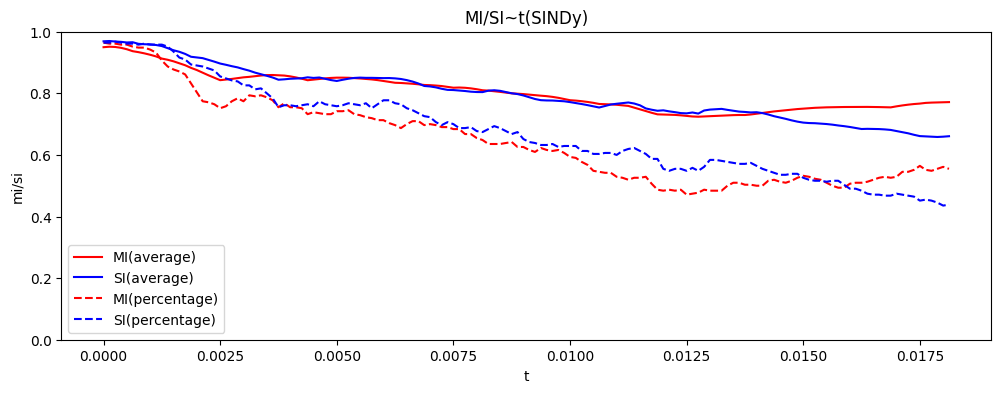

round: 1
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -5.168 1 + 83.042 Vx + -16.618 Vy + 4579.665 t + -17.300 VxVx + 8.833 VyVy + -173711.269 tt + 26.860 VxVy + -8829.760 Vxt + 11861.733 Vyt + 11.044 VxVxVy + 1939.133 VxVxt + 2297.185 VyVyt + -5185.862 VxVyt + -104.540 Vx_2 + -379.556 Vy_2 + 150.588 Vx_1 + 330.269 Vy_1 + -93.941 VxVx_2 + -408.992 VxVy_2 + 20074.940 Vxt_2 + -6.989 VyVx_2 + -10.808 VyVy_2 + -846936.645 Vyt_2 + -51.139 tVx_2 + -659.301 tVy_2 + 14832.922 tt_2 + 7.206 VxVxVx_2 + 3193.783 VxVxVy_2 + -2181.411 VxVxt_2 + 2070.384 VyVyVx_2 + -71.968 VyVyVy_2 + -71.497 VyVyt_2 + 93146.430 ttVx_2 + 33.030 ttVy_2 + 21.229 ttt_2 + -4450938.005 VxVyVx_2 + 72.412 VxVyVy_2 + 15797.120 VxVyt_2 + 2029.351 VxtVx_2 + 7.670 VxtVy_2 + -2791.704 Vxtt_2 + -3090.226 VytVx_2 + -4850.250 VytVy_2 + -73.213 VxVx_1 + 161.567 VxVy_1 + -51117.058 Vxt_1 + 2.205 VyVx_1 + 5.295 VyVy_1 + 2411749.499 Vyt_1 + -5.710 tVx_1 + 9257.116 tVy_1 + -23772.031 tt_1 + -1.402 VxVxVx_1 + -607.312 VxVxVy_1 + -1194.166 VxVxt_

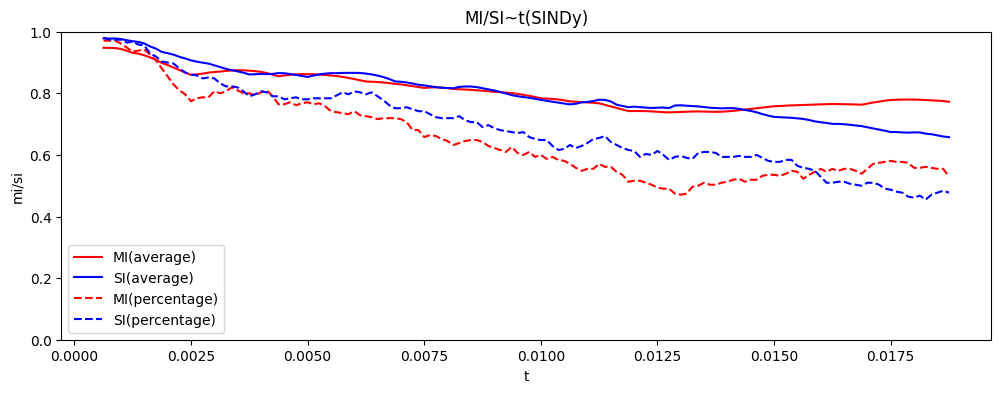

round: 2
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -25.278 1 + 27.801 Vx + -45.127 Vy + 10625.312 t + -9.085 VxVx + -4.898 VyVy + -487415.492 tt + 13.799 VxVy + -4233.496 Vxt + 13837.645 Vyt + 7.878 VxVxVy + 726.342 VxVxt + 3481.997 VyVyt + -3668.840 VxVyt + -147.585 Vx_2 + -298.200 Vy_2 + 240.668 Vx_1 + 383.432 Vy_1 + -120.430 VxVx_2 + -392.178 VxVy_2 + 38101.895 Vxt_2 + 6.101 VyVx_2 + 0.027 VyVy_2 + -1915504.891 Vyt_2 + -29.136 tVx_2 + 1204.192 tVy_2 + 15496.354 tt_2 + -0.760 VxVxVx_2 + 1611.116 VxVxVy_2 + -2524.483 VxVxt_2 + 1380.980 VyVyVx_2 + -47.910 VyVyVy_2 + -138.877 VyVyt_2 + 74540.409 ttVx_2 + 22.673 ttVy_2 + -4.757 ttt_2 + -3487300.794 VxVyVx_2 + 40.606 VxVyVy_2 + 11128.011 VxVyt_2 + 9837.930 VxtVx_2 + 7.346 VxtVy_2 + -2515.383 Vxtt_2 + -145.575 VytVx_2 + -3556.069 VytVy_2 + -92.153 VxVx_1 + 55.736 VxVy_1 + -71872.262 Vxt_1 + 9.055 VyVx_1 + -17.011 VyVy_1 + 3395377.531 Vyt_1 + -19.286 tVx_1 + 8711.673 tVy_1 + -14283.246 tt_1 + -0.947 VxVxVx_1 + -1600.069 VxVxVy_1 + 443.018 VxVxt

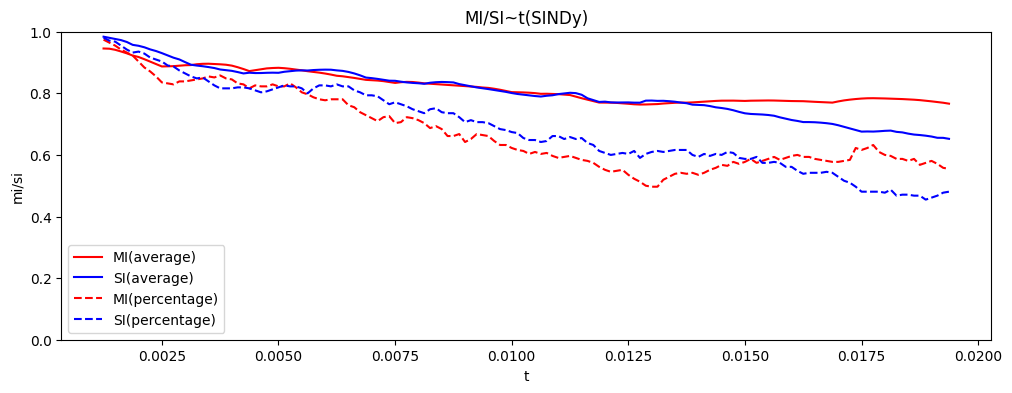

round: 3
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -61.724 1 + 47.562 Vx + -42.058 Vy + 17617.587 t + -13.286 VxVx + -6.915 VyVy + -777429.830 tt + -5.319 VxVy + -5542.601 Vxt + 13280.194 Vyt + 7.304 VxVxVy + 805.729 VxVxt + 3370.227 VyVyt + -2412.110 VxVyt + -111.348 Vx_2 + -238.236 Vy_2 + 90.236 Vx_1 + 311.498 Vy_1 + -111.223 VxVx_2 + -371.351 VxVy_2 + 26904.517 Vxt_2 + 17.359 VyVx_2 + 37.581 VyVy_2 + -1323991.024 Vyt_2 + -15.256 tVx_2 + 1656.540 tVy_2 + 13620.205 tt_2 + -4.168 VxVxVx_2 + 319.161 VxVxVy_2 + -5621.558 VxVxt_2 + -586.844 VyVyVx_2 + 13.650 VyVyVy_2 + -102.860 VyVyt_2 + 63742.369 ttVx_2 + -4.013 ttVy_2 + -13.457 ttt_2 + -3056100.552 VxVyVx_2 + -5.638 VxVyVy_2 + 6515.673 VxVyt_2 + 6841.224 VxtVx_2 + 9.540 VxtVy_2 + 110.200 Vxtt_2 + 571.750 VytVx_2 + 9.510 VytVy_2 + -101.812 VxVx_1 + 111.397 VxVy_1 + -40240.516 Vxt_1 + 21.038 VyVx_1 + -9.630 VyVy_1 + 2033823.629 Vyt_1 + -33.004 tVx_1 + 11004.450 tVy_1 + -19812.954 tt_1 + -6.257 VxVxVx_1 + -3042.213 VxVxVy_1 + 236.954 VxVxt_1 +

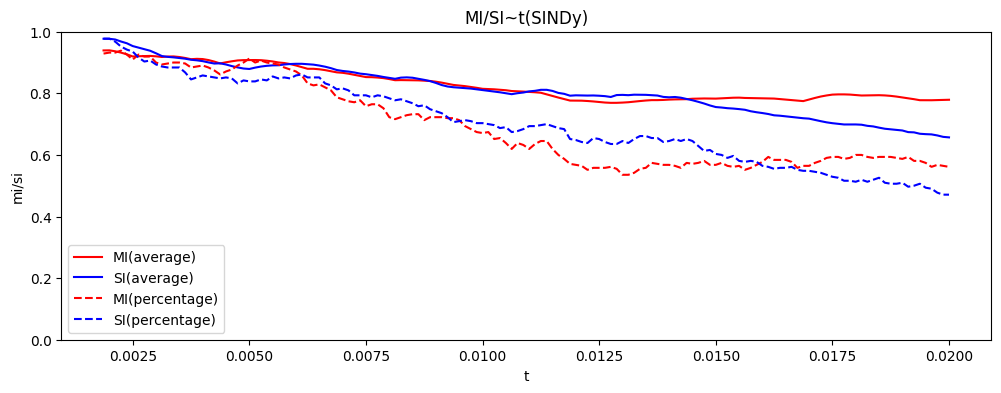

round: 4
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -60.292 1 + 69.700 Vx + -24.824 Vy + 16742.914 t + -20.104 VxVx + -5.549 VyVy + -722630.051 tt + -3.262 VxVy + -6757.242 Vxt + 12174.155 Vyt + 6.378 VxVxVy + 1418.662 VxVxt + 3159.796 VyVyt + -2643.082 VxVyt + -371.943 Vx_2 + -493.605 Vy_2 + 26.378 Vx_1 + 161.337 Vy_1 + -125.598 VxVx_2 + -367.198 VxVy_2 + 82359.497 Vxt_2 + 22.964 VyVx_2 + 27.270 VyVy_2 + -3921156.442 Vyt_2 + -10.418 tVx_2 + 4574.830 tVy_2 + 11648.649 tt_2 + 0.070 VxVxVx_2 + -926.974 VxVxVy_2 + -4382.669 VxVxt_2 + -518.734 VyVyVx_2 + 131.288 VyVyVy_2 + -130.116 VyVyt_2 + 102681.367 ttVx_2 + 7.539 ttVy_2 + -35.331 ttt_2 + -4407372.638 VxVyVx_2 + -23.098 VxVyVy_2 + -3124.079 VxVyt_2 + 10242.026 VxtVx_2 + 16.034 VxtVy_2 + -1171.448 Vxtt_2 + 3365.032 VytVx_2 + 383.279 VytVy_2 + 6.279 VxVx_1 + 140.290 VxVy_1 + -31346.885 Vxt_1 + 7.051 VyVx_1 + -15.599 VyVy_1 + 1827233.965 Vyt_1 + -2.580 tVx_1 + -1682.199 tVy_1 + -23279.887 tt_1 + -2.394 VxVxVx_1 + -200.041 VxVxVy_1 + 1050.752 Vx

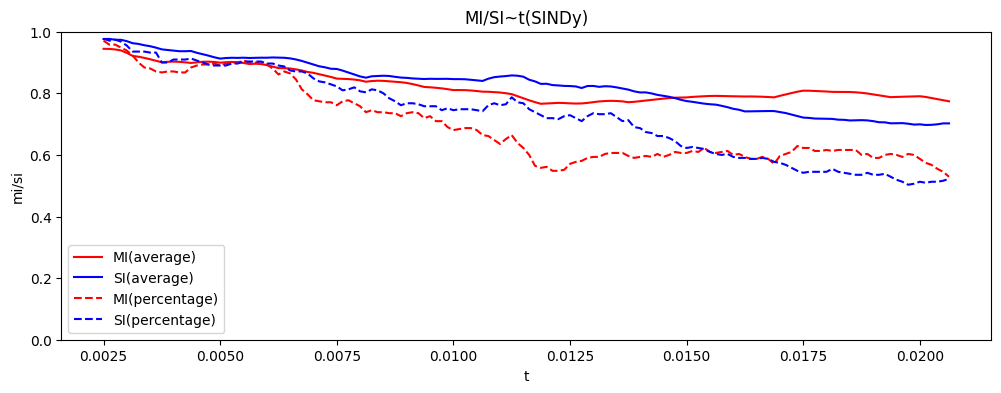

round: 5
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -67.294 1 + 49.116 Vx + 17.303 Vy + 18333.149 t + -16.066 VxVx + 3.178 VyVy + -780292.695 tt + -22.483 VxVy + -4360.288 Vxt + 8908.625 Vyt + 2.981 VxVxVy + 678.330 VxVxt + 2311.410 VyVyt + -831.700 VxVyt + -529.952 Vx_2 + -417.100 Vy_2 + -183.063 Vx_1 + -46.419 Vy_1 + -74.007 VxVx_2 + -414.895 VxVy_2 + 102095.513 Vxt_2 + 19.431 VyVx_2 + 10.042 VyVy_2 + -4388080.304 Vyt_2 + -10.909 tVx_2 + -3380.472 tVy_2 + 18722.280 tt_2 + -2.949 VxVxVx_2 + 691.393 VxVxVy_2 + -2580.620 VxVxt_2 + -2764.486 VyVyVx_2 + 38.339 VyVyVy_2 + -232.355 VyVyt_2 + 85741.369 ttVx_2 + 26.597 ttVy_2 + -58.694 ttt_2 + -3626373.753 VxVyVx_2 + -12.186 VxVyVy_2 + 3138.865 VxVyt_2 + 19196.271 VxtVx_2 + 14.094 VxtVy_2 + -2259.536 Vxtt_2 + 5541.565 VytVx_2 + -930.237 VytVy_2 + -42.304 VxVx_1 + 260.190 VxVy_1 + 14694.492 Vxt_1 + 25.707 VyVx_1 + -30.922 VyVy_1 + -257050.837 Vyt_1 + -55.623 tVx_1 + 3588.292 tVy_1 + -35541.315 tt_1 + -9.389 VxVxVx_1 + -2259.422 VxVxVy_1 + 2798.765 

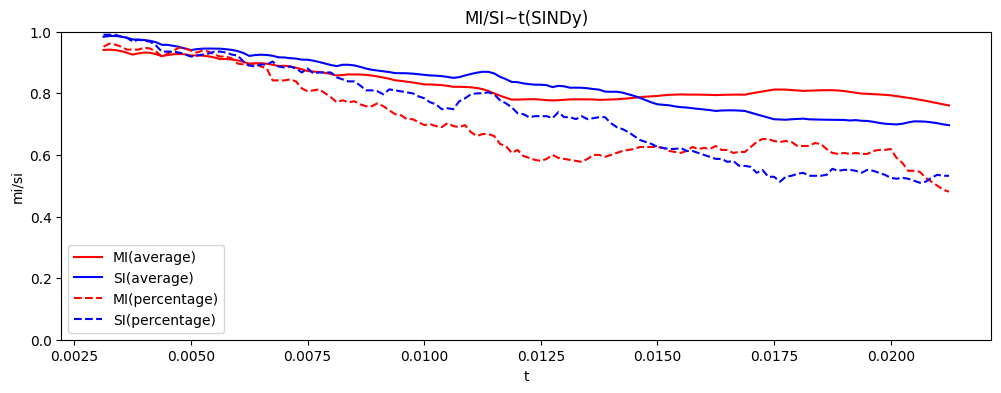

round: 6
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -52.462 1 + 35.576 Vx + 50.271 Vy + 15055.707 t + -22.495 VxVx + 16.862 VyVy + -633207.208 tt + -28.300 VxVy + -3136.098 Vxt + 6039.700 Vyt + 2.448 VxVxVy + 1056.930 VxVxt + 1217.136 VyVyt + -49.637 VxVyt + -663.637 Vx_2 + -430.228 Vy_2 + -77.520 Vx_1 + -147.294 Vy_1 + -136.364 VxVx_2 + -424.257 VxVy_2 + 117237.849 Vxt_2 + 31.758 VyVx_2 + 11.626 VyVy_2 + -4758795.618 Vyt_2 + 14.508 tVx_2 + 728.690 tVy_2 + 18213.635 tt_2 + -1.999 VxVxVx_2 + -38.556 VxVxVy_2 + -2858.989 VxVxt_2 + -4325.435 VyVyVx_2 + 115.605 VyVyVy_2 + -301.408 VyVyt_2 + 77405.971 ttVx_2 + 7.585 ttVy_2 + -62.005 ttt_2 + -2988487.287 VxVyVx_2 + -23.322 VxVyVy_2 + -5106.667 VxVyt_2 + 24360.069 VxtVx_2 + 23.587 VxtVy_2 + -537.347 Vxtt_2 + 6602.353 VytVx_2 + -1205.883 VytVy_2 + -17.708 VxVx_1 + 230.766 VxVy_1 + -9655.711 Vxt_1 + 18.006 VyVx_1 + 14.119 VyVy_1 + 830644.430 Vyt_1 + -24.636 tVx_1 + 1450.723 tVy_1 + -31538.680 tt_1 + -2.328 VxVxVx_1 + -1702.826 VxVxVy_1 + -1610.901 V

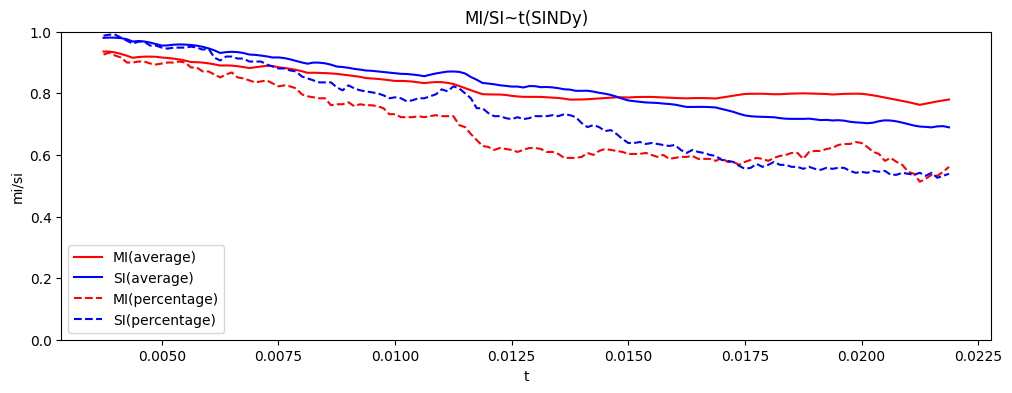

round: 7
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -33.158 1 + 67.803 Vx + 99.721 Vy + 10813.672 t + -25.511 VxVx + 28.371 VyVy + -455388.846 tt + -35.051 VxVy + -4710.888 Vxt + 2127.526 Vyt + 1.700 VxVxVy + 1072.275 VxVxt + 384.304 VyVyt + 897.929 VxVyt + -527.764 Vx_2 + -281.981 Vy_2 + -300.891 Vx_1 + -402.814 Vy_1 + -172.492 VxVx_2 + -506.407 VxVy_2 + 91186.571 Vxt_2 + 65.217 VyVx_2 + -47.011 VyVy_2 + -3664293.361 Vyt_2 + 34.681 tVx_2 + 4088.391 tVy_2 + 25988.969 tt_2 + -5.592 VxVxVx_2 + -2860.882 VxVxVy_2 + 2005.134 VxVxt_2 + -6514.401 VyVyVx_2 + 218.899 VyVyVy_2 + -351.439 VyVyt_2 + 49610.155 ttVx_2 + -27.802 ttVy_2 + -64.032 ttt_2 + -1822011.798 VxVyVx_2 + 14.805 VxVyVy_2 + -14860.688 VxVyt_2 + 27795.641 VxtVx_2 + 24.960 VxtVy_2 + 3494.581 Vxtt_2 + 6611.522 VytVx_2 + -4594.182 VytVy_2 + 37.551 VxVx_1 + 146.826 VxVy_1 + 23433.178 Vxt_1 + 15.927 VyVx_1 + 6.301 VyVy_1 + -335868.359 Vyt_1 + -13.601 tVx_1 + -1919.237 tVy_1 + -23659.775 tt_1 + -4.972 VxVxVx_1 + -1257.920 VxVxVy_1 + -1038.7

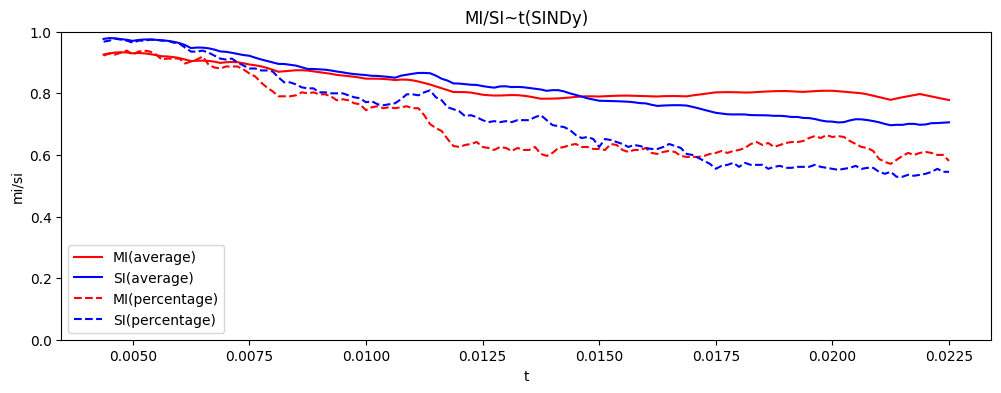

round: 8
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -88.926 1 + 56.656 Vx + 135.149 Vy + 19305.225 t + -15.831 VxVx + 39.812 VyVy + -753310.934 tt + -30.770 VxVy + -3749.665 Vxt + -761.014 Vyt + 2.682 VxVxVy + 468.690 VxVxt + -712.413 VyVyt + 562.676 VxVyt + -276.784 Vx_2 + -95.163 Vy_2 + -447.411 Vx_1 + -390.171 Vy_1 + -143.827 VxVx_2 + -519.971 VxVy_2 + 55980.941 Vxt_2 + 79.094 VyVx_2 + -90.943 VyVy_2 + -2518768.401 Vyt_2 + 90.559 tVx_2 + 688.114 tVy_2 + 27551.792 tt_2 + -5.426 VxVxVx_2 + -2992.296 VxVxVy_2 + 5312.774 VxVxt_2 + -10681.069 VyVyVx_2 + 162.007 VyVyVy_2 + -350.222 VyVyt_2 + 21752.504 ttVx_2 + 17.077 ttVy_2 + -75.112 ttt_2 + -901377.195 VxVyVx_2 + 55.736 VxVyVy_2 + -9635.407 VxVyt_2 + 27811.025 VxtVx_2 + 25.781 VxtVy_2 + 193.306 Vxtt_2 + 7669.269 VytVx_2 + -7151.768 VytVy_2 + 99.504 VxVx_1 + 231.207 VxVy_1 + 41316.778 Vxt_1 + 41.512 VyVx_1 + 48.671 VyVy_1 + -787126.746 Vyt_1 + 17.155 tVx_1 + -7626.183 tVy_1 + -27546.545 tt_1 + -6.039 VxVxVx_1 + -2363.845 VxVxVy_1 + -3632.024 V

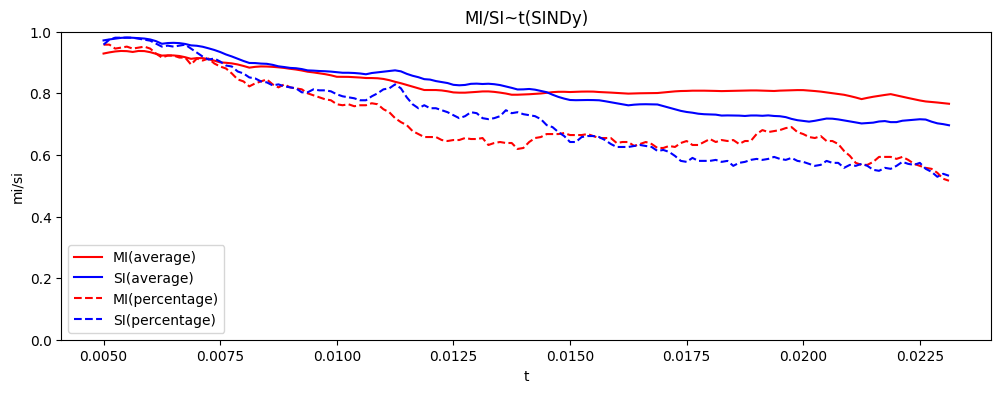

round: 9
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -146.631 1 + 103.795 Vx + 160.822 Vy + 26123.923 t + -27.183 VxVx + 43.227 VyVy + -934285.024 tt + -24.203 VxVy + -7151.200 Vxt + -2205.979 Vyt + 2.677 VxVxVy + 1325.221 VxVxt + -1085.937 VyVyt + -157.003 VxVyt + -330.222 Vx_2 + -135.944 Vy_2 + -708.432 Vx_1 + -376.282 Vy_1 + -215.486 VxVx_2 + -469.789 VxVy_2 + 60073.183 Vxt_2 + 121.873 VyVx_2 + -105.370 VyVy_2 + -2580580.986 Vyt_2 + 60.152 tVx_2 + 5656.225 tVy_2 + 22128.343 tt_2 + -9.419 VxVxVx_2 + -6060.575 VxVxVy_2 + 6325.003 VxVxt_2 + -7390.203 VyVyVx_2 + 224.181 VyVyVy_2 + -428.673 VyVyt_2 + 28969.134 ttVx_2 + 2.862 ttVy_2 + -98.096 ttt_2 + -1171540.184 VxVyVx_2 + 81.927 VxVyVy_2 + -15259.216 VxVyt_2 + 34400.207 VxtVx_2 + 33.257 VxtVy_2 + 1557.812 Vxtt_2 + 9711.092 VytVx_2 + -10788.386 VytVy_2 + 140.135 VxVx_1 + 88.133 VxVy_1 + 80437.700 Vxt_1 + 48.951 VyVx_1 + 32.110 VyVy_1 + -2129171.935 Vyt_1 + 57.271 tVx_1 + -11499.970 tVy_1 + -15381.741 tt_1 + -8.056 VxVxVx_1 + -2545.404 VxVxVy_1

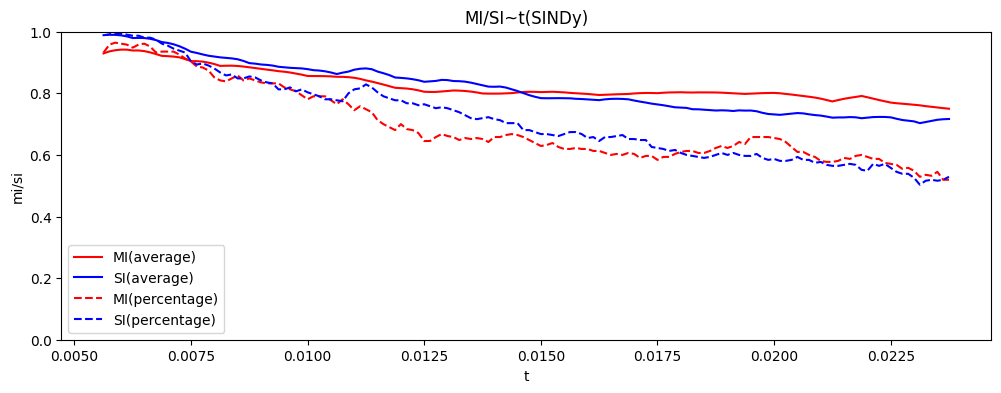

round: 10
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -102.833 1 + 80.362 Vx + 199.023 Vy + 19949.541 t + -5.855 VxVx + 41.817 VyVy + -745980.020 tt + -31.246 VxVy + -5572.531 Vxt + -5040.142 Vyt + 2.834 VxVxVy + 141.093 VxVxt + -1014.686 VyVyt + 625.934 VxVyt + -325.100 Vx_2 + -245.134 Vy_2 + -554.815 Vx_1 + -481.790 Vy_1 + -47.183 VxVx_2 + -509.196 VxVy_2 + 58724.645 Vxt_2 + 79.680 VyVx_2 + -120.899 VyVy_2 + -2558140.538 Vyt_2 + 106.797 tVx_2 + -4280.626 tVy_2 + 24582.217 tt_2 + -0.291 VxVxVx_2 + -3428.212 VxVxVy_2 + 7602.726 VxVxt_2 + -11396.880 VyVyVx_2 + 332.551 VyVyVy_2 + -314.690 VyVyt_2 + 48562.828 ttVx_2 + -21.879 ttVy_2 + -83.925 ttt_2 + -1896423.305 VxVyVx_2 + 126.263 VxVyVy_2 + -21105.722 VxVyt_2 + 25727.607 VxtVx_2 + 21.730 VxtVy_2 + 2782.061 Vxtt_2 + 8322.112 VytVx_2 + -12264.144 VytVy_2 + 56.738 VxVx_1 + 71.593 VxVy_1 + 54595.321 Vxt_1 + 95.225 VyVx_1 + 18.710 VyVy_1 + -1212474.115 Vyt_1 + 21.664 tVx_1 + -4121.725 tVy_1 + -14687.872 tt_1 + -4.356 VxVxVx_1 + -6328.109 VxVxVy_1 

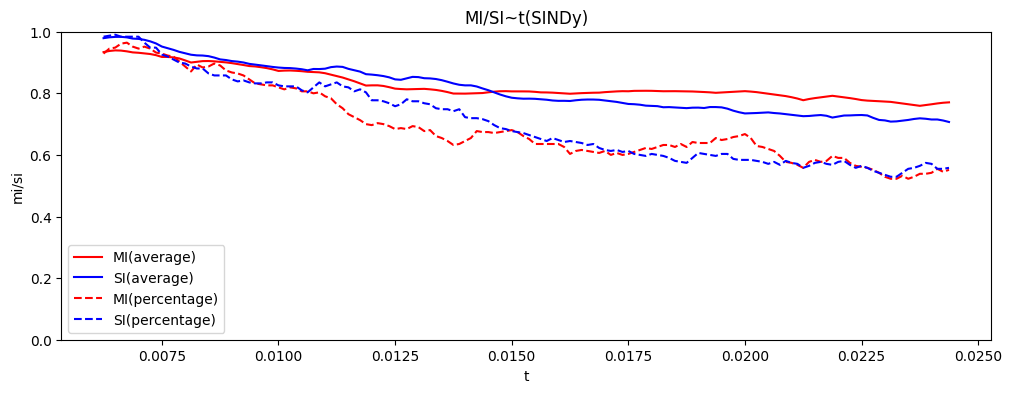

round: 11
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -79.660 1 + 79.582 Vx + 219.879 Vy + 16596.887 t + -3.618 VxVx + 45.066 VyVy + -639269.046 tt + -11.502 VxVy + -5126.500 Vxt + -6882.365 Vyt + 0.985 VxVxVy + -1.874 VxVxt + -1436.132 VyVyt + -298.028 VxVyt + 68.691 Vx_2 + 79.028 Vy_2 + -295.708 Vx_1 + -402.040 Vy_1 + -82.171 VxVx_2 + -390.973 VxVy_2 + 6243.152 Vxt_2 + 110.518 VyVx_2 + -145.782 VyVy_2 + -1010951.803 Vyt_2 + 111.898 tVx_2 + 482.653 tVy_2 + 13749.927 tt_2 + -2.755 VxVxVx_2 + -5455.795 VxVxVy_2 + 7836.342 VxVxt_2 + -10079.539 VyVyVx_2 + 372.474 VyVyVy_2 + -211.039 VyVyt_2 + 4450.632 ttVx_2 + -23.932 ttVy_2 + -63.224 ttt_2 + -491509.145 VxVyVx_2 + 164.787 VxVyVy_2 + -22627.540 VxVyt_2 + 16729.792 VxtVx_2 + 18.910 VxtVy_2 + 2870.625 Vxtt_2 + 6144.715 VytVx_2 + -13727.645 VytVy_2 + 86.467 VxVx_1 + -32.563 VxVy_1 + 18416.185 Vxt_1 + 89.202 VyVx_1 + -24.000 VyVy_1 + -7686.353 Vyt_1 + 35.884 tVx_1 + -6581.534 tVy_1 + -6652.169 tt_1 + -6.014 VxVxVx_1 + -5644.363 VxVxVy_1 + 2777.448 

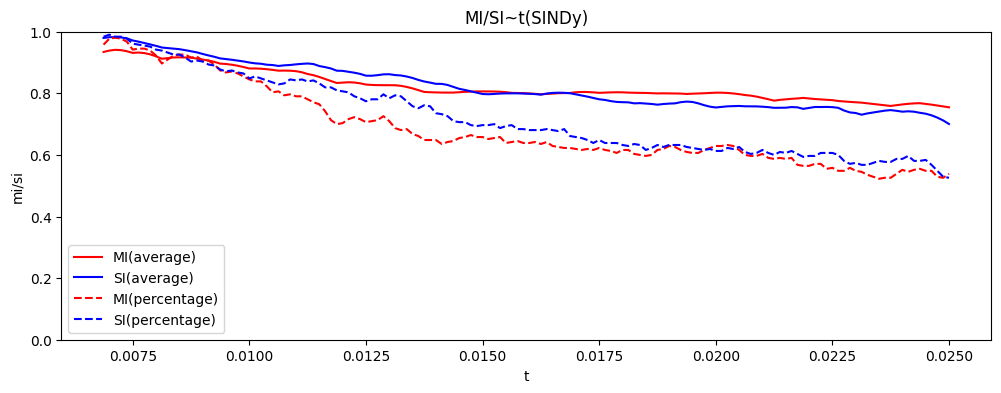

round: 12
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 28.410 1 + 89.098 Vx + 254.738 Vy + 3615.639 t + -9.031 VxVx + 67.125 VyVy + -275583.979 tt + -23.194 VxVy + -5156.274 Vxt + -9619.007 Vyt + 2.092 VxVxVy + 175.135 VxVxt + -3035.921 VyVyt + 501.893 VxVyt + 222.214 Vx_2 + 464.906 Vy_2 + -385.367 Vx_1 + -738.606 Vy_1 + 19.230 VxVx_2 + -487.972 VxVy_2 + -14065.500 Vxt_2 + 105.853 VyVx_2 + -154.556 VyVy_2 + -376328.024 Vyt_2 + 116.069 tVx_2 + -5379.311 tVy_2 + 19716.728 tt_2 + -6.890 VxVxVx_2 + -5308.911 VxVxVy_2 + 8903.463 VxVxt_2 + -9393.973 VyVyVx_2 + 452.911 VyVyVy_2 + -203.127 VyVyt_2 + -50652.899 ttVx_2 + 1.842 ttVy_2 + -47.970 ttt_2 + 1300973.591 VxVyVx_2 + 161.270 VxVyVy_2 + -24916.336 VxVyt_2 + 16125.149 VxtVx_2 + 18.075 VxtVy_2 + 123.811 Vxtt_2 + 5028.460 VytVx_2 + -12968.525 VytVy_2 + 41.121 VxVx_1 + -51.805 VxVy_1 + 36355.626 Vxt_1 + 104.900 VyVx_1 + -2.654 VyVy_1 + -727005.209 Vyt_1 + -0.702 tVx_1 + -4666.116 tVy_1 + -4422.725 tt_1 + -3.410 VxVxVx_1 + -5948.809 VxVxVy_1 + 357.823

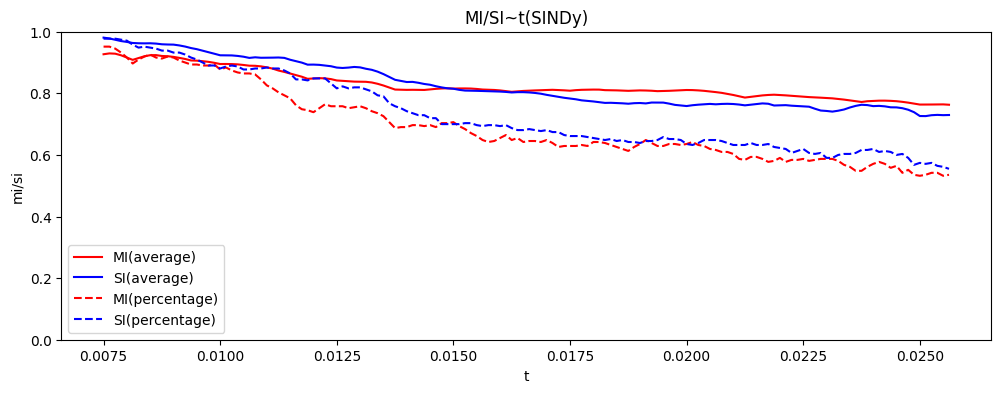

round: 13
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -56.304 1 + 71.284 Vx + 265.122 Vy + 14179.657 t + -0.316 VxVx + 70.788 VyVy + -580618.792 tt + -27.894 VxVy + -4070.121 Vxt + -10149.881 Vyt + 0.168 VxVxVy + -436.320 VxVxt + -3153.693 VyVyt + 1145.585 VxVyt + 148.316 Vx_2 + 433.817 Vy_2 + -374.141 Vx_1 + -881.876 Vy_1 + 127.373 VxVx_2 + -525.123 VxVy_2 + -12697.201 Vxt_2 + 68.080 VyVx_2 + -114.391 VyVy_2 + -220929.473 Vyt_2 + 197.030 tVx_2 + -12191.954 tVy_2 + 23953.286 tt_2 + 1.693 VxVxVx_2 + -2817.611 VxVxVy_2 + 6735.222 VxVxt_2 + -16142.040 VyVyVx_2 + 454.743 VyVyVy_2 + -95.909 VyVyt_2 + -43160.717 ttVx_2 + -33.304 ttVy_2 + -19.819 ttt_2 + 973468.073 VxVyVx_2 + 138.807 VxVyVy_2 + -25410.808 VxVyt_2 + 9161.491 VxtVx_2 + 9.155 VxtVy_2 + 2365.666 Vxtt_2 + 3377.012 VytVx_2 + -10070.167 VytVy_2 + 47.687 VxVx_1 + -76.965 VxVy_1 + 33718.366 Vxt_1 + 97.996 VyVx_1 + -26.338 VyVy_1 + -604978.236 Vyt_1 + -12.409 tVx_1 + -5392.604 tVy_1 + -1529.730 tt_1 + -4.547 VxVxVx_1 + -5405.346 VxVxVy_1 + 1

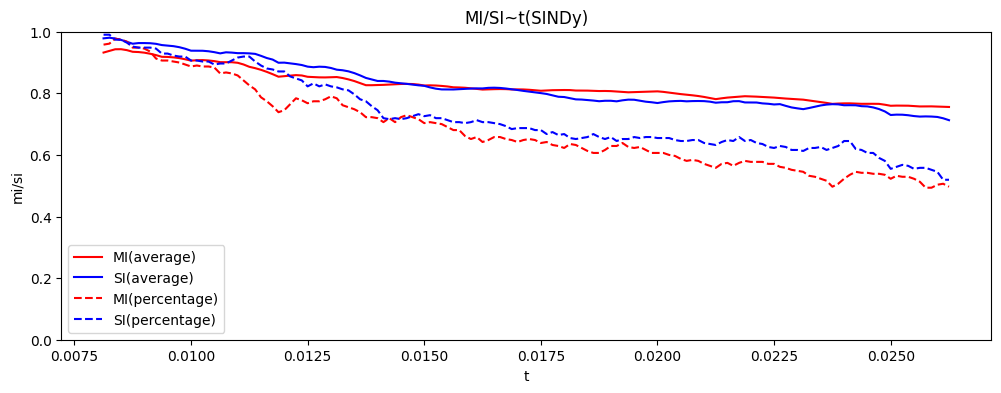

round: 14
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 16.370 1 + 19.765 Vx + 265.159 Vy + 4655.577 t + 19.432 VxVx + 66.240 VyVy + -288377.739 tt + -39.771 VxVy + -1187.549 Vxt + -9853.365 Vyt + -0.459 VxVxVy + -1487.990 VxVxt + -2815.488 VyVyt + 2000.317 VxVyt + 606.001 Vx_2 + 604.229 Vy_2 + -447.773 Vx_1 + -1102.322 Vy_1 + 52.529 VxVx_2 + -428.817 VxVy_2 + -66554.835 Vxt_2 + 100.866 VyVx_2 + -103.448 VyVy_2 + 1278198.433 Vyt_2 + 115.528 tVx_2 + -8071.641 tVy_2 + 15349.255 tt_2 + 6.510 VxVxVx_2 + -4329.379 VxVxVy_2 + 4935.690 VxVxt_2 + -10408.285 VyVyVx_2 + 395.624 VyVyVy_2 + 7.732 VyVyt_2 + -66470.843 ttVx_2 + -15.390 ttVy_2 + 1.351 ttt_2 + 1718586.296 VxVyVx_2 + 117.723 VxVyVy_2 + -18249.062 VxVyt_2 + 1539.428 VxtVx_2 + 0.085 VxtVy_2 + 309.911 Vxtt_2 + 1232.364 VytVx_2 + -6778.597 VytVy_2 + -131.787 VxVx_1 + -57.145 VxVy_1 + 46163.818 Vxt_1 + 167.137 VyVx_1 + 6.711 VyVy_1 + -1043497.774 Vyt_1 + -32.986 tVx_1 + 1952.377 tVy_1 + -4684.938 tt_1 + 12.541 VxVxVx_1 + -8024.061 VxVxVy_1 + -1095.

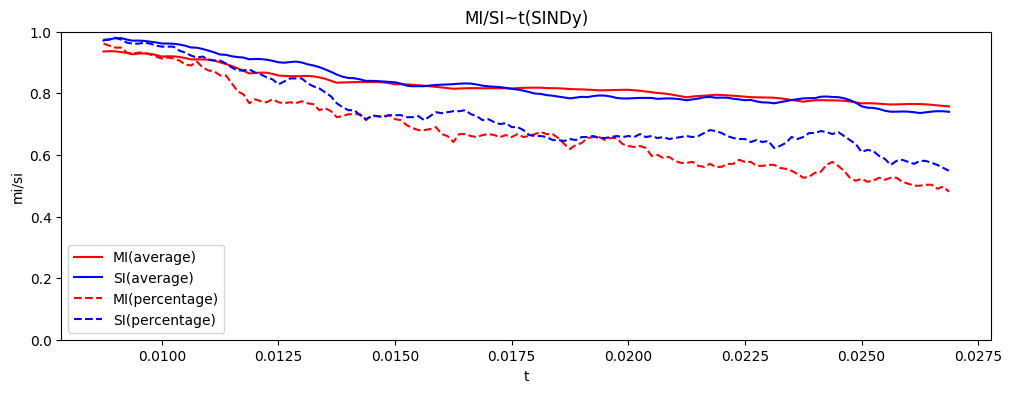

round: 15
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 91.158 1 + 16.104 Vx + 324.838 Vy + -3854.959 t + 27.501 VxVx + 94.024 VyVy + -63484.319 tt + -41.301 VxVy + -1095.162 Vxt + -13969.073 Vyt + 1.809 VxVxVy + -1795.551 VxVxt + -4538.017 VyVyt + 1991.133 VxVyt + 585.588 Vx_2 + 585.419 Vy_2 + -669.189 Vx_1 + -1122.290 Vy_1 + 315.016 VxVx_2 + -499.862 VxVy_2 + -61619.214 Vxt_2 + 26.269 VyVx_2 + -176.083 VyVy_2 + 1063216.414 Vyt_2 + 113.967 tVx_2 + -16859.863 tVy_2 + 19443.093 tt_2 + -12.114 VxVxVx_2 + -2430.794 VxVxVy_2 + 9150.384 VxVxt_2 + -8134.889 VyVyVx_2 + 436.390 VyVyVy_2 + 53.442 VyVyt_2 + -58142.169 ttVx_2 + -25.417 ttVy_2 + 1.494 ttt_2 + 1383808.210 VxVyVx_2 + 164.721 VxVyVy_2 + -20658.266 VxVyt_2 + -1161.627 VxtVx_2 + -12.174 VxtVy_2 + 515.012 Vxtt_2 + 873.767 VytVx_2 + -9077.456 VytVy_2 + -0.401 VxVx_1 + -389.073 VxVy_1 + 72282.631 Vxt_1 + 91.859 VyVx_1 + -121.500 VyVy_1 + -1744832.647 Vyt_1 + 48.055 tVx_1 + -3990.234 tVy_1 + 14913.491 tt_1 + 8.784 VxVxVx_1 + -4608.421 VxVxVy_1 + 6

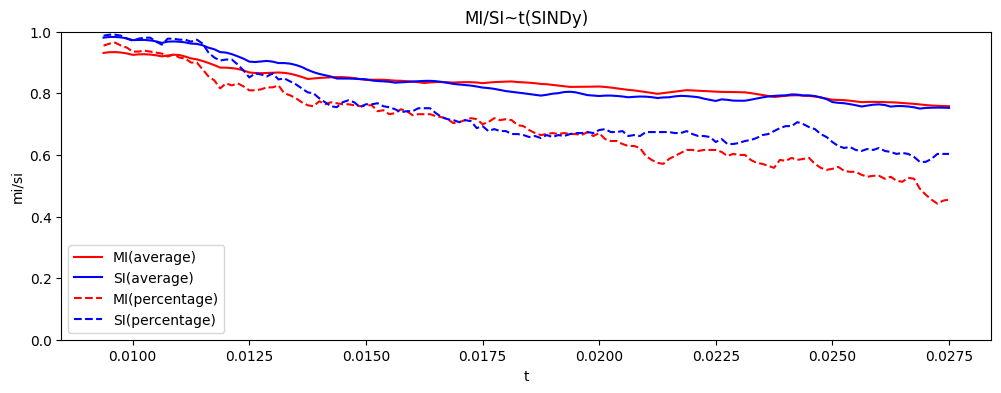

round: 16
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 138.902 1 + -20.161 Vx + 335.475 Vy + -8598.051 t + 36.540 VxVx + 111.659 VyVy + 51100.519 tt + -65.331 VxVy + 499.523 Vxt + -14690.283 Vyt + 4.716 VxVxVy + -2248.077 VxVxt + -5496.636 VyVyt + 3269.785 VxVyt + 147.729 Vx_2 + 1490.972 Vy_2 + -771.500 Vx_1 + -1469.485 Vy_1 + 519.205 VxVx_2 + -543.975 VxVy_2 + -12148.319 Vxt_2 + -54.504 VyVx_2 + -193.183 VyVy_2 + -267681.259 Vyt_2 + 98.111 tVx_2 + -25234.828 tVy_2 + 23217.481 tt_2 + -24.549 VxVxVx_2 + 1038.630 VxVxVy_2 + 9455.332 VxVxt_2 + -6096.298 VyVyVx_2 + 433.975 VyVyVy_2 + 91.386 VyVyt_2 + -156832.702 ttVx_2 + 7.422 ttVy_2 + 33.701 ttt_2 + 3936639.991 VxVyVx_2 + 99.006 VxVyVy_2 + -20750.535 VxVyt_2 + -5630.590 VxtVx_2 + -10.387 VxtVy_2 + -1425.421 Vxtt_2 + -1817.556 VytVx_2 + -4294.415 VytVy_2 + 173.036 VxVx_1 + -618.870 VxVy_1 + 75825.861 Vxt_1 + 67.779 VyVx_1 + -116.152 VyVy_1 + -1655476.118 Vyt_1 + 231.252 tVx_1 + -9683.996 tVy_1 + 23149.740 tt_1 + -7.040 VxVxVx_1 + -4703.400 VxVxVy

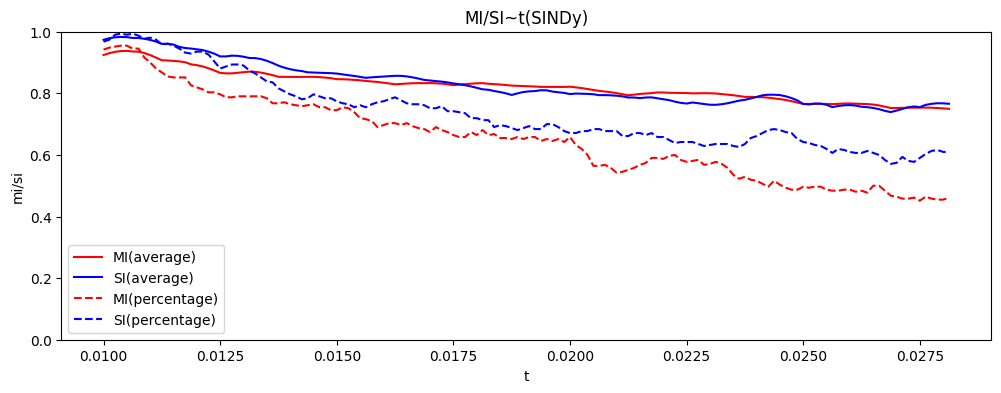

round: 17
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 169.480 1 + 45.734 Vx + 320.278 Vy + -13196.793 t + 25.550 VxVx + 103.946 VyVy + 196322.344 tt + -36.595 VxVy + -2607.062 Vxt + -12699.467 Vyt + 2.630 VxVxVy + -1697.209 VxVxt + -4807.138 VyVyt + 1584.026 VxVyt + 637.390 Vx_2 + 1520.552 Vy_2 + -656.455 Vx_1 + -1426.824 Vy_1 + 345.650 VxVx_2 + -396.730 VxVy_2 + -60726.447 Vxt_2 + -16.645 VyVx_2 + -182.893 VyVy_2 + 890455.494 Vyt_2 + 23.864 tVx_2 + -17356.320 tVy_2 + 14024.673 tt_2 + -20.694 VxVxVx_2 + -406.908 VxVxVy_2 + 9665.320 VxVxt_2 + -1433.178 VyVyVx_2 + 505.457 VyVyVy_2 + -66.141 VyVyt_2 + -168208.030 ttVx_2 + -17.027 ttVy_2 + 17.210 ttt_2 + 4374605.315 VxVyVx_2 + 108.022 VxVyVy_2 + -21906.693 VxVyt_2 + 2593.734 VxtVx_2 + -3.516 VxtVy_2 + -891.289 Vxtt_2 + -585.909 VytVx_2 + -5447.133 VytVy_2 + 38.558 VxVx_1 + -488.761 VxVy_1 + 67631.971 Vxt_1 + 58.027 VyVx_1 + -146.412 VyVy_1 + -1544235.713 Vyt_1 + 113.042 tVx_1 + -4105.345 tVy_1 + 18130.571 tt_1 + -5.623 VxVxVx_1 + -3443.602 VxVxV

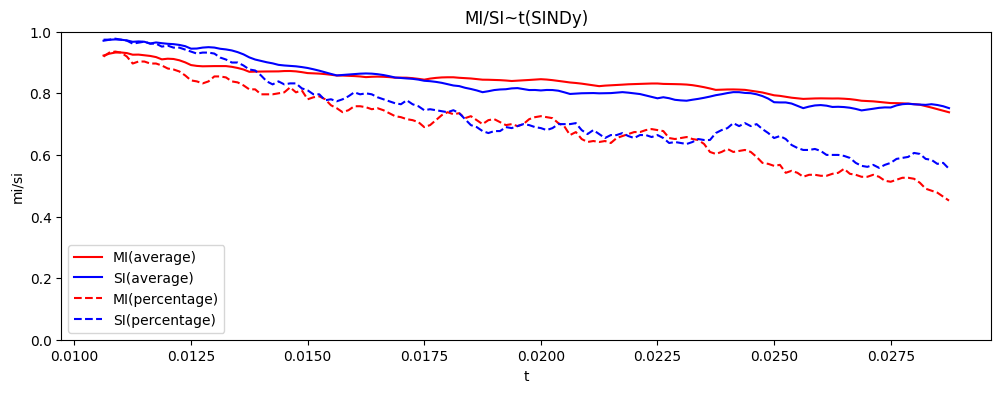

round: 18
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 249.141 1 + 1.484 Vx + 266.840 Vy + -21422.785 t + 2.783 VxVx + 95.040 VyVy + 399377.127 tt + -52.290 VxVy + -509.371 Vxt + -10049.843 Vyt + 2.608 VxVxVy + -509.771 VxVxt + -4294.815 VyVyt + 2457.376 VxVyt + 936.641 Vx_2 + 847.711 Vy_2 + -457.256 Vx_1 + -1920.851 Vy_1 + 94.857 VxVx_2 + -229.659 VxVy_2 + -89000.791 Vxt_2 + 71.198 VyVx_2 + -152.040 VyVy_2 + 1582157.410 Vyt_2 + -55.267 tVx_2 + -7642.242 tVy_2 + 6729.139 tt_2 + -10.643 VxVxVx_2 + -4101.249 VxVxVy_2 + 7466.093 VxVxt_2 + 218.869 VyVyVx_2 + 643.394 VyVyVy_2 + 63.223 VyVyt_2 + -95088.741 ttVx_2 + -120.902 ttVy_2 + 51.152 ttt_2 + 2461484.989 VxVyVx_2 + 128.902 VxVyVy_2 + -27232.521 VxVyt_2 + -3751.898 VxtVx_2 + -18.772 VxtVy_2 + 3906.998 Vxtt_2 + -2207.751 VytVx_2 + -4254.373 VytVy_2 + 91.593 VxVx_1 + -438.696 VxVy_1 + 45031.904 Vxt_1 + 10.283 VyVx_1 + 15.144 VyVy_1 + -937799.625 Vyt_1 + 358.627 tVx_1 + -6505.095 tVy_1 + 15434.303 tt_1 + -7.461 VxVxVx_1 + -1256.395 VxVxVy_1 + -184

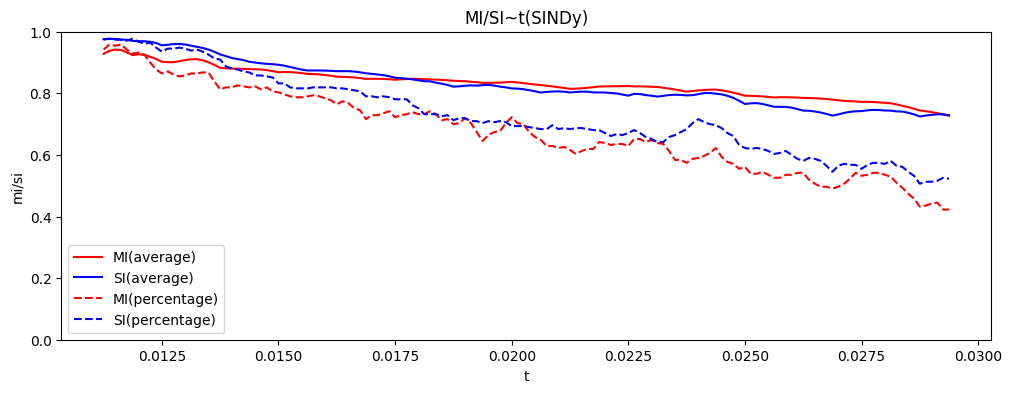

round: 19
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 259.150 1 + 18.616 Vx + 202.012 Vy + -22464.480 t + 3.611 VxVx + 76.219 VyVy + 422905.092 tt + -46.350 VxVy + -1108.505 Vxt + -7119.831 Vyt + 1.560 VxVxVy + -643.302 VxVxt + -3375.511 VyVyt + 2426.909 VxVyt + 709.303 Vx_2 + 1058.145 Vy_2 + -263.978 Vx_1 + -852.619 Vy_1 + 155.278 VxVx_2 + -140.768 VxVy_2 + -65491.743 Vxt_2 + 68.109 VyVx_2 + -196.621 VyVy_2 + 998713.849 Vyt_2 + -153.106 tVx_2 + -10027.524 tVy_2 + 3136.196 tt_2 + -15.266 VxVxVx_2 + -4131.602 VxVxVy_2 + 9393.416 VxVxt_2 + 5170.362 VyVyVx_2 + 511.157 VyVyVy_2 + -158.216 VyVyt_2 + -122722.681 ttVx_2 + -10.619 ttVy_2 + -2.348 ttt_2 + 3257032.023 VxVyVx_2 + 98.706 VxVyVy_2 + -22011.376 VxVyt_2 + 5915.101 VxtVx_2 + -12.830 VxtVy_2 + -493.670 Vxtt_2 + 48.398 VytVx_2 + -2583.374 VytVy_2 + -17.344 VxVx_1 + -342.992 VxVy_1 + 30309.545 Vxt_1 + -0.042 VyVx_1 + 150.014 VyVy_1 + -683491.165 Vyt_1 + 327.068 tVx_1 + -1846.042 tVy_1 + 9503.290 tt_1 + 2.381 VxVxVx_1 + -597.703 VxVxVy_1 + -834

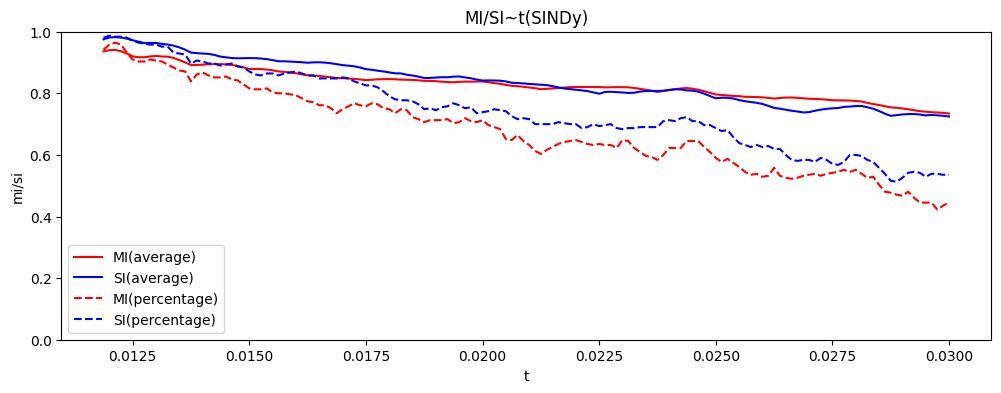

round: 20
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 294.972 1 + 23.036 Vx + 216.131 Vy + -25811.026 t + -0.736 VxVx + 90.905 VyVy + 499575.853 tt + -36.061 VxVy + -1298.031 Vxt + -7704.975 Vyt + 0.432 VxVxVy + -446.922 VxVxt + -4097.335 VyVyt + 1903.025 VxVyt + 903.863 Vx_2 + 616.955 Vy_2 + 68.109 Vx_1 + -828.035 Vy_1 + 86.157 VxVx_2 + -108.633 VxVy_2 + -83366.562 Vxt_2 + 44.411 VyVx_2 + -191.076 VyVy_2 + 1412465.566 Vyt_2 + -20.016 tVx_2 + -7172.910 tVy_2 + 1924.126 tt_2 + -18.259 VxVxVx_2 + -2777.326 VxVxVy_2 + 8971.067 VxVxt_2 + -1812.003 VyVyVx_2 + 394.008 VyVyVy_2 + 92.536 VyVyt_2 + -74317.814 ttVx_2 + -24.307 ttVy_2 + 63.795 ttt_2 + 2013086.880 VxVyVx_2 + 4.547 VxVyVy_2 + -16270.226 VxVyt_2 + -5661.041 VxtVx_2 + -8.611 VxtVy_2 + 119.121 Vxtt_2 + -3071.958 VytVx_2 + 2022.307 VytVy_2 + -54.420 VxVx_1 + -118.643 VxVy_1 + 527.809 Vxt_1 + -35.356 VyVx_1 + 172.552 VyVy_1 + -38136.453 Vyt_1 + 251.453 tVx_1 + -204.501 tVy_1 + 732.409 tt_1 + 6.246 VxVxVx_1 + 1149.413 VxVxVy_1 + -9223.835 VxVx

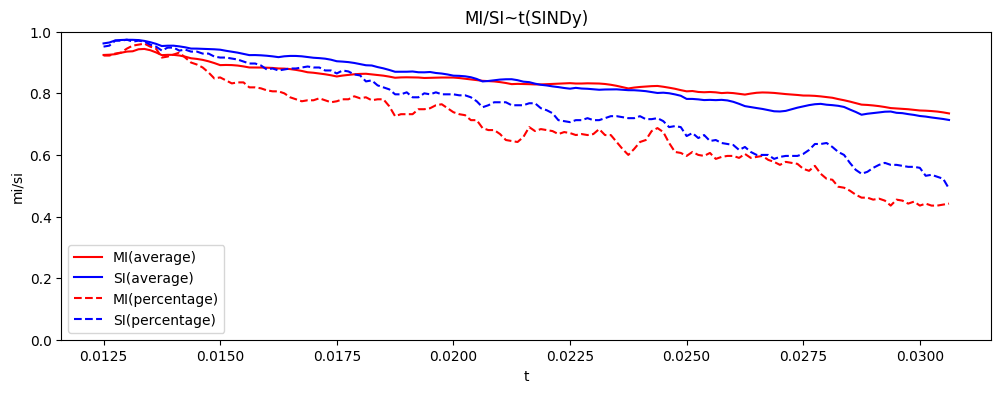

round: 21
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 204.510 1 + 26.944 Vx + 197.488 Vy + -16677.197 t + 3.407 VxVx + 66.312 VyVy + 282696.275 tt + -25.435 VxVy + -1508.987 Vxt + -6586.938 Vyt + -2.377 VxVxVy + -607.923 VxVxt + -2990.535 VyVyt + 1379.759 VxVyt + 879.265 Vx_2 + 394.409 Vy_2 + -154.390 Vx_1 + -838.042 Vy_1 + 60.555 VxVx_2 + 220.230 VxVy_2 + -74318.251 Vxt_2 + 25.679 VyVx_2 + -159.933 VyVy_2 + 1090955.952 Vyt_2 + -146.341 tVx_2 + -6856.191 tVy_2 + -10202.559 tt_2 + -14.982 VxVxVx_2 + -1825.181 VxVxVy_2 + 8687.880 VxVxt_2 + 2288.088 VyVyVx_2 + 261.820 VyVyVy_2 + -69.450 VyVyt_2 + -53679.902 ttVx_2 + 66.230 ttVy_2 + 35.577 ttt_2 + 1536919.620 VxVyVx_2 + 124.879 VxVyVy_2 + -12343.929 VxVyt_2 + 1975.879 VxtVx_2 + -13.208 VxtVy_2 + -3332.269 Vxtt_2 + -1535.684 VytVx_2 + -4498.803 VytVy_2 + -64.577 VxVx_1 + -177.491 VxVy_1 + 21344.835 Vxt_1 + 14.338 VyVx_1 + 98.528 VyVy_1 + -503491.741 Vyt_1 + 246.253 tVx_1 + 288.262 tVy_1 + 4500.673 tt_1 + -1.665 VxVxVx_1 + -1177.765 VxVxVy_1 + -53

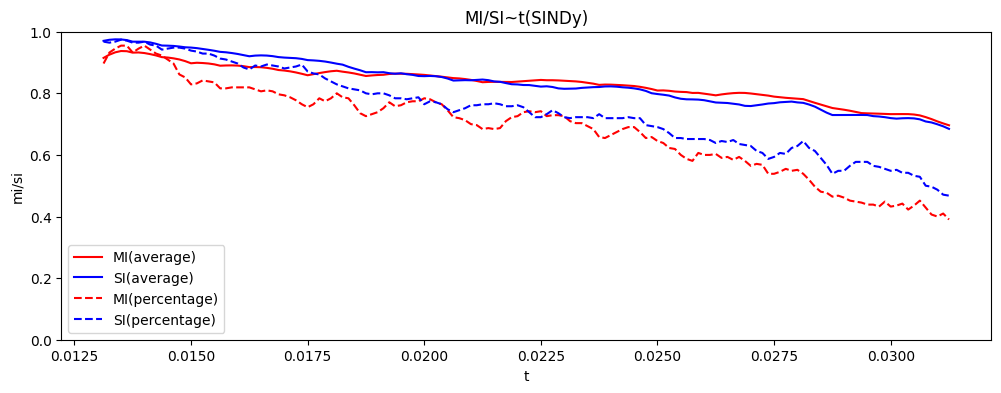

round: 22
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 234.775 1 + -47.170 Vx + 240.484 Vy + -20469.730 t + 14.069 VxVx + 92.926 VyVy + 387667.156 tt + -71.738 VxVy + 1636.444 Vxt + -8462.666 Vyt + 3.485 VxVxVy + -1062.672 VxVxt + -4021.898 VyVyt + 3437.916 VxVyt + 856.948 Vx_2 + 514.561 Vy_2 + -234.120 Vx_1 + -74.256 Vy_1 + -12.531 VxVx_2 + -47.553 VxVy_2 + -79341.573 Vxt_2 + 41.382 VyVx_2 + -166.127 VyVy_2 + 1342008.129 Vyt_2 + -69.234 tVx_2 + -3538.775 tVy_2 + 547.946 tt_2 + -7.298 VxVxVx_2 + -2205.677 VxVxVy_2 + 8185.997 VxVxt_2 + -780.069 VyVyVx_2 + 439.733 VyVyVy_2 + 36.089 VyVyt_2 + -64188.026 ttVx_2 + -26.421 ttVy_2 + 73.076 ttt_2 + 1765514.527 VxVyVx_2 + 87.318 VxVyVy_2 + -19164.686 VxVyt_2 + -2500.085 VxtVx_2 + -13.420 VxtVy_2 + -177.105 Vxtt_2 + -3057.228 VytVx_2 + -1548.387 VytVy_2 + -21.963 VxVx_1 + -115.936 VxVy_1 + 28934.604 Vxt_1 + -38.922 VyVx_1 + 106.597 VyVy_1 + -695063.705 Vyt_1 + 283.140 tVx_1 + -613.693 tVy_1 + -21.020 tt_1 + -9.185 VxVxVx_1 + 741.389 VxVxVy_1 + -5979.27

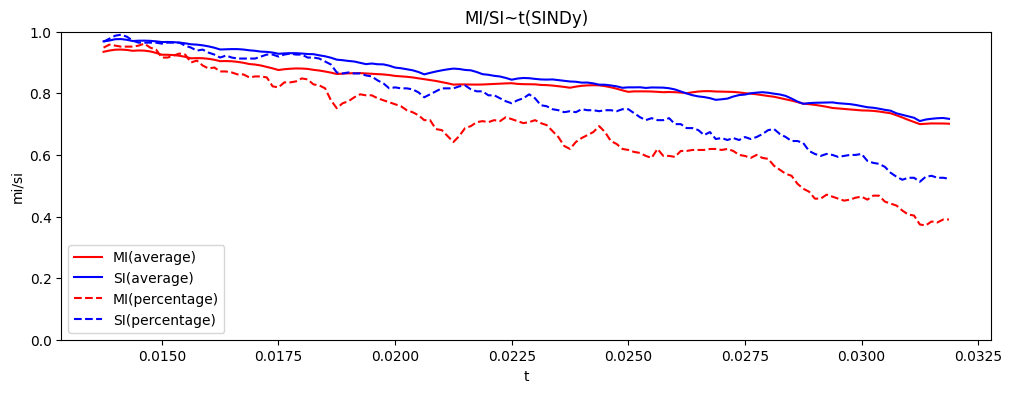

round: 23
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 290.673 1 + 11.107 Vx + 180.414 Vy + -25321.244 t + 8.992 VxVx + 52.641 VyVy + 487921.666 tt + -24.939 VxVy + -1031.147 Vxt + -5810.255 Vyt + 2.599 VxVxVy + -718.691 VxVxt + -2319.645 VyVyt + 1020.668 VxVyt + 1188.521 Vx_2 + -163.948 Vy_2 + -68.639 Vx_1 + 82.955 Vy_1 + -188.314 VxVx_2 + 150.340 VxVy_2 + -107389.918 Vxt_2 + 63.489 VyVx_2 + -79.630 VyVy_2 + 1924450.372 Vyt_2 + -262.208 tVx_2 + 3773.455 tVy_2 + -6889.551 tt_2 + 4.206 VxVxVx_2 + -3016.185 VxVxVy_2 + 5164.458 VxVxt_2 + 7335.966 VyVyVx_2 + 143.999 VyVyVy_2 + -47.849 VyVyt_2 + 1654.722 ttVx_2 + -89.988 ttVy_2 + 96.261 ttt_2 + 221193.881 VxVyVx_2 + 8.547 VxVyVy_2 + -5862.189 VxVyt_2 + 812.877 VxtVx_2 + -19.091 VxtVy_2 + 2959.545 Vxtt_2 + -3919.676 VytVx_2 + 2724.011 VytVy_2 + 6.396 VxVx_1 + -290.714 VxVy_1 + 15473.590 Vxt_1 + -76.187 VyVx_1 + 111.215 VyVy_1 + -414165.912 Vyt_1 + 369.715 tVx_1 + -2331.163 tVy_1 + 7297.515 tt_1 + -5.984 VxVxVx_1 + 2413.160 VxVxVy_1 + -6035.343 VxVx

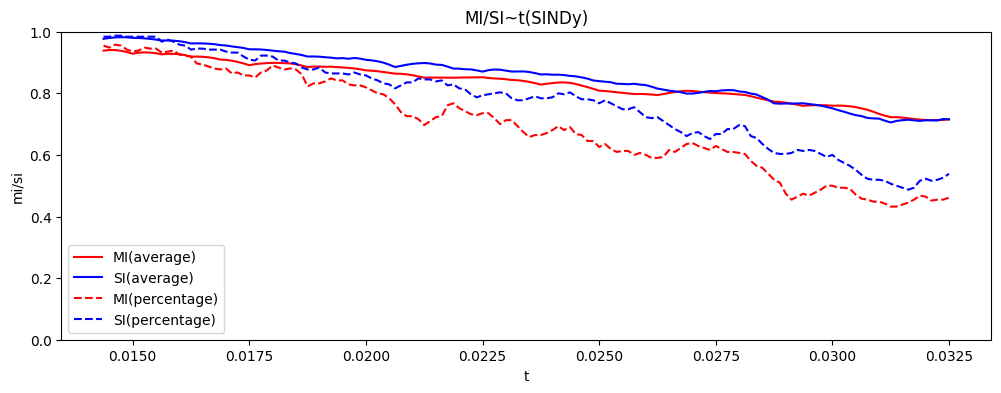

round: 24
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 274.696 1 + -23.767 Vx + 156.538 Vy + -24226.600 t + -2.797 VxVx + 76.061 VyVy + 468466.975 tt + -18.642 VxVy + 667.449 Vxt + -5396.914 Vyt + 2.174 VxVxVy + -269.991 VxVxt + -3342.365 VyVyt + 1131.839 VxVyt + 1395.182 Vx_2 + 406.574 Vy_2 + -321.889 Vx_1 + -238.909 Vy_1 + -142.643 VxVx_2 + 177.764 VxVy_2 + -128189.833 Vxt_2 + 78.692 VyVx_2 + 46.704 VyVy_2 + 2425436.160 Vyt_2 + -320.082 tVx_2 + 1841.608 tVy_2 + -7913.806 tt_2 + -1.637 VxVxVx_2 + -3698.857 VxVxVy_2 + -1532.640 VxVxt_2 + 9455.831 VyVyVx_2 + 284.980 VyVyVy_2 + 54.998 VyVyt_2 + -48750.531 ttVx_2 + 3.298 ttVy_2 + 121.929 ttt_2 + 1281392.164 VxVyVx_2 + -13.549 VxVyVy_2 + -13067.558 VxVyt_2 + -2679.136 VxtVx_2 + -10.052 VxtVy_2 + -327.865 Vxtt_2 + -4529.007 VytVx_2 + 3534.878 VytVy_2 + -162.674 VxVx_1 + -116.153 VxVy_1 + 39359.389 Vxt_1 + 24.690 VyVx_1 + 80.066 VyVy_1 + -963178.768 Vyt_1 + 233.501 tVx_1 + 4158.876 tVy_1 + 1046.475 tt_1 + 4.728 VxVxVx_1 + -1432.087 VxVxVy_1 + -4166

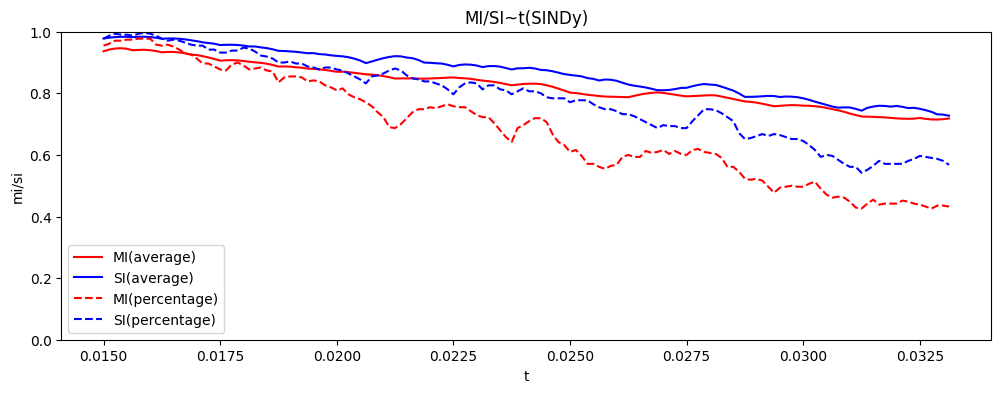

round: 25
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 11.305 Vx + 138.199 Vy + -1403.714 t + -5.007 VxVx + 88.679 VyVy + 16611.812 tt + -22.351 VxVy + -646.214 Vxt + -4725.605 Vyt + -351.934 VxVxt + -3900.956 VyVyt + 1592.012 VxVyt + 2400.702 Vx_2 + 543.244 Vy_2 + -385.089 Vx_1 + -447.091 Vy_1 + -196.832 VxVx_2 + 156.554 VxVy_2 + -211345.455 Vxt_2 + 95.806 VyVx_2 + 127.064 VyVy_2 + 4089331.258 Vyt_2 + -326.097 tVx_2 + 4095.182 tVy_2 + -7755.572 tt_2 + -5.268 VxVxVx_2 + -4394.035 VxVxVy_2 + -5537.759 VxVxt_2 + 10221.631 VyVyVx_2 + 155.957 VyVyVy_2 + 285.196 VyVyt_2 + -59821.286 ttVx_2 + 35.853 ttVy_2 + 168.669 ttt_2 + 1497239.527 VxVyVx_2 + -98.487 VxVyVy_2 + -7932.494 VxVyt_2 + -10327.135 VxtVx_2 + 2.518 VxtVy_2 + -832.761 Vxtt_2 + -5790.917 VytVx_2 + 5956.399 VytVy_2 + 2.075 VxVx_1 + -150.233 VxVy_1 + 42412.529 Vxt_1 + 3.843 VyVx_1 + 96.860 VyVy_1 + -994592.968 Vyt_1 + 240.268 tVx_1 + -2830.223 tVy_1 + 3409.927 tt_1 + 6.823 VxVxVx_1 + -537.563 VxVxVy_1 + -4595.271 VxVxt_1 + -10586.708 VyVyV

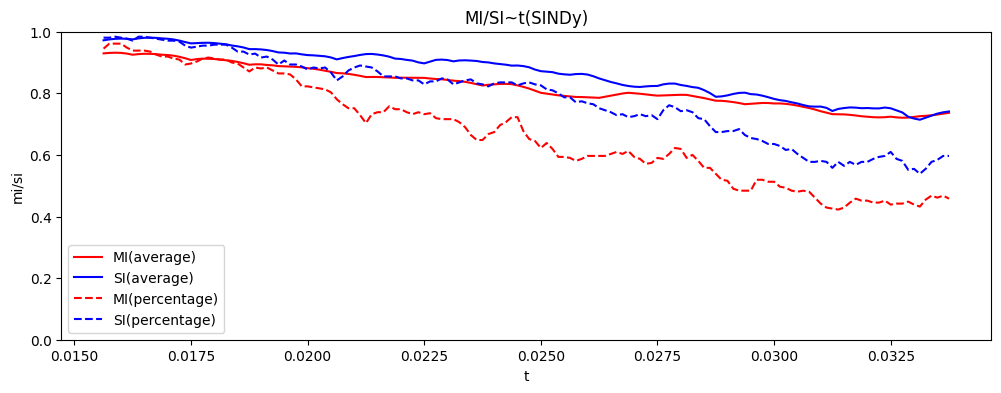

round: 26
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 347.561 1 + -12.985 Vx + 193.574 Vy + -29324.687 t + 2.372 VxVx + 94.998 VyVy + 553668.840 tt + 2.917 VxVy + 157.508 Vxt + -6397.038 Vyt + 0.536 VxVxVy + -551.447 VxVxt + -3887.880 VyVyt + 205.238 VxVyt + 2615.508 Vx_2 + 531.307 Vy_2 + -825.536 Vx_1 + -894.564 Vy_1 + -0.892 VxVx_2 + -53.658 VxVy_2 + -228396.674 Vxt_2 + 19.937 VyVx_2 + 107.237 VyVy_2 + 4397966.898 Vyt_2 + -193.531 tVx_2 + -3638.084 tVy_2 + 337.605 tt_2 + -1.651 VxVxVx_2 + -1320.035 VxVxVy_2 + -4022.167 VxVxt_2 + 4681.436 VyVyVx_2 + 65.154 VyVyVy_2 + 141.775 VyVyt_2 + -49857.788 ttVx_2 + 82.245 ttVy_2 + 123.190 ttt_2 + 1133715.585 VxVyVx_2 + -107.603 VxVyVy_2 + -4482.284 VxVyt_2 + -5529.992 VxtVx_2 + 6.035 VxtVy_2 + -3027.905 Vxtt_2 + -4216.696 VytVx_2 + 6018.448 VytVy_2 + -52.306 VxVx_1 + -252.484 VxVy_1 + 75170.108 Vxt_1 + 45.374 VyVx_1 + -6.087 VyVy_1 + -1572661.975 Vyt_1 + 144.356 tVx_1 + -508.694 tVy_1 + 7069.926 tt_1 + 5.210 VxVxVx_1 + -2040.125 VxVxVy_1 + -858.269 Vx

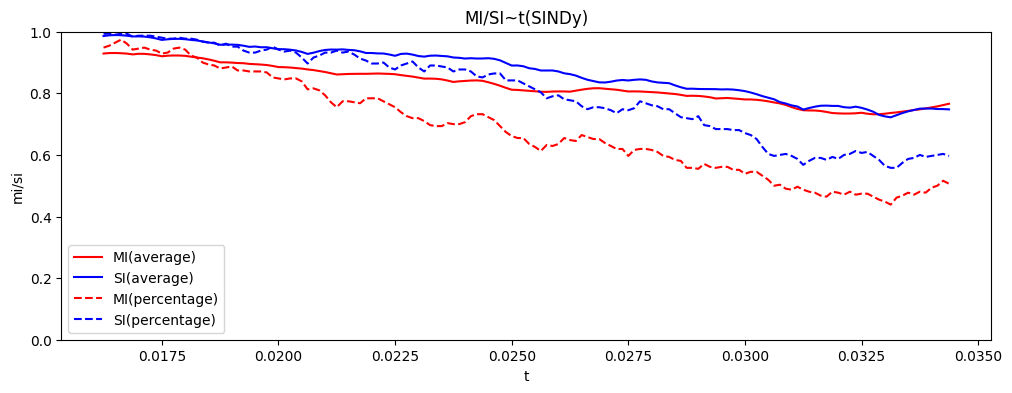

round: 27
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 447.585 1 + -21.612 Vx + 152.233 Vy + -38488.572 t + -0.351 VxVx + 72.443 VyVy + 748496.434 tt + -6.552 VxVy + 552.797 Vxt + -5271.570 Vyt + 1.479 VxVxVy + -306.730 VxVxt + -3156.281 VyVyt + 483.779 VxVyt + 2276.649 Vx_2 + -346.864 Vy_2 + 16.825 Vx_1 + -1057.181 Vy_1 + -131.007 VxVx_2 + 24.577 VxVy_2 + -204372.683 Vxt_2 + 21.413 VyVx_2 + 249.363 VyVy_2 + 3989797.627 Vyt_2 + -264.882 tVx_2 + 1375.319 tVy_2 + -2657.024 tt_2 + 0.363 VxVxVx_2 + -1272.305 VxVxVy_2 + -9741.746 VxVxt_2 + 7488.565 VyVyVx_2 + 19.818 VyVyVy_2 + 247.737 VyVyt_2 + 19895.781 ttVx_2 + 81.598 ttVy_2 + 146.176 ttt_2 + -223241.421 VxVyVx_2 + -228.350 VxVyVy_2 + -3076.969 VxVyt_2 + -9262.105 VxtVx_2 + 4.132 VxtVy_2 + -3108.410 Vxtt_2 + -4936.066 VytVx_2 + 10519.358 VytVy_2 + -148.504 VxVx_1 + 93.384 VxVy_1 + 8451.670 Vxt_1 + 29.954 VyVx_1 + 142.582 VyVy_1 + -296632.315 Vyt_1 + 226.552 tVx_1 + 3195.458 tVy_1 + -5615.090 tt_1 + -3.492 VxVxVx_1 + -1341.054 VxVxVy_1 + -6038.81

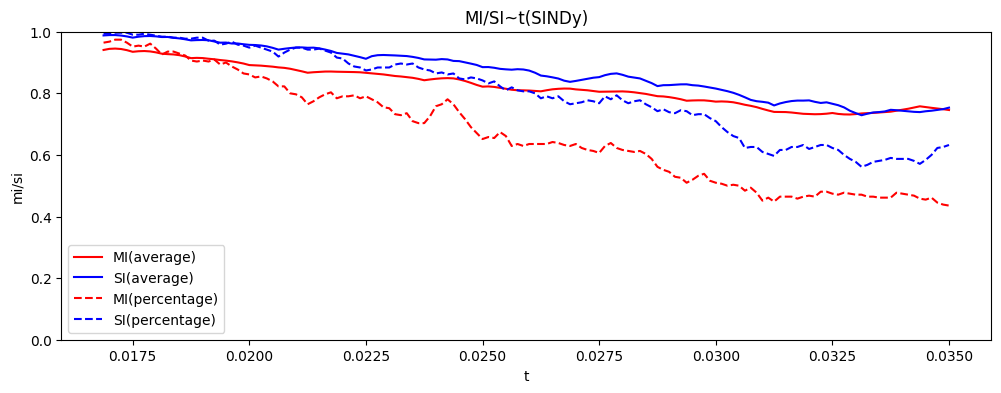

round: 28
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 314.541 1 + 2.575 Vx + 101.714 Vy + -27655.200 t + -0.082 VxVx + 30.258 VyVy + 537281.024 tt + -22.248 VxVy + -472.445 Vxt + -3367.565 Vyt + 1.194 VxVxVy + -416.017 VxVxt + -1677.846 VyVyt + 1066.207 VxVyt + 1961.400 Vx_2 + -533.900 Vy_2 + 356.625 Vx_1 + -1128.534 Vy_1 + -177.739 VxVx_2 + 120.919 VxVy_2 + -179477.046 Vxt_2 + 62.404 VyVx_2 + 290.024 VyVy_2 + 3516553.505 Vyt_2 + -344.579 tVx_2 + 2804.771 tVy_2 + -5322.284 tt_2 + 12.087 VxVxVx_2 + -2836.484 VxVxVy_2 + -10073.082 VxVxt_2 + 10245.074 VyVyVx_2 + 114.874 VyVyVy_2 + -14.378 VyVyt_2 + 32210.676 ttVx_2 + -36.723 ttVy_2 + 112.394 ttt_2 + -418300.739 VxVyVx_2 + -224.932 VxVyVy_2 + -6137.926 VxVyt_2 + -160.913 VxtVx_2 + -19.386 VxtVy_2 + 1139.721 Vxtt_2 + -4206.362 VytVx_2 + 11045.626 VytVy_2 + -118.533 VxVx_1 + -220.195 VxVy_1 + -15652.542 Vxt_1 + -6.737 VyVx_1 + -19.090 VyVy_1 + 134140.968 Vyt_1 + 214.110 tVx_1 + 2568.283 tVy_1 + 5681.800 tt_1 + -9.191 VxVxVx_1 + -168.222 VxVxVy_1 +

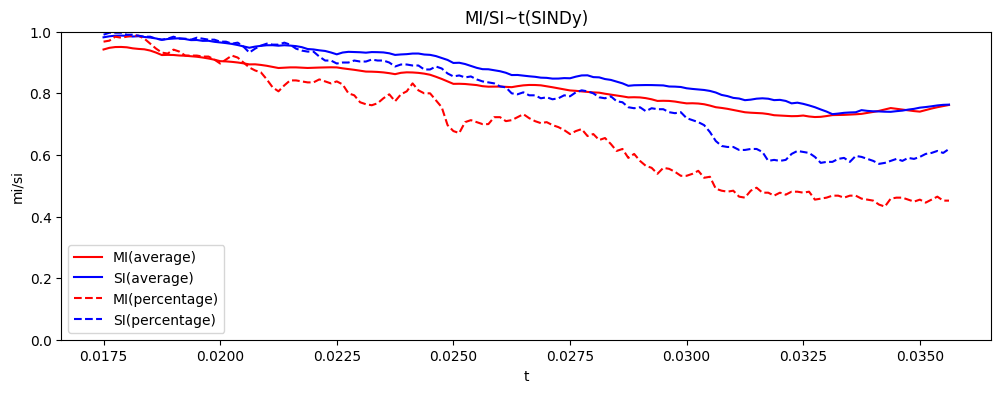

round: 29
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 377.873 1 + -43.276 Vx + 126.310 Vy + -31549.369 t + 3.721 VxVx + 24.716 VyVy + 593843.718 tt + -22.115 VxVy + 1313.561 Vxt + -4647.311 Vyt + 6.871 VxVxVy + -436.634 VxVxt + -1529.416 VyVyt + 901.635 VxVyt + 1593.756 Vx_2 + -875.418 Vy_2 + 575.532 Vx_1 + -33.199 Vy_1 + -200.827 VxVx_2 + 440.818 VxVy_2 + -153036.003 Vxt_2 + 54.537 VyVx_2 + 230.424 VyVy_2 + 3051763.182 Vyt_2 + -639.378 tVx_2 + 3585.807 tVy_2 + -17469.367 tt_2 + 13.859 VxVxVx_2 + -2270.961 VxVxVy_2 + -9273.015 VxVxt_2 + 20981.300 VyVyVx_2 + -300.235 VyVyVy_2 + -3.045 VyVyt_2 + 50916.389 ttVx_2 + 313.403 ttVy_2 + 120.435 ttt_2 + -643183.764 VxVyVx_2 + -129.190 VxVyVy_2 + 8636.231 VxVyt_2 + -417.326 VxtVx_2 + -1.355 VxtVy_2 + -11589.316 Vxtt_2 + -4226.462 VytVx_2 + 8438.921 VytVy_2 + -101.270 VxVx_1 + -290.084 VxVy_1 + -28308.597 Vxt_1 + 25.592 VyVx_1 + -85.747 VyVy_1 + 307121.854 Vyt_1 + 117.703 tVx_1 + 1762.441 tVy_1 + 6879.179 tt_1 + 12.460 VxVxVx_1 + -1387.871 VxVxVy_1 + 1

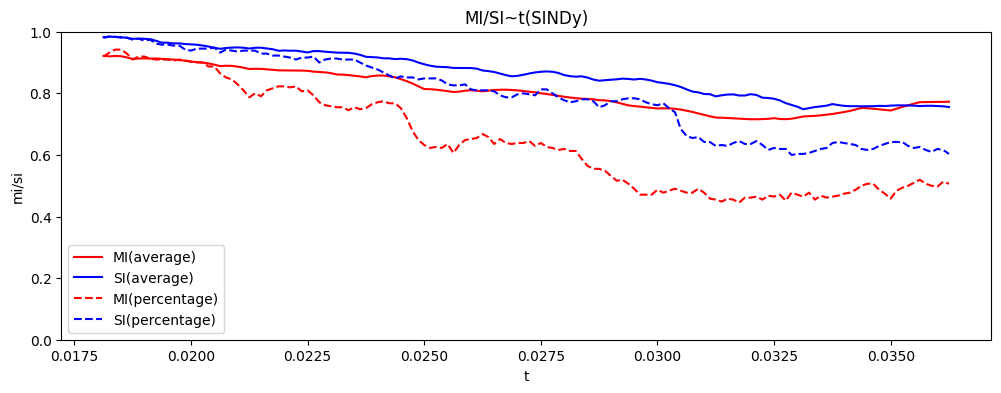

round: 30
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 319.997 1 + 17.450 Vx + 4.848 Vy + -27136.746 t + -27.979 VxVx + -18.137 VyVy + 510301.531 tt + 7.151 VxVy + -853.192 Vxt + -304.784 Vyt + 0.414 VxVxVy + 557.798 VxVxt + -31.778 VyVyt + 49.908 VxVyt + 1534.576 Vx_2 + -1756.319 Vy_2 + 364.526 Vx_1 + -287.617 Vy_1 + -346.349 VxVx_2 + 263.976 VxVy_2 + -146087.760 Vxt_2 + 11.882 VyVx_2 + 266.547 VyVy_2 + 2872684.358 Vyt_2 + -346.312 tVx_2 + 9183.832 tVy_2 + -11563.260 tt_2 + 19.585 VxVxVx_2 + -514.746 VxVxVy_2 + -9145.246 VxVxt_2 + 9442.229 VyVyVx_2 + 71.731 VyVyVy_2 + 93.958 VyVyt_2 + 120229.558 ttVx_2 + -33.853 ttVy_2 + 185.618 ttt_2 + -1958781.269 VxVyVx_2 + -29.957 VxVyVy_2 + -4631.396 VxVyt_2 + -3702.109 VxtVx_2 + -27.281 VxtVy_2 + 1436.265 Vxtt_2 + -6749.807 VytVx_2 + 3622.255 VytVy_2 + -141.900 VxVx_1 + -156.288 VxVy_1 + -12404.360 Vxt_1 + -15.513 VyVx_1 + -98.248 VyVy_1 + 15003.916 Vyt_1 + 141.397 tVx_1 + 3302.682 tVy_1 + 2770.362 tt_1 + 1.658 VxVxVx_1 + 245.384 VxVxVy_1 + 2126.294 Vx

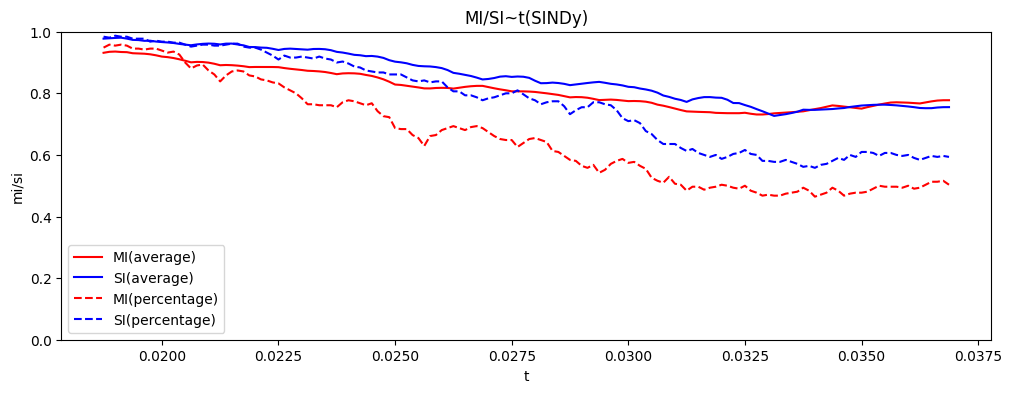

round: 31
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 288.288 1 + -51.631 Vx + 73.465 Vy + -24587.075 t + 13.265 VxVx + -27.666 VyVy + 462079.695 tt + -27.640 VxVy + 1395.932 Vxt + -2886.922 Vyt + 5.521 VxVxVy + -775.922 VxVxt + 344.365 VyVyt + 894.382 VxVyt + 1874.393 Vx_2 + -870.534 Vy_2 + 670.084 Vx_1 + -1070.696 Vy_1 + -193.708 VxVx_2 + 20.521 VxVy_2 + -169622.314 Vxt_2 + -20.453 VyVx_2 + 325.958 VyVy_2 + 3267029.532 Vyt_2 + -433.489 tVx_2 + 3937.121 tVy_2 + -2647.585 tt_2 + 13.651 VxVxVx_2 + 365.986 VxVxVy_2 + -12336.002 VxVxt_2 + 13821.430 VyVyVx_2 + -165.402 VyVyVy_2 + -122.428 VyVyt_2 + 48516.072 ttVx_2 + 104.491 ttVy_2 + 123.976 ttt_2 + -545355.546 VxVyVx_2 + -169.820 VxVyVy_2 + 3927.837 VxVyt_2 + 3250.235 VxtVx_2 + -8.651 VxtVy_2 + -4117.058 Vxtt_2 + -4700.101 VytVx_2 + 9335.872 VytVy_2 + -63.768 VxVx_1 + -32.812 VxVy_1 + -35714.888 Vxt_1 + 22.621 VyVx_1 + -52.185 VyVy_1 + 447396.495 Vyt_1 + 49.729 tVx_1 + -162.918 tVy_1 + -735.217 tt_1 + 6.083 VxVxVx_1 + -1341.891 VxVxVy_1 + 609.2

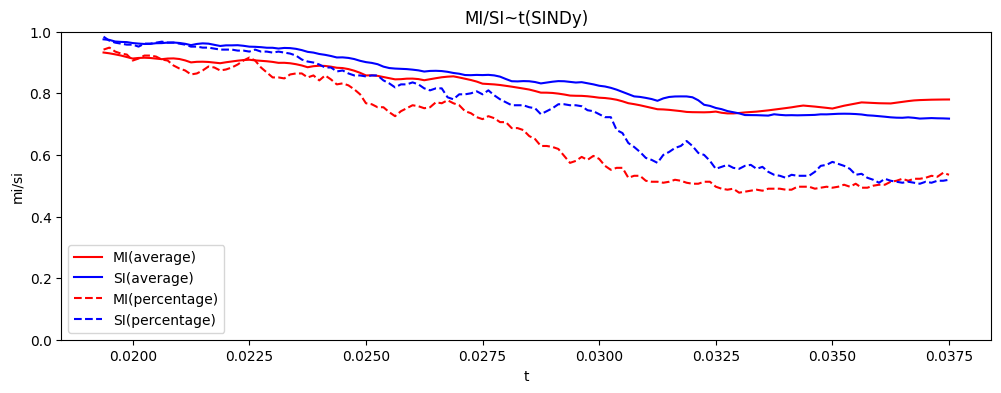

round: 32
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 478.622 1 + -5.930 Vx + -44.914 Vy + -38185.682 t + 8.209 VxVx + -38.716 VyVy + 695911.129 tt + -7.689 VxVy + -69.339 Vxt + 1405.884 Vyt + 1.143 VxVxVy + -625.183 VxVxt + 645.883 VyVyt + 606.887 VxVyt + 1234.365 Vx_2 + -2363.342 Vy_2 + 1175.354 Vx_1 + -716.718 Vy_1 + -270.601 VxVx_2 + -92.890 VxVy_2 + -125611.885 Vxt_2 + -60.791 VyVx_2 + 236.022 VyVy_2 + 2521757.641 Vyt_2 + -197.940 tVx_2 + 6818.115 tVy_2 + 846.519 tt_2 + 11.987 VxVxVx_2 + 1768.465 VxVxVy_2 + -7530.502 VxVxt_2 + 5090.887 VyVyVx_2 + -115.879 VyVyVy_2 + -20.672 VyVyt_2 + 165541.953 ttVx_2 + -224.849 ttVy_2 + 109.604 ttt_2 + -2767130.139 VxVyVx_2 + -41.827 VxVyVy_2 + 2564.824 VxVyt_2 + 322.697 VxtVx_2 + -36.079 VxtVy_2 + 7718.740 Vxtt_2 + -3956.335 VytVx_2 + 2520.485 VytVy_2 + -179.564 VxVx_1 + -21.843 VxVy_1 + -74061.097 Vxt_1 + 31.592 VyVx_1 + -45.551 VyVy_1 + 1138710.406 Vyt_1 + 29.171 tVx_1 + 3896.447 tVy_1 + -1426.437 tt_1 + 10.752 VxVxVx_1 + -1332.229 VxVxVy_1 + 759.47

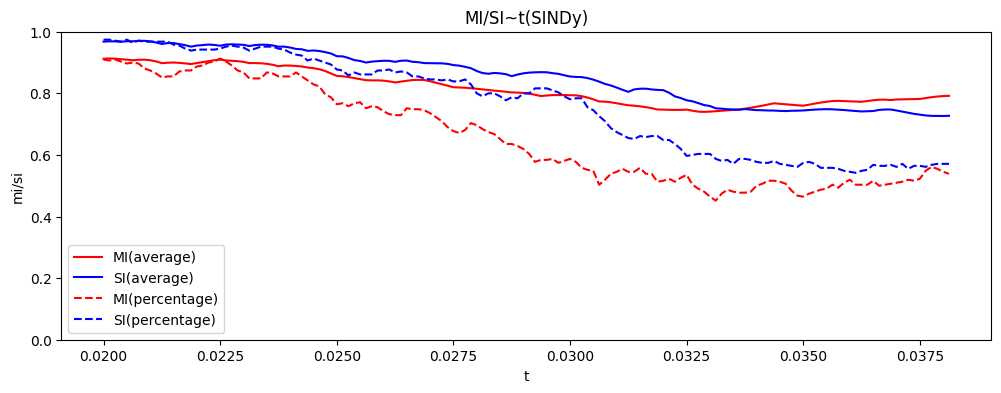

round: 33
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 432.259 1 + -21.178 Vx + 11.614 Vy + -33901.339 t + -17.513 VxVx + -40.821 VyVy + 607734.772 tt + 73.759 VxVy + 586.532 Vxt + -911.855 Vyt + 226.117 VxVxt + 677.438 VyVyt + -2367.108 VxVyt + 1920.934 Vx_2 + -838.415 Vy_2 + 615.561 Vx_1 + -1398.097 Vy_1 + -193.688 VxVx_2 + -43.176 VxVy_2 + -166055.997 Vxt_2 + -16.417 VyVx_2 + 185.818 VyVy_2 + 3104287.711 Vyt_2 + -167.045 tVx_2 + 3615.083 tVy_2 + -2803.066 tt_2 + 23.015 VxVxVx_2 + 72.128 VxVxVy_2 + -7342.948 VxVxt_2 + 4543.226 VyVyVx_2 + -123.952 VyVyVy_2 + -247.439 VyVyt_2 + 55608.588 ttVx_2 + -68.327 ttVy_2 + 53.226 ttt_2 + -849966.275 VxVyVx_2 + 169.674 VxVyVy_2 + 3126.965 VxVyt_2 + 7167.663 VxtVx_2 + -23.584 VxtVy_2 + 2750.936 Vxtt_2 + -2288.723 VytVx_2 + -3376.007 VytVy_2 + 32.910 VxVx_1 + -1.471 VxVy_1 + -37144.725 Vxt_1 + 27.989 VyVx_1 + -124.678 VyVy_1 + 554952.882 Vyt_1 + -134.945 tVx_1 + -3556.504 tVy_1 + -1872.726 tt_1 + 17.870 VxVxVx_1 + -1675.213 VxVxVy_1 + 3008.535 VxVxt_1 + 3

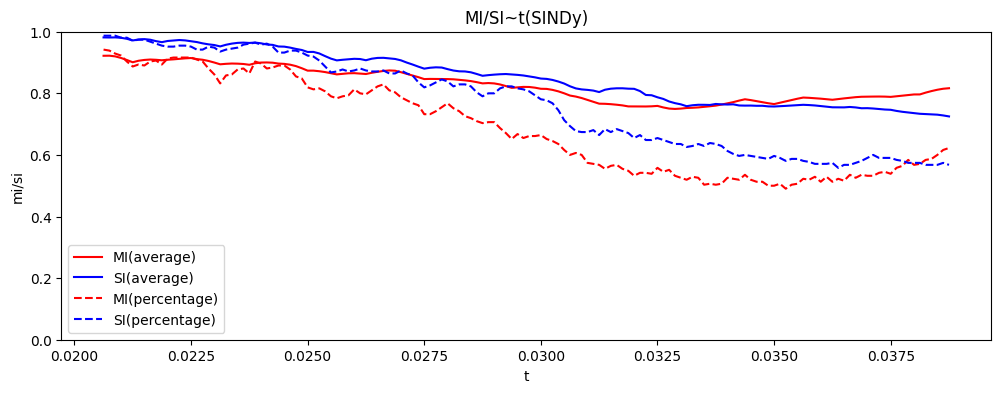

round: 34
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 381.445 1 + 1.563 Vx + 19.468 Vy + -30563.576 t + 1.406 VxVx + -31.055 VyVy + 553511.104 tt + 59.744 VxVy + -391.008 Vxt + -1058.121 Vyt + -1.646 VxVxVy + -411.958 VxVxt + 348.658 VyVyt + -2128.703 VxVyt + 1940.534 Vx_2 + -788.473 Vy_2 + 988.040 Vx_1 + -942.624 Vy_1 + -139.309 VxVx_2 + -241.792 VxVy_2 + -167143.348 Vxt_2 + -2.314 VyVx_2 + 96.922 VyVy_2 + 3118090.598 Vyt_2 + -218.701 tVx_2 + 1574.299 tVy_2 + 2898.915 tt_2 + 32.812 VxVxVx_2 + -596.782 VxVxVy_2 + -4425.210 VxVxt_2 + 6608.665 VyVyVx_2 + -161.813 VyVyVy_2 + -299.629 VyVyt_2 + 53527.376 ttVx_2 + -142.660 ttVy_2 + 48.206 ttt_2 + -825465.910 VxVyVx_2 + 152.501 VxVyVy_2 + 4801.532 VxVyt_2 + 9013.078 VxtVx_2 + -40.945 VxtVy_2 + 4806.625 Vxtt_2 + -2193.900 VytVx_2 + -2174.096 VytVy_2 + 53.663 VxVx_1 + 19.577 VxVy_1 + -58783.485 Vxt_1 + 13.282 VyVx_1 + -192.061 VyVy_1 + 854991.444 Vyt_1 + -185.747 tVx_1 + -4371.397 tVy_1 + -2961.761 tt_1 + 13.741 VxVxVx_1 + -1131.613 VxVxVy_1 + 5483.

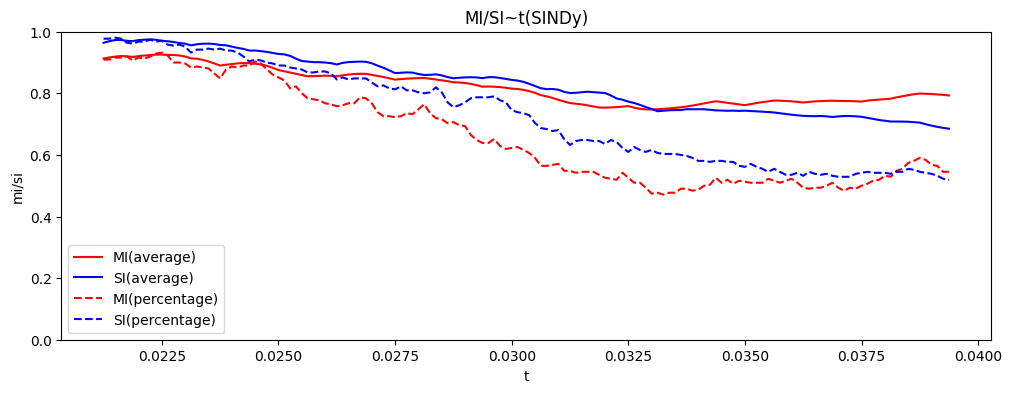

round: 35
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 266.679 1 + -25.759 Vx + -2.391 Vy + -22793.680 t + -13.809 VxVx + -53.493 VyVy + 423926.826 tt + 66.140 VxVy + 560.522 Vxt + -78.769 Vyt + -4.145 VxVxVy + 78.614 VxVxt + 1180.411 VyVyt + -2263.636 VxVyt + 1410.685 Vx_2 + -1151.785 Vy_2 + 632.406 Vx_1 + -1028.700 Vy_1 + -106.861 VxVx_2 + -404.021 VxVy_2 + -129262.931 Vxt_2 + -11.904 VyVx_2 + -6.763 VyVy_2 + 2451748.634 Vyt_2 + -296.668 tVx_2 + 532.950 tVy_2 + 8649.907 tt_2 + 45.133 VxVxVx_2 + -337.628 VxVxVy_2 + -396.748 VxVxt_2 + 10865.896 VyVyVx_2 + 19.656 VyVyVy_2 + -156.463 VyVyt_2 + 74374.917 ttVx_2 + -94.425 ttVy_2 + 68.175 ttt_2 + -1100954.285 VxVyVx_2 + 228.368 VxVyVy_2 + -1226.318 VxVyt_2 + 4939.148 VxtVx_2 + -56.783 VxtVy_2 + 2787.543 Vxtt_2 + -2624.970 VytVx_2 + -5260.154 VytVy_2 + 184.489 VxVx_1 + -36.145 VxVy_1 + -38517.970 Vxt_1 + 111.532 VyVx_1 + -261.625 VyVy_1 + 564302.606 Vyt_1 + -176.939 tVx_1 + -8993.753 tVy_1 + -1085.813 tt_1 + 20.789 VxVxVx_1 + -4346.019 VxVxVy_1 + 7

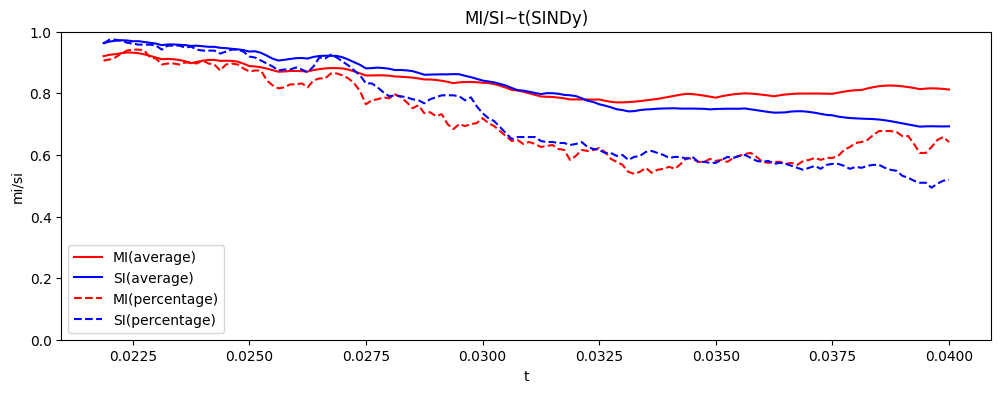

round: 36
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -158.098 1 + -15.007 Vx + 78.230 Vy + 5767.956 t + -19.399 VxVx + -49.082 VyVy + -44260.165 tt + 58.852 VxVy + 134.554 Vxt + -2897.453 Vyt + -3.546 VxVxVy + 226.514 VxVxt + 1092.709 VyVyt + -2175.643 VxVyt + -553.313 Vx_2 + -2377.882 Vy_2 + 1346.324 Vx_1 + -1093.291 Vy_1 + -24.266 VxVx_2 + -379.384 VxVy_2 + -681.283 Vxt_2 + -34.227 VyVx_2 + 149.013 VyVy_2 + 384442.415 Vyt_2 + -43.997 tVx_2 + -1919.823 tVy_2 + 9001.806 tt_2 + 28.202 VxVxVx_2 + 305.382 VxVxVy_2 + -6511.785 VxVxt_2 + 2591.801 VyVyVx_2 + -216.568 VyVyVy_2 + -167.273 VyVyt_2 + 159068.415 ttVx_2 + -147.640 ttVy_2 + 105.897 ttt_2 + -2537197.072 VxVyVx_2 + 10.919 VxVyVy_2 + 5132.990 VxVyt_2 + 5821.157 VxtVx_2 + -40.122 VxtVy_2 + 4190.817 Vxtt_2 + -3888.611 VytVx_2 + 2441.786 VytVy_2 + -33.640 VxVx_1 + -156.094 VxVy_1 + -79049.300 Vxt_1 + -0.570 VyVx_1 + -129.980 VyVy_1 + 1130116.869 Vyt_1 + -314.566 tVx_1 + -2144.798 tVy_1 + 3647.354 tt_1 + 19.156 VxVxVx_1 + -760.203 VxVxVy_1 + 2

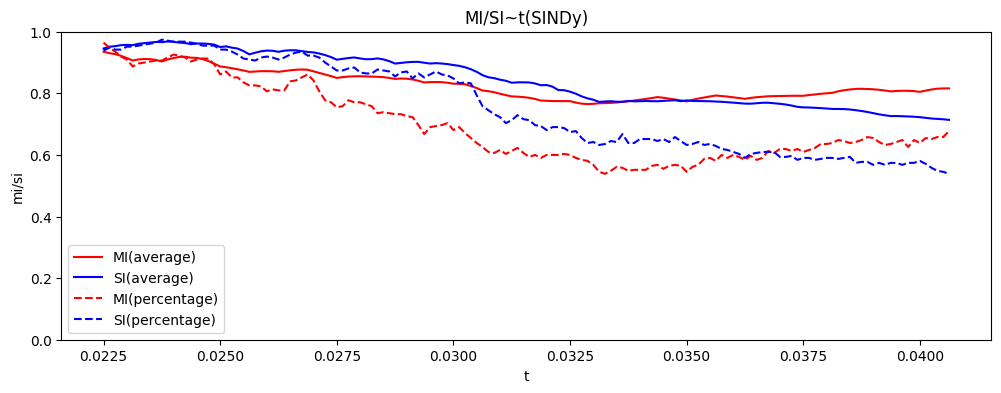

round: 37
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 67.946 1 + -50.277 Vx + 73.975 Vy + -9047.202 t + -16.779 VxVx + -58.853 VyVy + 193181.216 tt + 100.686 VxVy + 1371.757 Vxt + -2573.636 Vyt + -9.725 VxVxVy + 183.125 VxVxt + 1458.705 VyVyt + -3685.383 VxVyt + -654.462 Vx_2 + -1678.015 Vy_2 + 942.377 Vx_1 + -696.277 Vy_1 + -13.641 VxVx_2 + -498.611 VxVy_2 + 2820.934 Vxt_2 + 36.696 VyVx_2 + 43.498 VyVy_2 + 372068.193 Vyt_2 + -13.958 tVx_2 + -2789.900 tVy_2 + 11432.239 tt_2 + 61.394 VxVxVx_2 + -1957.243 VxVxVy_2 + -2953.051 VxVxt_2 + 3233.327 VyVyVx_2 + -164.507 VyVyVy_2 + -137.064 VyVyt_2 + 114623.039 ttVx_2 + -426.864 ttVy_2 + 53.663 ttt_2 + -1838533.761 VxVyVx_2 + 302.776 VxVyVy_2 + 4690.748 VxVyt_2 + 4571.388 VxtVx_2 + -67.264 VxtVy_2 + 12819.976 Vxtt_2 + -2108.755 VytVx_2 + -6781.399 VytVy_2 + 164.006 VxVx_1 + -118.711 VxVy_1 + -55097.963 Vxt_1 + 32.922 VyVx_1 + -322.318 VyVy_1 + 782217.253 Vyt_1 + -252.827 tVx_1 + -8183.426 tVy_1 + 1969.047 tt_1 + 17.583 VxVxVx_1 + -1921.022 VxVxVy_1 +

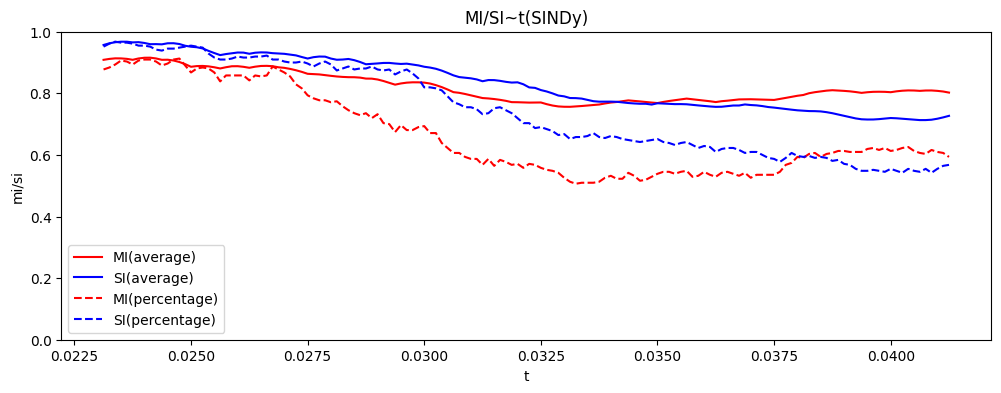

round: 38
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -14.099 1 + 17.531 Vx + 83.186 Vy + -3955.530 t + -22.088 VxVx + -69.508 VyVy + 115074.275 tt + 59.946 VxVy + -612.919 Vxt + -3182.572 Vyt + -4.989 VxVxVy + 371.570 VxVxt + 1841.117 VyVyt + -2350.640 VxVyt + -1166.365 Vx_2 + 144.315 Vy_2 + 1915.121 Vx_1 + -302.380 Vy_1 + 142.458 VxVx_2 + -140.590 VxVy_2 + 32399.135 Vxt_2 + 88.562 VyVx_2 + -183.648 VyVy_2 + -42774.798 Vyt_2 + 8.611 tVx_2 + -7613.102 tVy_2 + 317.899 tt_2 + 53.188 VxVxVx_2 + -3595.449 VxVxVy_2 + 4337.242 VxVxt_2 + 2404.433 VyVyVx_2 + -335.871 VyVyVy_2 + -138.470 VyVyt_2 + -2527.427 ttVx_2 + -235.362 ttVy_2 + 83.988 ttt_2 + -7744.022 VxVyVx_2 + 540.732 VxVyVy_2 + 10002.362 VxVyt_2 + 4859.492 VxtVx_2 + -47.687 VxtVy_2 + 7065.615 Vxtt_2 + -3081.291 VytVx_2 + -13974.750 VytVy_2 + 482.739 VxVx_1 + -404.161 VxVy_1 + -112664.109 Vxt_1 + 169.293 VyVx_1 + -341.691 VyVy_1 + 1620539.850 Vyt_1 + -385.652 tVx_1 + -18729.283 tVy_1 + 10635.958 tt_1 + 44.078 VxVxVx_1 + -6394.454 VxVxVy_1 + 

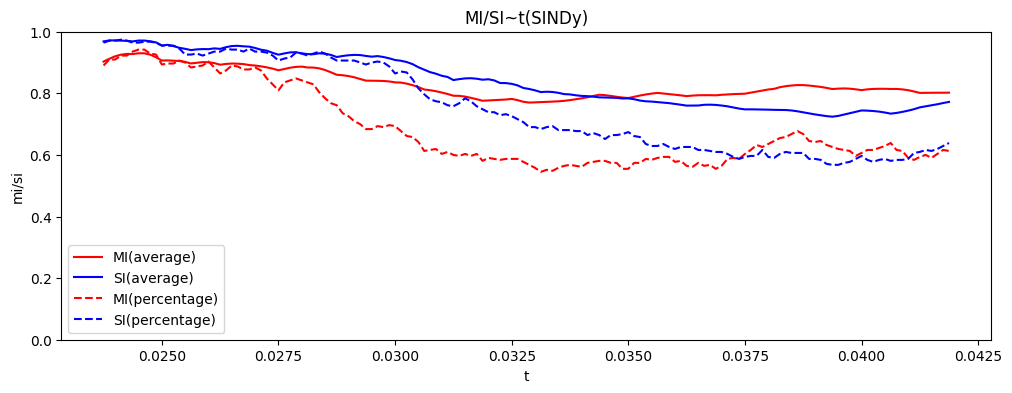

round: 39
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -376.335 1 + 78.992 Vx + 35.899 Vy + 19296.379 t + -29.835 VxVx + -52.280 VyVy + -250021.388 tt + 40.683 VxVy + -2573.298 Vxt + -1719.489 Vyt + -2.769 VxVxVy + 561.858 VxVxt + 1123.537 VyVyt + -1518.150 VxVyt + -1757.344 Vx_2 + 1121.280 Vy_2 + 2265.403 Vx_1 + -135.822 Vy_1 + 294.035 VxVx_2 + 5.526 VxVy_2 + 70597.649 Vxt_2 + 142.382 VyVx_2 + -271.897 VyVy_2 + -646728.664 Vyt_2 + -93.414 tVx_2 + -11959.305 tVy_2 + -3677.854 tt_2 + 58.207 VxVxVx_2 + -5067.665 VxVxVy_2 + 6486.078 VxVxt_2 + 5439.695 VyVyVx_2 + -335.419 VyVyVy_2 + -364.324 VyVyt_2 + -61782.678 ttVx_2 + 7.193 ttVy_2 + 26.596 ttt_2 + 862738.638 VxVyVx_2 + 580.473 VxVyVy_2 + 8491.828 VxVyt_2 + 11237.979 VxtVx_2 + -4.662 VxtVy_2 + -391.594 Vxtt_2 + -1634.885 VytVx_2 + -13561.021 VytVy_2 + 375.203 VxVx_1 + -564.095 VxVy_1 + -132833.803 Vxt_1 + 168.393 VyVx_1 + -448.254 VyVy_1 + 1903512.295 Vyt_1 + -351.182 tVx_1 + -15139.317 tVy_1 + 15572.776 tt_1 + 46.230 VxVxVx_1 + -6153.938 VxVxV

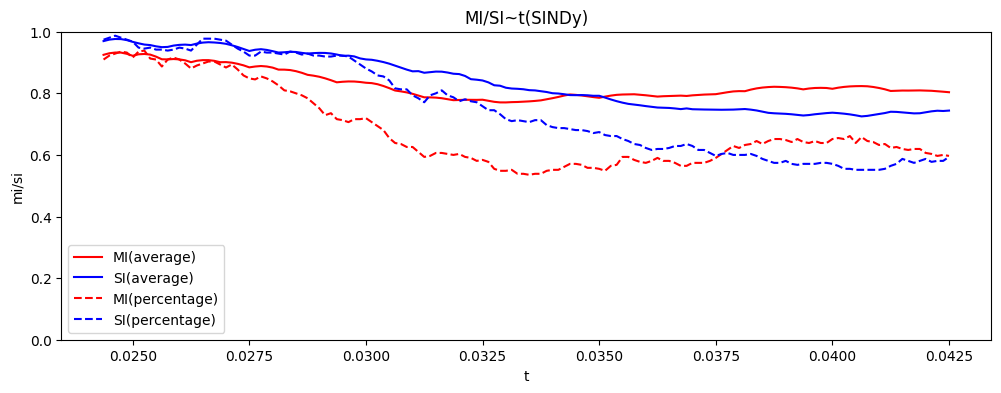

round: 40
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -162.420 1 + 70.847 Vx + 11.690 Vy + 5854.981 t + -39.712 VxVx + -63.806 VyVy + -43278.678 tt + -2.544 VxVy + -2336.698 Vxt + -760.954 Vyt + -3.750 VxVxVy + 856.793 VxVxt + 1586.399 VyVyt + -236.738 VxVyt + -1306.163 Vx_2 + 1361.104 Vy_2 + 1034.403 Vx_1 + -127.925 Vy_1 + -23.624 VxVx_2 + 651.380 VxVy_2 + 49215.821 Vxt_2 + -23.438 VyVx_2 + -475.803 VyVy_2 + -405898.016 Vyt_2 + 65.658 tVx_2 + -2858.301 tVy_2 + -22836.009 tt_2 + 47.177 VxVxVx_2 + -348.382 VxVxVy_2 + 13606.379 VxVxt_2 + 824.567 VyVyVx_2 + -584.737 VyVyVy_2 + -28.195 VyVyt_2 + -74986.884 ttVx_2 + -110.668 ttVy_2 + 67.498 ttt_2 + 1041086.751 VxVyVx_2 + 818.819 VxVyVy_2 + 17743.471 VxVyt_2 + 1021.850 VxtVx_2 + -15.012 VxtVy_2 + 3260.531 Vxtt_2 + -2379.052 VytVx_2 + -22372.423 VytVy_2 + 295.964 VxVx_1 + -242.225 VxVy_1 + -62789.315 Vxt_1 + 125.805 VyVx_1 + -496.292 VyVy_1 + 923273.036 Vyt_1 + -285.029 tVx_1 + -12468.679 tVy_1 + 5828.917 tt_1 + 39.766 VxVxVx_1 + -4849.874 VxVxVy_1

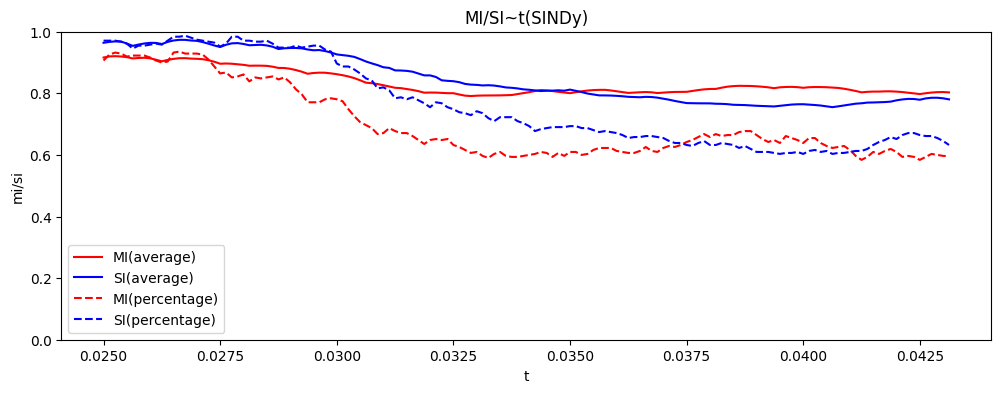

round: 41
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -286.863 1 + 76.991 Vx + 33.620 Vy + 12965.141 t + -33.990 VxVx + -61.218 VyVy + -143111.348 tt + 51.659 VxVy + -2468.603 Vxt + -1285.720 Vyt + -5.068 VxVxVy + 688.045 VxVxt + 1527.959 VyVyt + -1710.437 VxVyt + -1480.752 Vx_2 + 923.895 Vy_2 + 2298.141 Vx_1 + 6.168 Vy_1 + 55.328 VxVx_2 + 335.416 VxVy_2 + 57837.387 Vxt_2 + 67.285 VyVx_2 + -353.037 VyVy_2 + -510898.328 Vyt_2 + -185.619 tVx_2 + -4982.267 tVy_2 + -13143.765 tt_2 + 63.973 VxVxVx_2 + -2899.316 VxVxVy_2 + 9801.620 VxVxt_2 + 8669.675 VyVyVx_2 + -599.784 VyVyVy_2 + -188.207 VyVyt_2 + -52853.607 ttVx_2 + 266.770 ttVy_2 + 53.265 ttt_2 + 768248.421 VxVyVx_2 + 692.674 VxVyVy_2 + 16911.307 VxVyt_2 + 5945.985 VxtVx_2 + -5.637 VxtVy_2 + -7654.945 Vxtt_2 + -2096.458 VytVx_2 + -18416.062 VytVy_2 + 294.135 VxVx_1 + -387.396 VxVy_1 + -129877.460 Vxt_1 + 122.729 VyVx_1 + -324.252 VyVy_1 + 1794946.131 Vyt_1 + -664.337 tVx_1 + -12794.058 tVy_1 + 10863.637 tt_1 + 42.514 VxVxVx_1 + -4932.978 VxVxV

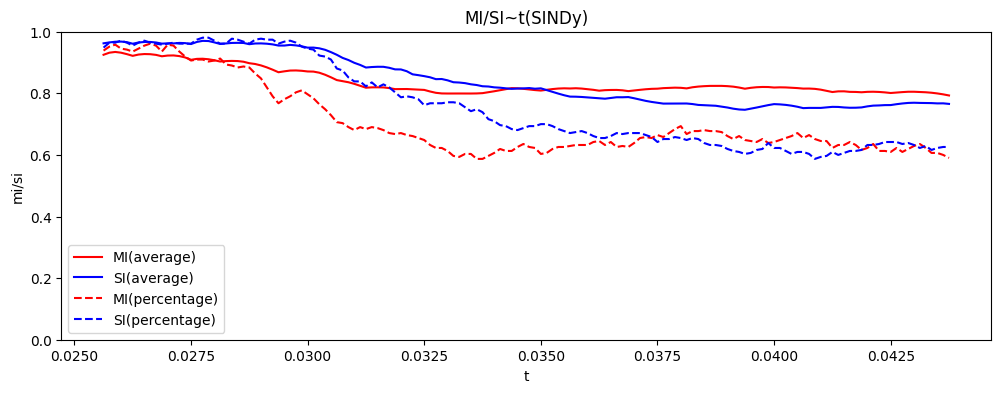

round: 42
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -143.531 1 + 136.128 Vx + -31.735 Vy + 5103.103 t + -10.252 VxVx + -52.369 VyVy + -37771.283 tt + -5.232 VxVy + -4100.936 Vxt + 444.439 Vyt + -0.390 VxVxVy + 49.478 VxVxt + 1173.710 VyVyt + -34.143 VxVyt + -2660.489 Vx_2 + 1726.455 Vy_2 + 2295.062 Vx_1 + 325.869 Vy_1 + 45.034 VxVx_2 + 388.087 VxVy_2 + 127420.136 Vxt_2 + 11.927 VyVx_2 + -667.723 VyVy_2 + -1517555.934 Vyt_2 + 83.853 tVx_2 + -4568.482 tVy_2 + -15472.307 tt_2 + 53.664 VxVxVx_2 + -1398.847 VxVxVy_2 + 18601.248 VxVxt_2 + 743.992 VyVyVx_2 + -413.385 VyVyVy_2 + -196.031 VyVyt_2 + -97975.676 ttVx_2 + 263.965 ttVy_2 + -25.385 ttt_2 + 1390800.392 VxVyVx_2 + 509.969 VxVyVy_2 + 11395.000 VxVyt_2 + 5118.892 VxtVx_2 + 27.857 VxtVy_2 + -7813.254 Vxtt_2 + 257.658 VytVx_2 + -12095.844 VytVy_2 + 143.852 VxVx_1 + -347.552 VxVy_1 + -130861.113 Vxt_1 + 35.969 VyVx_1 + -410.638 VyVy_1 + 1825855.917 Vyt_1 + -675.247 tVx_1 + -7776.330 tVy_1 + 8538.551 tt_1 + 28.721 VxVxVx_1 + -2128.945 VxVxVy_1 +

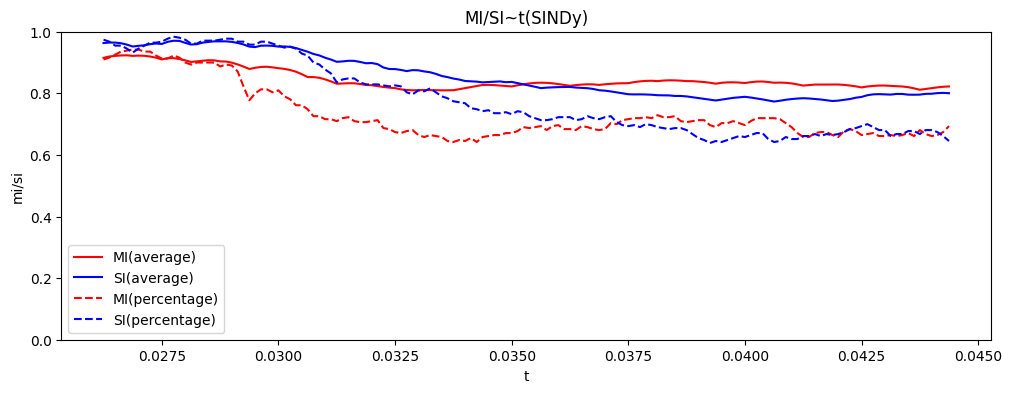

round: 43
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -384.093 1 + 135.781 Vx + 9.598 Vy + 18443.033 t + -6.160 VxVx + -69.286 VyVy + -221011.134 tt + -48.290 VxVy + -4049.712 Vxt + -765.895 Vyt + -10.793 VxVxVy + 21.938 VxVxt + 1848.857 VyVyt + 709.146 VxVyt + -4072.599 Vx_2 + -559.792 Vy_2 + 1692.721 Vx_1 + 787.568 Vy_1 + 131.102 VxVx_2 + 649.115 VxVy_2 + 202522.507 Vxt_2 + 28.808 VyVx_2 + -385.613 VyVy_2 + -2507699.807 Vyt_2 + 51.957 tVx_2 + -7035.337 tVy_2 + -23162.399 tt_2 + 43.527 VxVxVx_2 + -1834.636 VxVxVy_2 + 11365.479 VxVxt_2 + 821.032 VyVyVx_2 + -819.401 VyVyVy_2 + -115.203 VyVyt_2 + 38586.347 ttVx_2 + 88.798 ttVy_2 + 1.095 ttt_2 + -616215.904 VxVyVx_2 + 700.756 VxVyVy_2 + 22483.069 VxVyt_2 + 3505.267 VxtVx_2 + 27.305 VxtVy_2 + -3143.530 Vxtt_2 + -446.135 VytVx_2 + -17504.287 VytVy_2 + 403.098 VxVx_1 + -491.979 VxVy_1 + -91198.839 Vxt_1 + 137.560 VyVx_1 + -99.015 VyVy_1 + 1188244.120 Vyt_1 + -557.516 tVx_1 + -15682.302 tVy_1 + 13606.362 tt_1 + 30.419 VxVxVx_1 + -5200.250 VxVxVy_1 

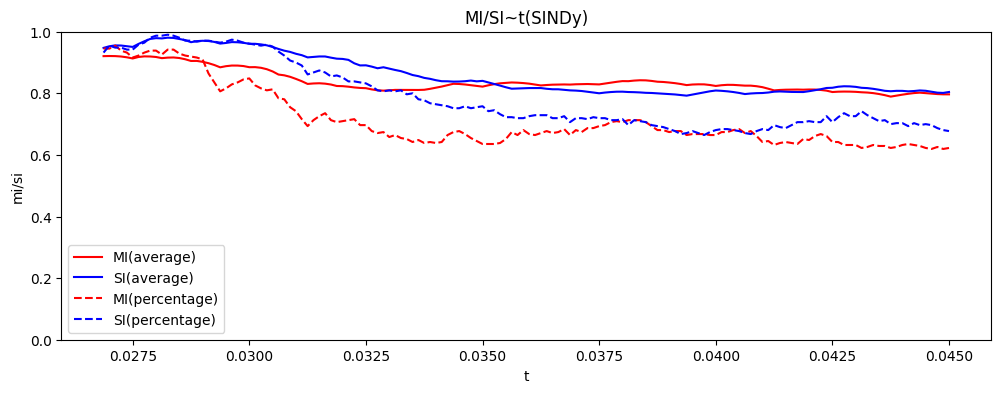

round: 44
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -359.847 1 + 162.981 Vx + -48.554 Vy + 17101.764 t + -55.282 VyVy + -201896.022 tt + 18.115 VxVy + -4870.740 Vxt + 1053.982 Vyt + -2.853 VxVxVy + -222.324 VxVxt + 1217.872 VyVyt + -704.551 VxVyt + -3497.534 Vx_2 + 1105.823 Vy_2 + 1589.699 Vx_1 + 613.418 Vy_1 + -134.260 VxVx_2 + 826.348 VxVy_2 + 169809.190 Vxt_2 + 34.563 VyVx_2 + -758.861 VyVy_2 + -2047565.502 Vyt_2 + 236.211 tVx_2 + 373.742 tVy_2 + -27187.728 tt_2 + 48.986 VxVxVx_2 + -1960.214 VxVxVy_2 + 20879.074 VxVxt_2 + -3465.772 VyVyVx_2 + -997.571 VyVyVy_2 + -292.146 VyVyt_2 + -55809.234 ttVx_2 + 385.091 ttVy_2 + -95.406 ttt_2 + 713872.482 VxVyVx_2 + 668.685 VxVyVy_2 + 27125.229 VxVyt_2 + 7451.258 VxtVx_2 + 83.365 VxtVy_2 + -11922.409 Vxtt_2 + 2095.695 VytVx_2 + -15765.213 VytVy_2 + 111.582 VxVx_1 + -310.387 VxVy_1 + -85884.430 Vxt_1 + 20.674 VyVx_1 + -152.608 VyVy_1 + 1125312.838 Vyt_1 + -595.872 tVx_1 + -7126.145 tVy_1 + 8079.178 tt_1 + 37.721 VxVxVx_1 + -1914.740 VxVxVy_1 + 4066.

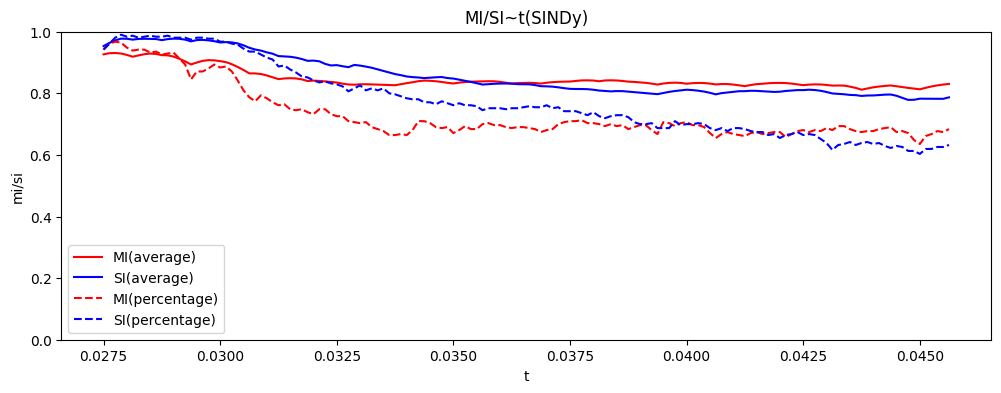

round: 45
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -166.417 1 + 184.451 Vx + 12.148 Vy + 6724.473 t + 31.819 VxVx + -61.705 VyVy + -65512.451 tt + 1.388 VxVy + -5354.221 Vxt + -718.657 Vyt + -3.109 VxVxVy + -1036.359 VxVxt + 1482.599 VyVyt + -366.149 VxVyt + -2815.149 Vx_2 + 1101.497 Vy_2 + 1069.875 Vx_1 + 881.280 Vy_1 + -107.842 VxVx_2 + 504.433 VxVy_2 + 135332.363 Vxt_2 + -1.952 VyVx_2 + -688.159 VyVy_2 + -1616000.409 Vyt_2 + 7.813 tVx_2 + -432.685 tVy_2 + -18130.464 tt_2 + 59.071 VxVxVx_2 + -973.348 VxVxVy_2 + 18872.670 VxVxt_2 + 2845.381 VyVyVx_2 + -531.844 VyVyVy_2 + -58.413 VyVyt_2 + -60151.826 ttVx_2 + 163.145 ttVy_2 + -48.281 ttt_2 + 817407.184 VxVyVx_2 + 575.744 VxVyVy_2 + 13855.889 VxVyt_2 + 1485.314 VxtVx_2 + 28.931 VxtVy_2 + -5196.430 Vxtt_2 + 1118.869 VytVx_2 + -13440.438 VytVy_2 + 365.248 VxVx_1 + -240.314 VxVy_1 + -57793.041 Vxt_1 + 78.275 VyVx_1 + -228.601 VyVy_1 + 747076.907 Vyt_1 + -522.697 tVx_1 + -14219.549 tVy_1 + 6496.129 tt_1 + 14.533 VxVxVx_1 + -3381.050 VxVxVy_1 +

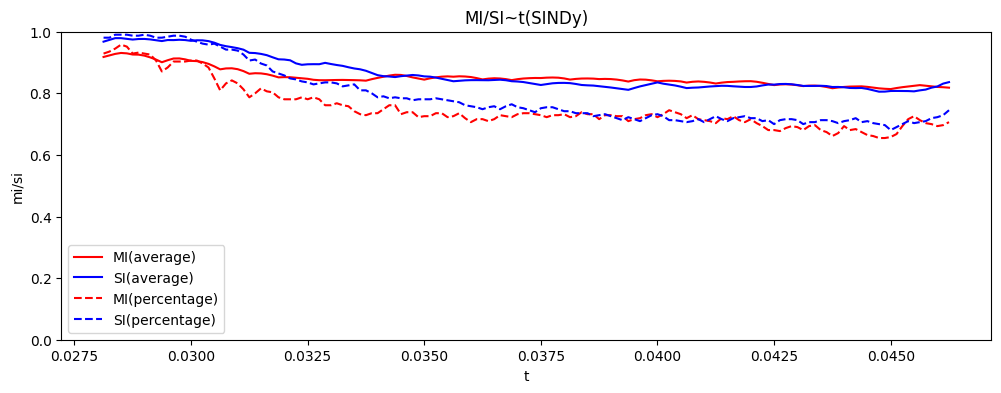

round: 46
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -501.518 1 + 243.848 Vx + -80.958 Vy + 24896.907 t + 51.129 VxVx + -49.347 VyVy + -307925.306 tt + 15.005 VxVy + -6852.058 Vxt + 1616.770 Vyt + -8.333 VxVxVy + -1543.007 VxVxt + 1074.175 VyVyt + -1004.855 VxVyt + -3826.078 Vx_2 + 270.111 Vy_2 + 720.220 Vx_1 + 1316.868 Vy_1 + -235.007 VxVx_2 + 572.067 VxVy_2 + 190569.644 Vxt_2 + -86.408 VyVx_2 + -882.881 VyVy_2 + -2358927.629 Vyt_2 + 30.177 tVx_2 + 2454.032 tVy_2 + -18985.492 tt_2 + 57.078 VxVxVx_2 + 1087.446 VxVxVy_2 + 23524.175 VxVxt_2 + 2703.380 VyVyVx_2 + -761.077 VyVyVy_2 + -143.790 VyVyt_2 + -18173.881 ttVx_2 + 92.019 ttVy_2 + -181.813 ttt_2 + 288171.014 VxVyVx_2 + 804.000 VxVyVy_2 + 19441.354 VxVyt_2 + 3519.858 VxtVx_2 + 50.074 VxtVy_2 + -3250.808 Vxtt_2 + 4845.569 VytVx_2 + -17274.632 VytVy_2 + 238.142 VxVx_1 + -287.356 VxVy_1 + -37972.788 Vxt_1 + 27.826 VyVx_1 + -334.578 VyVy_1 + 470818.488 Vyt_1 + -525.552 tVx_1 + -11303.185 tVy_1 + 7269.826 tt_1 + 17.986 VxVxVx_1 + -2192.000 VxV

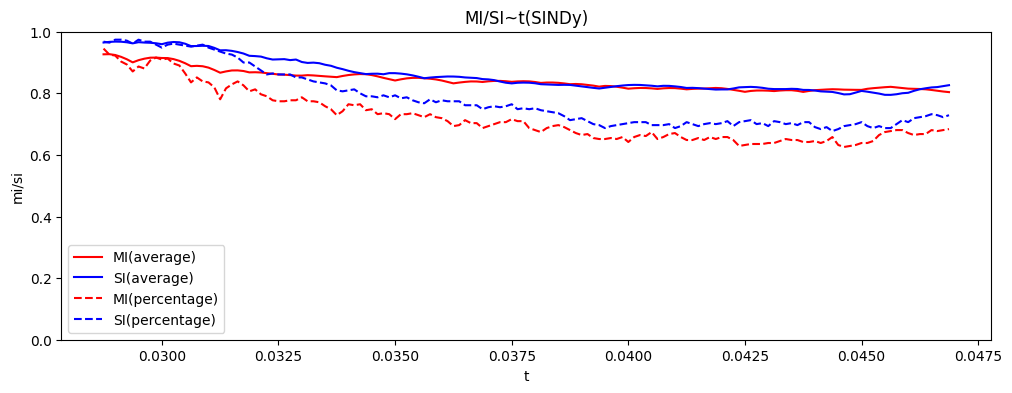

round: 47
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -586.245 1 + 192.066 Vx + -125.998 Vy + 29046.795 t + -14.685 VxVx + -49.409 VyVy + -356772.391 tt + -93.874 VxVy + -5646.263 Vxt + 2981.221 Vyt + -7.091 VxVxVy + 248.457 VxVxt + 1039.459 VyVyt + 2227.269 VxVyt + -4087.615 Vx_2 + -2385.848 Vy_2 + -488.724 Vx_1 + 592.447 Vy_1 + -34.952 VxVx_2 + 783.005 VxVy_2 + 200317.793 Vxt_2 + 2.291 VyVx_2 + -989.055 VyVy_2 + -2436263.168 Vyt_2 + 4.490 tVx_2 + -2077.874 tVy_2 + -25156.107 tt_2 + 40.199 VxVxVx_2 + -820.724 VxVxVy_2 + 26176.672 VxVxt_2 + 2317.282 VyVyVx_2 + -535.681 VyVyVy_2 + -2.273 VyVyt_2 + 133707.458 ttVx_2 + 287.592 ttVy_2 + -141.799 ttt_2 + -1816387.017 VxVyVx_2 + 1140.295 VxVyVy_2 + 13465.278 VxVyt_2 + -1034.806 VxtVx_2 + 46.910 VxtVy_2 + -9119.347 Vxtt_2 + 3612.493 VytVx_2 + -27833.649 VytVy_2 + 324.724 VxVx_1 + -238.585 VxVy_1 + 31106.045 Vxt_1 + 2.296 VyVx_1 + -355.205 VyVy_1 + -501449.128 Vyt_1 + -453.045 tVx_1 + -12534.296 tVy_1 + 5804.304 tt_1 + 9.501 VxVxVx_1 + -1194.587 VxV

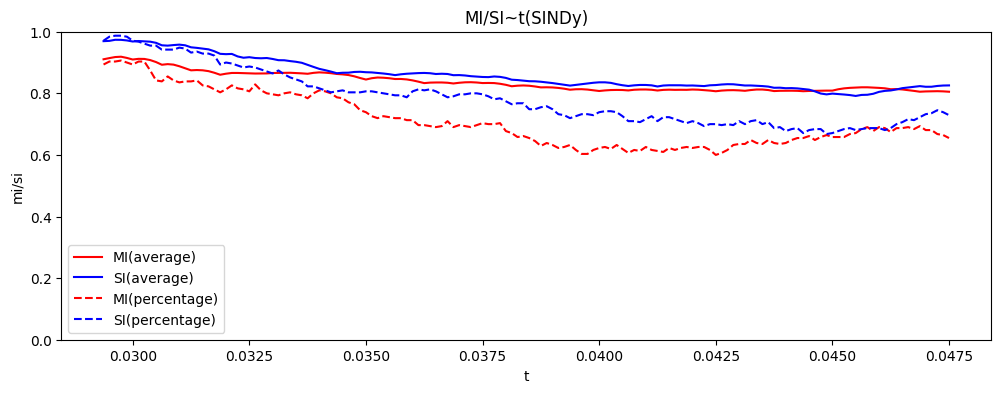

round: 48
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -504.598 1 + 182.541 Vx + -82.949 Vy + 24628.699 t + -11.764 VxVx + -62.674 VyVy + -297238.506 tt + -118.545 VxVy + -5200.442 Vxt + 1793.141 Vyt + -8.249 VxVxVy + 197.771 VxVxt + 1381.378 VyVyt + 2629.531 VxVyt + -4016.955 Vx_2 + -1610.428 Vy_2 + 355.471 Vx_1 + -714.851 Vy_1 + 305.849 VxVx_2 + -51.786 VxVy_2 + 197313.494 Vxt_2 + 115.431 VyVx_2 + -425.712 VyVy_2 + -2399044.769 Vyt_2 + -215.636 tVx_2 + -11262.113 tVy_2 + -3509.027 tt_2 + 51.283 VxVxVx_2 + -3976.409 VxVxVy_2 + 11039.118 VxVxt_2 + 7719.606 VyVyVx_2 + -417.529 VyVyVy_2 + 81.092 VyVyt_2 + 81877.063 ttVx_2 + 147.772 ttVy_2 + -137.211 ttt_2 + -1013178.520 VxVyVx_2 + 629.956 VxVyVy_2 + 10089.621 VxVyt_2 + -2714.910 VxtVx_2 + 39.986 VxtVy_2 + -4766.700 Vxtt_2 + 3513.541 VytVx_2 + -13547.739 VytVy_2 + 185.849 VxVx_1 + -213.885 VxVy_1 + -16274.098 Vxt_1 + 54.284 VyVx_1 + -340.932 VyVy_1 + 157878.922 Vyt_1 + -357.684 tVx_1 + -9354.455 tVy_1 + 5015.461 tt_1 + 44.611 VxVxVx_1 + -2866.60

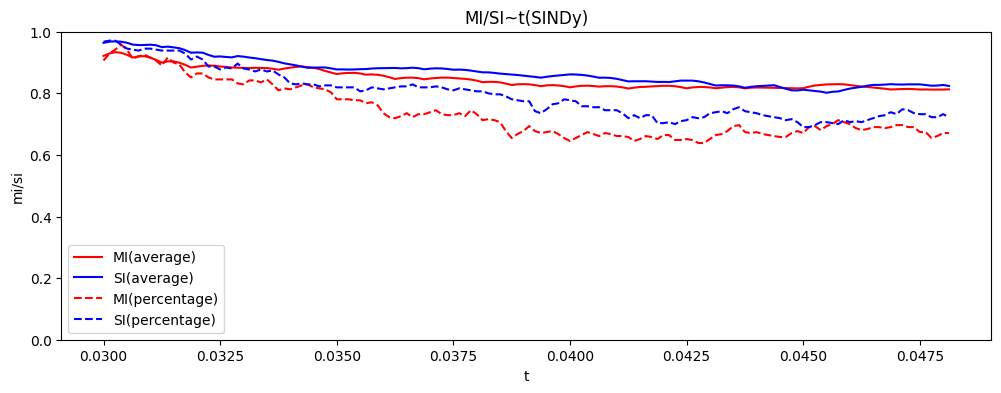

round: 49
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -566.308 1 + 220.192 Vx + -180.526 Vy + 27902.638 t + -10.535 VxVx + -16.800 VyVy + -340548.000 tt + -181.470 VxVy + -6150.701 Vxt + 3962.004 Vyt + -4.221 VxVxVy + 153.698 VxVxt + 440.334 VyVyt + 4347.033 VxVyt + -4176.326 Vx_2 + -2903.600 Vy_2 + -659.377 Vx_1 + 173.740 Vy_1 + 165.218 VxVx_2 + 373.559 VxVy_2 + 204394.106 Vxt_2 + 47.423 VyVx_2 + -607.015 VyVy_2 + -2477010.105 Vyt_2 + -95.093 tVx_2 + -7494.284 tVy_2 + -13596.287 tt_2 + 40.667 VxVxVx_2 + -2172.044 VxVxVy_2 + 15723.360 VxVxt_2 + 4517.663 VyVyVx_2 + -740.035 VyVyVy_2 + 276.639 VyVyt_2 + 148357.152 ttVx_2 + 96.122 ttVy_2 + -116.459 ttt_2 + -1856579.001 VxVyVx_2 + 964.943 VxVyVy_2 + 17461.583 VxVyt_2 + -7227.222 VxtVx_2 + 45.493 VxtVy_2 + -3794.585 Vxtt_2 + 2685.342 VytVx_2 + -21445.222 VytVy_2 + 96.094 VxVx_1 + -2.330 VxVy_1 + 34622.254 Vxt_1 + -70.465 VyVx_1 + -422.338 VyVy_1 + -471796.461 Vyt_1 + -395.164 tVx_1 + -6568.170 tVy_1 + 424.610 tt_1 + 30.604 VxVxVx_1 + 665.937 VxVx

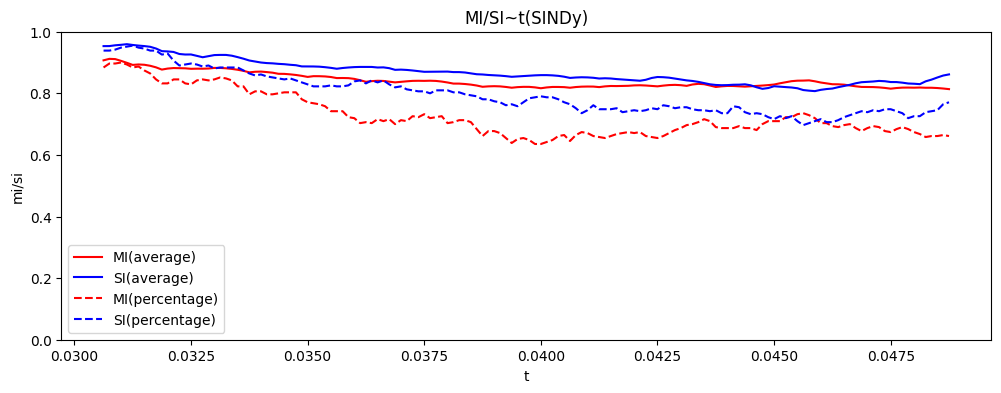

round: 50
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 18.744 1 + 208.457 Vx + -301.377 Vy + -1689.372 t + -49.793 VxVx + -38.746 VyVy + 28355.586 tt + -287.291 VxVy + -5671.545 Vxt + 6954.816 Vyt + -7.472 VxVxVy + 1279.054 VxVxt + 1134.528 VyVyt + 6926.158 VxVyt + -1992.177 Vx_2 + -512.198 Vy_2 + -172.782 Vx_1 + -71.658 Vy_1 + 356.940 VxVx_2 + -1306.351 VxVy_2 + 95473.451 Vxt_2 + 59.907 VyVx_2 + -264.865 VyVy_2 + -1131739.595 Vyt_2 + -863.479 tVx_2 + -11066.176 tVy_2 + 27011.562 tt_2 + 22.208 VxVxVx_2 + -1918.998 VxVxVy_2 + 8030.277 VxVxt_2 + 22245.790 VyVyVx_2 + 1235.940 VyVyVy_2 + -14.126 VyVyt_2 + 22561.152 ttVx_2 + 609.850 ttVy_2 + -6.575 ttt_2 + -238739.666 VxVyVx_2 + 310.691 VxVyVy_2 + -30008.721 VxVyt_2 + -24.650 VxtVx_2 + -22.691 VxtVy_2 + -15303.030 Vxtt_2 + 266.622 VytVx_2 + -8250.018 VytVy_2 + -47.643 VxVx_1 + -160.175 VxVy_1 + 9065.383 Vxt_1 + -114.064 VyVx_1 + -442.156 VyVy_1 + -136490.609 Vyt_1 + -307.067 tVx_1 + -2439.910 tVy_1 + 5523.155 tt_1 + 29.208 VxVxVx_1 + 1865.730 VxVx

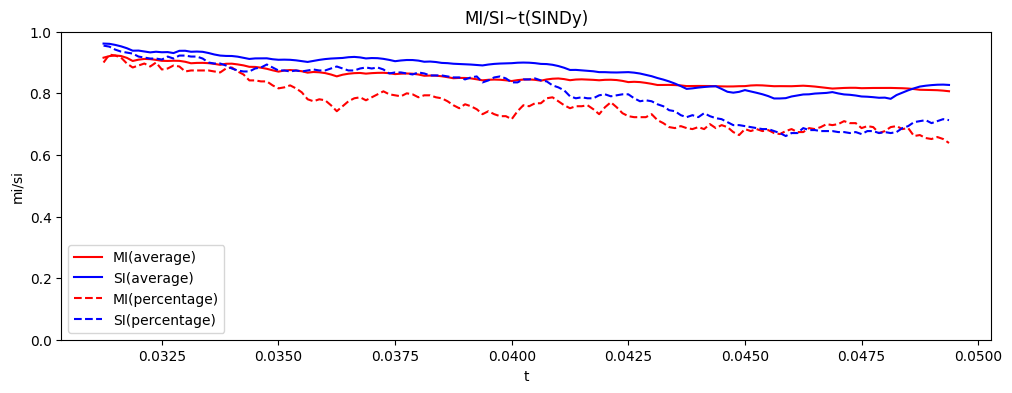

round: 51
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -507.539 1 + 157.080 Vx + -202.468 Vy + 24842.426 t + -24.036 VxVx + -1.719 VyVy + -301218.802 tt + -121.340 VxVy + -4641.855 Vxt + 4580.044 Vyt + -13.169 VxVxVy + 530.389 VxVxt + -42.795 VyVyt + 2431.696 VxVyt + -2569.203 Vx_2 + 439.312 Vy_2 + -403.908 Vx_1 + 1270.269 Vy_1 + 445.508 VxVx_2 + -1064.204 VxVy_2 + 125242.594 Vxt_2 + 113.273 VyVx_2 + -85.912 VyVy_2 + -1510208.297 Vyt_2 + -535.464 tVx_2 + -13610.654 tVy_2 + 18777.508 tt_2 + 21.372 VxVxVx_2 + -3387.794 VxVxVy_2 + 4231.755 VxVxt_2 + 13369.782 VyVyVx_2 + 1541.086 VyVyVy_2 + 24.685 VyVyt_2 + -27363.232 ttVx_2 + 483.432 ttVy_2 + -73.731 ttt_2 + 394076.256 VxVyVx_2 + -201.068 VxVyVy_2 + -36486.205 VxVyt_2 + -817.788 VxtVx_2 + -22.152 VxtVy_2 + -11492.487 Vxtt_2 + 2114.227 VytVx_2 + 4552.882 VytVy_2 + 24.533 VxVx_1 + 77.303 VxVy_1 + 20811.035 Vxt_1 + -213.402 VyVx_1 + -563.096 VyVy_1 + -289606.936 Vyt_1 + -756.634 tVx_1 + -4149.875 tVy_1 + -600.912 tt_1 + -9.508 VxVxVx_1 + 4828.145 V

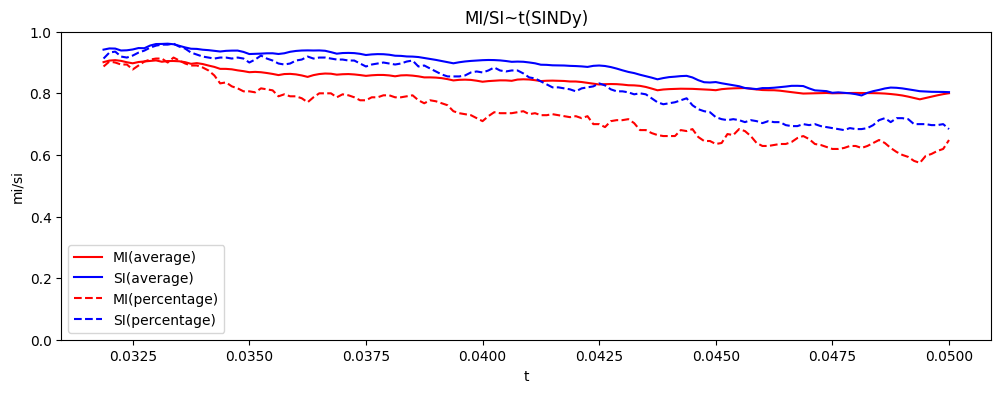

round: 52
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -511.506 1 + 271.399 Vx + -255.027 Vy + 24779.078 t + -15.645 VxVx + -54.707 VyVy + -297761.495 tt + -244.232 VxVy + -7459.656 Vxt + 5672.112 Vyt + -7.556 VxVxVy + 318.813 VxVxt + 1538.519 VyVyt + 5832.906 VxVyt + -632.345 Vx_2 + 944.838 Vy_2 + -666.984 Vx_1 + 1842.259 Vy_1 + 163.579 VxVx_2 + -1729.440 VxVy_2 + 30813.947 Vxt_2 + 1.980 VyVx_2 + 116.453 VyVy_2 + -369557.753 Vyt_2 + -839.573 tVx_2 + -6500.831 tVy_2 + 35907.332 tt_2 + 19.297 VxVxVx_2 + -645.658 VxVxVy_2 + -1653.733 VxVxt_2 + 20446.482 VyVyVx_2 + 1083.030 VyVyVy_2 + 0.627 VyVyt_2 + -50835.869 ttVx_2 + 440.756 ttVy_2 + -114.149 ttt_2 + 660828.609 VxVyVx_2 + -299.840 VxVyVy_2 + -24423.725 VxVyt_2 + 296.782 VxtVx_2 + -13.558 VxtVy_2 + -10366.216 Vxtt_2 + 3011.967 VytVx_2 + 6770.638 VytVy_2 + 55.688 VxVx_1 + 44.826 VxVy_1 + 28440.971 Vxt_1 + -132.175 VyVx_1 + -342.506 VyVy_1 + -317477.763 Vyt_1 + -321.998 tVx_1 + -4461.446 tVy_1 + 1734.392 tt_1 + 19.760 VxVxVx_1 + 2619.937 VxVxVy_

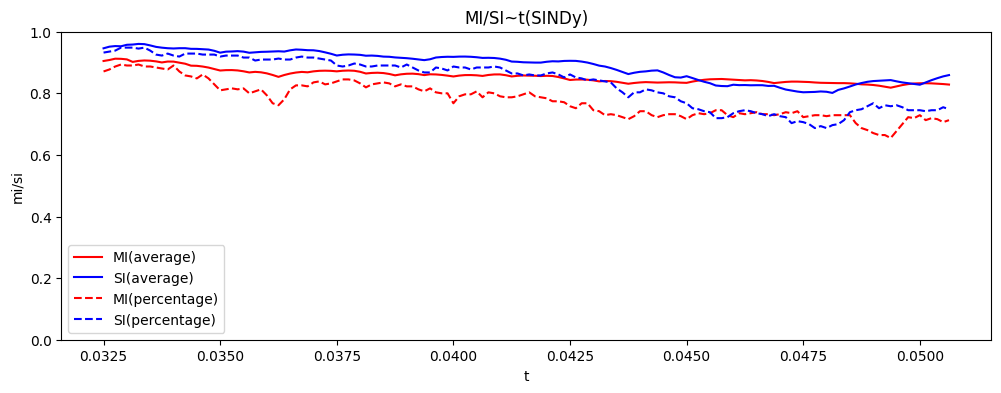

round: 53
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -244.424 1 + 138.093 Vx + -297.418 Vy + 11782.377 t + -94.092 VxVx + -3.649 VyVy + -140525.012 tt + -318.733 VxVy + -4079.650 Vxt + 6808.787 Vyt + -10.635 VxVxVy + 2283.530 VxVxt + 294.589 VyVyt + 7411.349 VxVyt + -1360.447 Vx_2 + -1200.343 Vy_2 + -146.399 Vx_1 + 197.255 Vy_1 + 83.542 VxVx_2 + -1648.161 VxVy_2 + 65051.359 Vxt_2 + 20.754 VyVx_2 + 516.059 VyVy_2 + -765061.911 Vyt_2 + -372.696 tVx_2 + -4233.403 tVy_2 + 32663.146 tt_2 + 1.963 VxVxVx_2 + -992.791 VxVxVy_2 + -10795.296 VxVxt_2 + 8108.125 VyVyVx_2 + 1403.565 VyVyVy_2 + 205.108 VyVyt_2 + 53451.804 ttVx_2 + 409.606 ttVy_2 + 24.045 ttt_2 + -585260.529 VxVyVx_2 + -271.782 VxVyVy_2 + -32610.010 VxVyt_2 + -5206.568 VxtVx_2 + -2.006 VxtVy_2 + -10264.711 Vxtt_2 + -470.430 VytVx_2 + 6098.496 VytVy_2 + -477.737 VxVx_1 + -258.635 VxVy_1 + 9143.909 Vxt_1 + -251.799 VyVx_1 + -461.510 VyVy_1 + -152521.643 Vyt_1 + -320.637 tVx_1 + 8344.950 tVy_1 + 8231.185 tt_1 + 7.131 VxVxVx_1 + 5460.533 VxVx

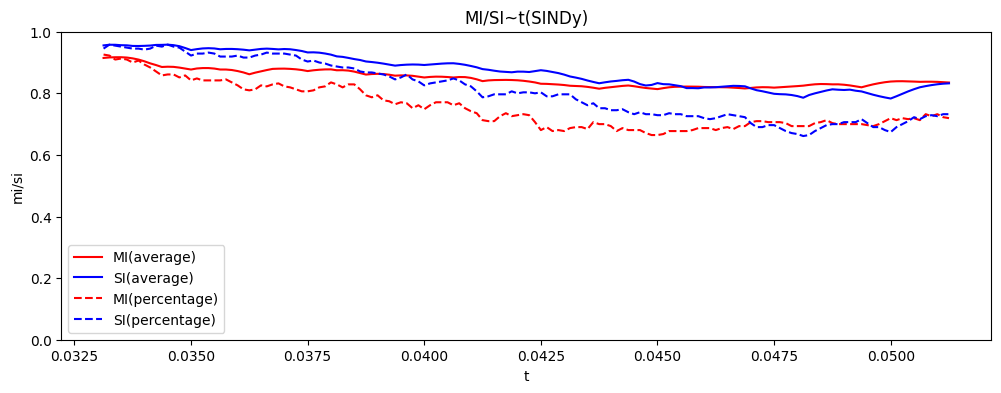

round: 54
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -97.948 1 + 130.305 Vx + -232.046 Vy + 4571.151 t + -78.489 VxVx + 0.561 VyVy + -53134.695 tt + -253.915 VxVy + -3871.489 Vxt + 5383.444 Vyt + -15.225 VxVxVy + 1914.264 VxVxt + 129.618 VyVyt + 5622.497 VxVyt + -546.282 Vx_2 + -934.558 Vy_2 + -1005.855 Vx_1 + -49.387 Vy_1 + -141.729 VxVx_2 + -1721.053 VxVy_2 + 25488.467 Vxt_2 + -46.026 VyVx_2 + 706.012 VyVy_2 + -290511.189 Vyt_2 + -163.647 tVx_2 + 927.490 tVy_2 + 34282.864 tt_2 + 1.617 VxVxVx_2 + 626.565 VxVxVy_2 + -15390.541 VxVxt_2 + 3077.231 VyVyVx_2 + 1147.771 VyVyVy_2 + 281.715 VyVyt_2 + 41698.768 ttVx_2 + -20.495 ttVy_2 + -153.988 ttt_2 + -459832.005 VxVyVx_2 + -603.089 VxVyVy_2 + -27107.356 VxVyt_2 + -6484.727 VxtVx_2 + -10.632 VxtVy_2 + 284.329 Vxtt_2 + 3625.301 VytVx_2 + 14477.433 VytVy_2 + -107.355 VxVx_1 + -211.713 VxVy_1 + 50003.482 Vxt_1 + -175.407 VyVx_1 + -392.098 VyVy_1 + -628541.030 Vyt_1 + -268.659 tVx_1 + -534.928 tVy_1 + 6947.327 tt_1 + -1.150 VxVxVx_1 + 3742.473 VxVxVy

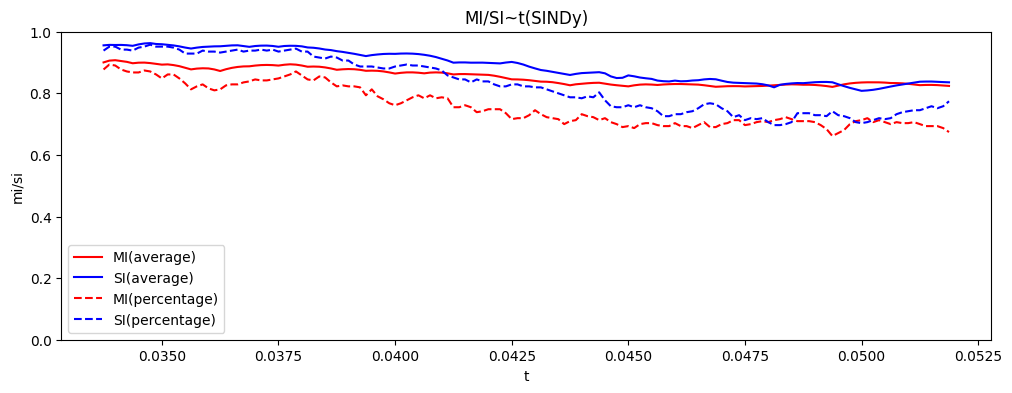

round: 55
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 102.679 1 + 26.556 Vx + -247.819 Vy + -4219.753 t + -76.214 VxVx + -6.784 VyVy + 42353.032 tt + -176.583 VxVy + -1288.003 Vxt + 5649.787 Vyt + -7.515 VxVxVy + 1834.050 VxVxt + 293.985 VyVyt + 4076.017 VxVyt + -1116.042 Vx_2 + 341.322 Vy_2 + -590.436 Vx_1 + 352.099 Vy_1 + 137.838 VxVx_2 + -2183.188 VxVy_2 + 54722.401 Vxt_2 + 14.776 VyVx_2 + 500.190 VyVy_2 + -654264.629 Vyt_2 + -673.886 tVx_2 + -4950.043 tVy_2 + 45133.288 tt_2 + 10.169 VxVxVx_2 + -722.318 VxVxVy_2 + -10006.931 VxVxt_2 + 15699.930 VyVyVx_2 + 1239.261 VyVyVy_2 + 98.002 VyVyt_2 + -14869.737 ttVx_2 + 286.186 ttVy_2 + -137.573 ttt_2 + 162092.214 VxVyVx_2 + -407.484 VxVyVy_2 + -28432.312 VxVyt_2 + -2500.426 VxtVx_2 + -8.221 VxtVy_2 + -7137.131 Vxtt_2 + 3171.754 VytVx_2 + 9177.662 VytVy_2 + 44.306 VxVx_1 + -593.299 VxVy_1 + 28132.387 Vxt_1 + -137.723 VyVx_1 + -195.363 VyVy_1 + -349522.334 Vyt_1 + -528.929 tVx_1 + -3952.270 tVy_1 + 15439.409 tt_1 + -6.957 VxVxVx_1 + 2934.870 VxVxVy

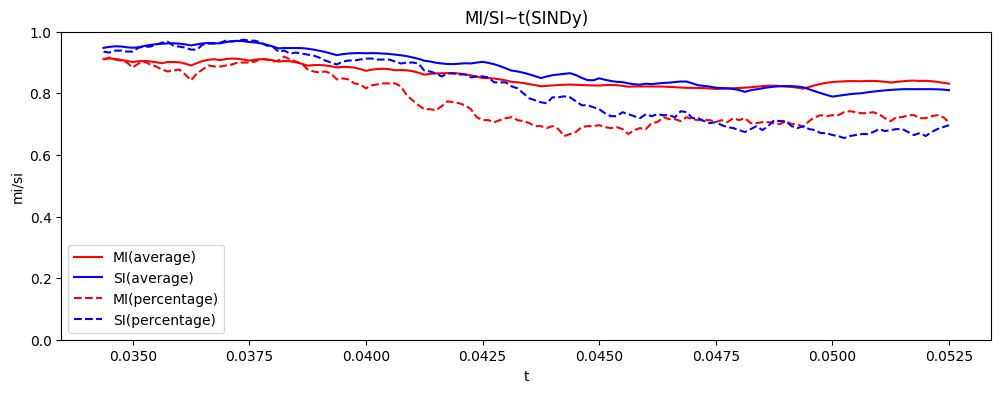

round: 56
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -209.763 1 + -71.330 Vx + -179.962 Vy + 9879.144 t + -112.360 VxVx + -27.473 VyVy + -114403.190 tt + -146.127 VxVy + 906.799 Vxt + 4283.730 Vyt + -9.737 VxVxVy + 2558.514 VxVxt + 631.758 VyVyt + 3147.192 VxVyt + -1253.182 Vx_2 + 3151.891 Vy_2 + 867.558 Vx_1 + 1358.731 Vy_1 + 116.234 VxVx_2 + -2084.036 VxVy_2 + 59763.610 Vxt_2 + 20.011 VyVx_2 + 611.471 VyVy_2 + -699561.775 Vyt_2 + -481.842 tVx_2 + -4655.477 tVy_2 + 42334.243 tt_2 + 17.475 VxVxVx_2 + -898.628 VxVxVy_2 + -12502.648 VxVxt_2 + 11431.197 VyVyVx_2 + 1258.417 VyVyVy_2 + 405.339 VyVyt_2 + -145109.930 ttVx_2 + 103.978 ttVy_2 + -109.585 ttt_2 + 1649320.920 VxVyVx_2 + -553.630 VxVyVy_2 + -27884.385 VxVyt_2 + -9043.731 VxtVx_2 + -44.068 VxtVy_2 + -1848.984 Vxtt_2 + 2307.520 VytVx_2 + 11564.330 VytVy_2 + -258.638 VxVx_1 + -122.623 VxVy_1 + -39245.567 Vxt_1 + -265.782 VyVx_1 + -619.577 VyVy_1 + 422418.779 Vyt_1 + -481.801 tVx_1 + 2656.449 tVy_1 + 5711.958 tt_1 + -0.107 VxVxVx_1 + 5713.2

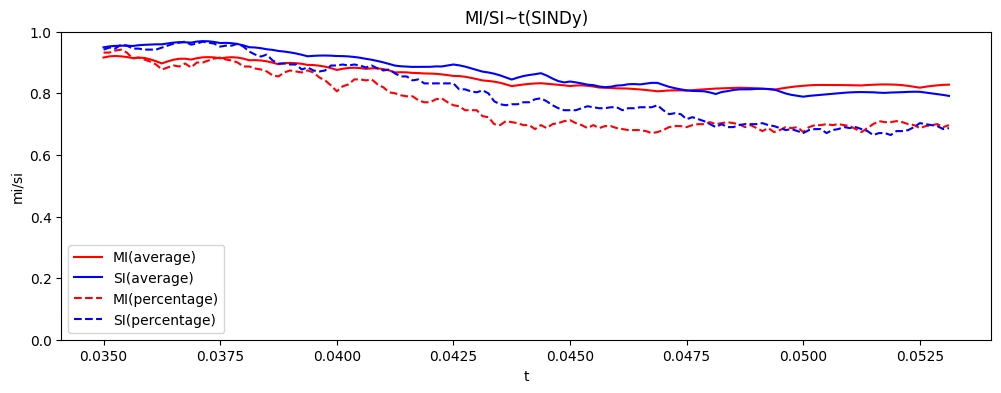

round: 57
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -236.054 1 + 73.860 Vx + -117.588 Vy + 10136.794 t + -69.512 VxVx + -38.869 VyVy + -107079.760 tt + -239.606 VxVy + -2340.822 Vxt + 2843.117 Vyt + -12.126 VxVxVy + 1637.518 VxVxt + 934.491 VyVyt + 5255.359 VxVyt + -309.969 Vx_2 + 2622.477 Vy_2 + -488.667 Vx_1 + 1413.854 Vy_1 + 21.478 VxVx_2 + -2279.667 VxVy_2 + 14235.505 Vxt_2 + 16.600 VyVx_2 + 844.836 VyVy_2 + -157178.784 Vyt_2 + -430.957 tVx_2 + -2052.415 tVy_2 + 45972.168 tt_2 + 14.368 VxVxVx_2 + -640.021 VxVxVy_2 + -17841.171 VxVxt_2 + 9604.518 VyVyVx_2 + 1515.252 VyVyVy_2 + 347.446 VyVyt_2 + -120919.162 ttVx_2 + -36.783 ttVy_2 + -80.365 ttt_2 + 1374861.572 VxVyVx_2 + -814.638 VxVyVy_2 + -33956.303 VxVyt_2 + -8030.292 VxtVx_2 + -18.903 VxtVy_2 + 1011.261 Vxtt_2 + 1807.705 VytVx_2 + 18078.054 VytVy_2 + -821.263 VxVx_1 + -456.651 VxVy_1 + 22942.895 Vxt_1 + -355.389 VyVx_1 + -287.038 VyVy_1 + -282991.385 Vyt_1 + -213.367 tVx_1 + 15912.999 tVy_1 + 12267.493 tt_1 + 4.844 VxVxVx_1 + 7538.31

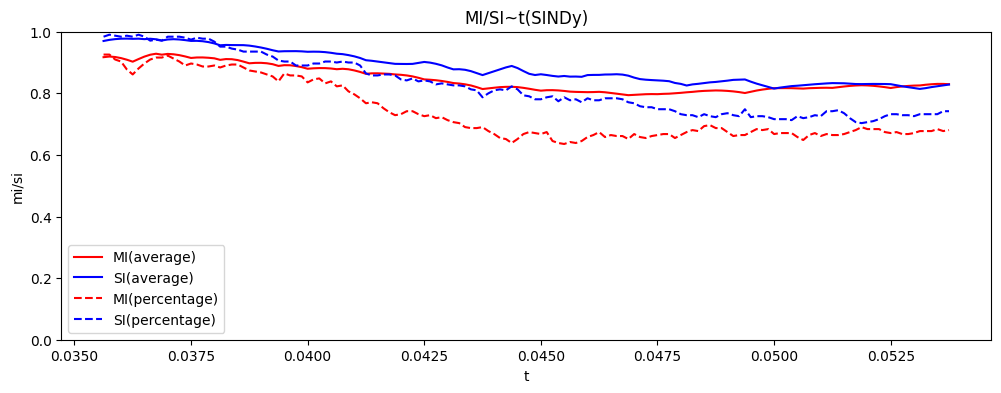

round: 58
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -110.786 1 + -200.767 Vx + -76.855 Vy + 5618.637 t + -90.850 VxVx + -64.571 VyVy + -68903.909 tt + -50.738 VxVy + 3647.294 Vxt + 2045.786 Vyt + -11.831 VxVxVy + 1964.690 VxVxt + 1388.433 VyVyt + 968.054 VxVyt + 152.111 Vx_2 + 1957.624 Vy_2 + 93.582 Vx_1 + 929.819 Vy_1 + 59.443 VxVx_2 + -1882.540 VxVy_2 + -6539.095 Vxt_2 + 66.814 VyVx_2 + 483.169 VyVy_2 + 70835.566 Vyt_2 + -502.745 tVx_2 + -2731.118 tVy_2 + 37547.719 tt_2 + 7.824 VxVxVx_2 + -1759.075 VxVxVy_2 + -9568.573 VxVxt_2 + 10938.858 VyVyVx_2 + 837.121 VyVyVy_2 + 5.982 VyVyt_2 + -90994.732 ttVx_2 + 163.891 ttVy_2 + -176.436 ttt_2 + 1043552.637 VxVyVx_2 + -515.102 VxVyVy_2 + -17772.408 VxVyt_2 + -359.043 VxtVx_2 + -24.368 VxtVy_2 + -3258.305 Vxtt_2 + 3767.496 VytVx_2 + 10563.624 VytVy_2 + -548.625 VxVx_1 + -607.773 VxVy_1 + -7631.510 Vxt_1 + -222.532 VyVx_1 + -148.673 VyVy_1 + 102782.788 Vyt_1 + -382.173 tVx_1 + 9094.639 tVy_1 + 15065.288 tt_1 + 15.615 VxVxVx_1 + 4370.700 VxVxVy_1 + 

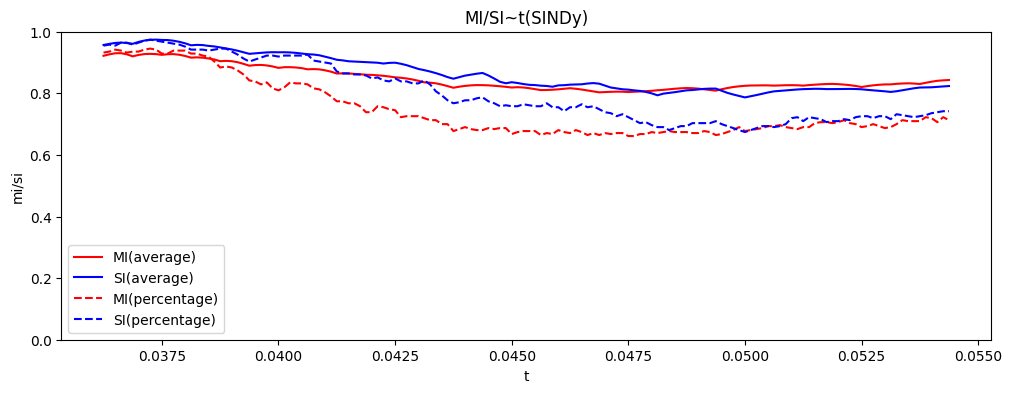

round: 59
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -163.135 1 + -18.491 Vx + -57.300 Vy + 6997.002 t + -100.955 VxVx + -75.305 VyVy + -74155.835 tt + -213.624 VxVy + -82.547 Vxt + 1595.270 Vyt + -10.261 VxVxVy + 2285.852 VxVxt + 1575.736 VyVyt + 4482.017 VxVyt + 827.025 Vx_2 + 3980.742 Vy_2 + 551.698 Vx_1 + 462.402 Vy_1 + -513.366 VxVx_2 + -1705.617 VxVy_2 + -36916.484 Vxt_2 + -127.343 VyVx_2 + 834.076 VyVy_2 + 408821.171 Vyt_2 + 66.414 tVx_2 + 9644.650 tVy_2 + 33435.739 tt_2 + 9.690 VxVxVx_2 + 2468.251 VxVxVy_2 + -16892.410 VxVxt_2 + -1080.386 VyVyVx_2 + 1330.864 VyVyVy_2 + 450.007 VyVyt_2 + -179625.188 ttVx_2 + -55.688 ttVy_2 + 23.652 ttt_2 + 1998099.287 VxVyVx_2 + -476.005 VxVyVy_2 + -28535.945 VxVyt_2 + -9676.108 VxtVx_2 + -19.829 VxtVy_2 + 1330.441 Vxtt_2 + -209.469 VytVx_2 + 10173.530 VytVy_2 + -964.204 VxVx_1 + 4.696 VxVy_1 + -27239.957 Vxt_1 + -267.557 VyVx_1 + -25.830 VyVy_1 + 311682.698 Vyt_1 + 505.783 tVx_1 + 17875.950 tVy_1 + 1884.694 tt_1 + 16.011 VxVxVx_1 + 5148.100 VxVxVy_1

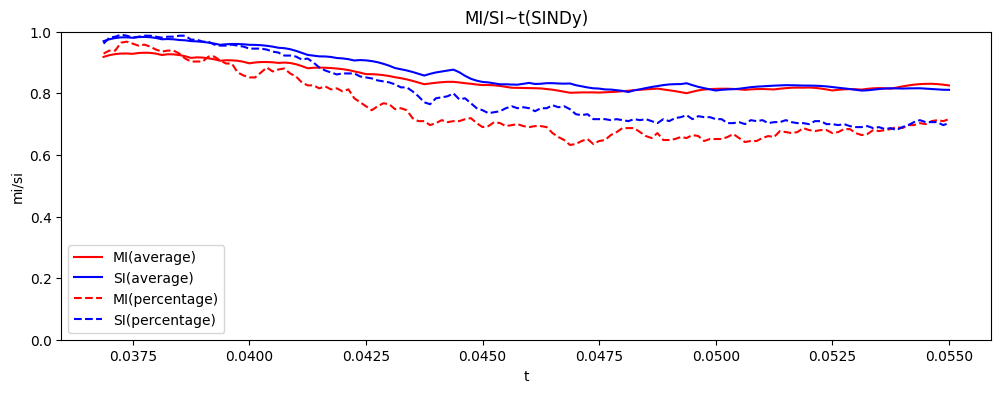

round: 60
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -56.884 1 + -243.107 Vx + -66.821 Vy + 2921.152 t + -56.612 VxVx + -105.752 VyVy + -35707.129 tt + -45.414 VxVy + 4752.010 Vxt + 1974.403 Vyt + -13.661 VxVxVy + 1373.679 VxVxt + 2178.773 VyVyt + 888.214 VxVyt + -427.167 Vx_2 + 931.993 Vy_2 + 983.728 Vx_1 + 1733.556 Vy_1 + -720.145 VxVx_2 + -1346.244 VxVy_2 + 16948.476 Vxt_2 + -177.419 VyVx_2 + 884.806 VyVy_2 + -165397.504 Vyt_2 + 239.773 tVx_2 + 14222.705 tVy_2 + 24699.654 tt_2 + 15.625 VxVxVx_2 + 3583.395 VxVxVy_2 + -17644.452 VxVxt_2 + -4912.337 VyVyVx_2 + 602.629 VyVyVy_2 + 73.426 VyVyt_2 + -46181.722 ttVx_2 + -370.702 ttVy_2 + -96.777 ttt_2 + 556700.475 VxVyVx_2 + -808.475 VxVyVy_2 + -12162.506 VxVyt_2 + -1926.918 VxtVx_2 + -14.842 VxtVy_2 + 8134.189 Vxtt_2 + 2023.523 VytVx_2 + 16371.422 VytVy_2 + -413.308 VxVx_1 + -138.502 VxVy_1 + -45914.958 Vxt_1 + -116.947 VyVx_1 + -225.745 VyVy_1 + 511656.918 Vyt_1 + 53.954 tVx_1 + 6809.571 tVy_1 + 5041.541 tt_1 + 14.410 VxVxVx_1 + 2201.658 VxVxV

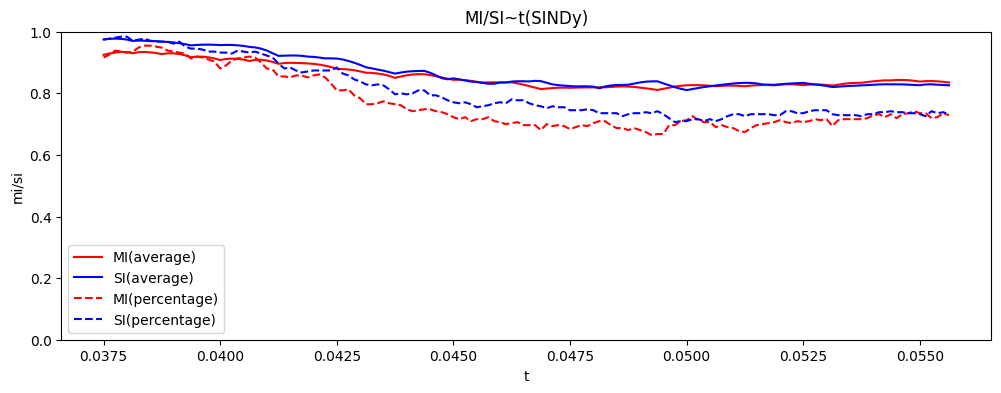

round: 61
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -229.596 1 + -400.305 Vx + -94.528 Vy + 9708.639 t + -134.042 VxVx + -124.471 VyVy + -101239.363 tt + -127.841 VxVy + 8190.072 Vxt + 2543.945 Vyt + -17.183 VxVxVy + 3110.150 VxVxt + 2481.791 VyVyt + 2450.050 VxVyt + -1905.744 Vx_2 + 4168.130 Vy_2 + 2197.149 Vx_1 + 1411.757 Vy_1 + -584.260 VxVx_2 + -1704.660 VxVy_2 + 80110.282 Vxt_2 + -109.967 VyVx_2 + 1091.736 VyVy_2 + -833150.472 Vyt_2 + 455.751 tVx_2 + 10444.024 tVy_2 + 31119.593 tt_2 + 26.059 VxVxVx_2 + 1873.776 VxVxVy_2 + -21579.460 VxVxt_2 + -8949.202 VyVyVx_2 + 806.265 VyVyVy_2 + 281.258 VyVyt_2 + -180596.518 ttVx_2 + -498.464 ttVy_2 + 91.565 ttt_2 + 1937101.940 VxVyVx_2 + -642.221 VxVyVy_2 + -15442.221 VxVyt_2 + -6167.112 VxtVx_2 + -10.946 VxtVy_2 + 11140.855 Vxtt_2 + -1687.755 VytVx_2 + 13160.117 VytVy_2 + -751.845 VxVx_1 + -8.654 VxVy_1 + -99560.931 Vxt_1 + -202.529 VyVx_1 + -71.496 VyVy_1 + 1097421.771 Vyt_1 + 274.697 tVx_1 + 13073.183 tVy_1 + 1858.377 tt_1 + 29.611 VxVxVx_1 + 3

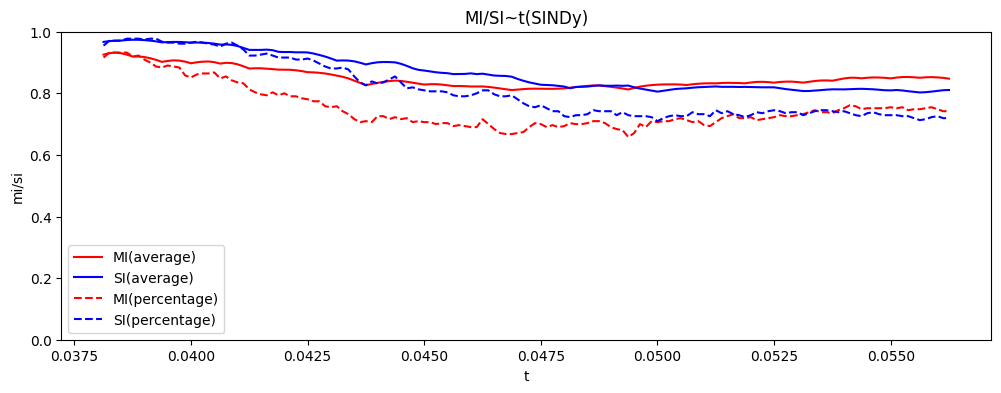

round: 62
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 37.744 1 + -378.996 Vx + -146.459 Vy + -1861.345 t + -149.950 VxVx + -97.833 VyVy + 22748.400 tt + -181.015 VxVy + 7613.013 Vxt + 3616.133 Vyt + -14.746 VxVxVy + 3364.803 VxVxt + 1996.685 VyVyt + 3680.976 VxVyt + 301.053 Vx_2 + 778.255 Vy_2 + 7.455 Vx_1 + 945.100 Vy_1 + -689.663 VxVx_2 + -1124.506 VxVy_2 + -15958.691 Vxt_2 + -106.500 VyVx_2 + 919.923 VyVy_2 + 202432.957 Vyt_2 + 715.271 tVx_2 + 12895.224 tVy_2 + 20265.243 tt_2 + 32.392 VxVxVx_2 + 1782.196 VxVxVy_2 + -17841.059 VxVxt_2 + -13599.808 VyVyVx_2 + 738.829 VyVyVy_2 + 150.000 VyVyt_2 + -35870.211 ttVx_2 + -447.203 ttVy_2 + 122.044 ttt_2 + 409513.253 VxVyVx_2 + -463.423 VxVyVy_2 + -14932.320 VxVyt_2 + -3418.493 VxtVx_2 + -7.995 VxtVy_2 + 9616.645 Vxtt_2 + -2219.618 VytVx_2 + 9606.513 VytVy_2 + -983.611 VxVx_1 + -71.127 VxVy_1 + -6988.025 Vxt_1 + -264.473 VyVx_1 + -31.084 VyVy_1 + 124563.009 Vyt_1 + 476.662 tVx_1 + 18169.538 tVy_1 + 3037.054 tt_1 + 12.900 VxVxVx_1 + 5194.211 VxVxVy_

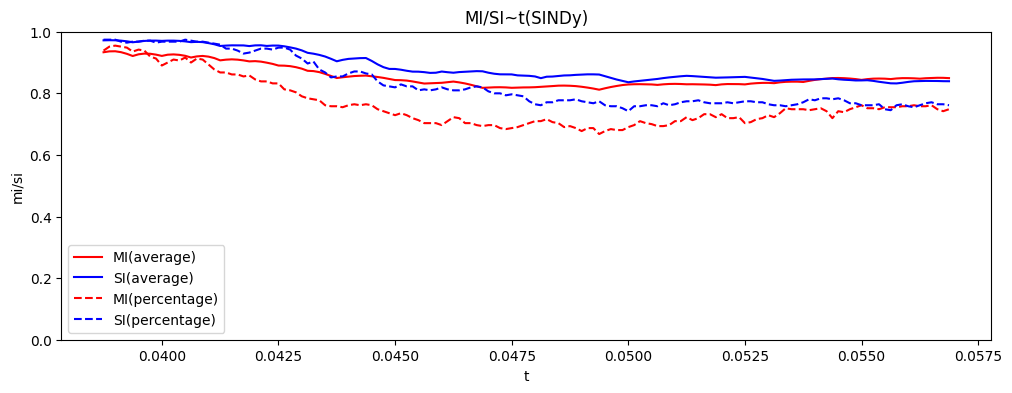

round: 63
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -302.862 1 + -178.564 Vx + 30.879 Vy + 11883.315 t + -73.629 VxVx + -53.818 VyVy + -114621.286 tt + -107.522 VxVy + 3533.945 Vxt + 27.520 Vyt + -13.234 VxVxVy + 1756.553 VxVxt + 1033.683 VyVyt + 2147.602 VxVyt + -936.733 Vx_2 + 1219.406 Vy_2 + -343.556 Vx_1 + 867.971 Vy_1 + -460.187 VxVx_2 + -1086.190 VxVy_2 + 32947.217 Vxt_2 + -33.256 VyVx_2 + 831.009 VyVy_2 + -275048.241 Vyt_2 + 566.831 tVx_2 + 8591.448 tVy_2 + 19435.817 tt_2 + 34.277 VxVxVx_2 + 467.183 VxVxVy_2 + -15634.666 VxVxt_2 + -10007.707 VyVyVx_2 + 362.402 VyVyVy_2 + 110.197 VyVyt_2 + -53586.489 ttVx_2 + -634.196 ttVy_2 + 98.650 ttt_2 + 583078.016 VxVyVx_2 + -546.506 VxVyVy_2 + -6676.520 VxVyt_2 + -2657.071 VxtVx_2 + -9.164 VxtVy_2 + 13372.624 Vxtt_2 + -1837.397 VytVx_2 + 10627.971 VytVy_2 + -730.847 VxVx_1 + -74.637 VxVy_1 + 13144.083 Vxt_1 + -205.671 VyVx_1 + 49.506 VyVy_1 + -139425.774 Vyt_1 + 851.416 tVx_1 + 12260.235 tVy_1 + 3060.264 tt_1 + 29.309 VxVxVx_1 + 3358.923 VxVxVy

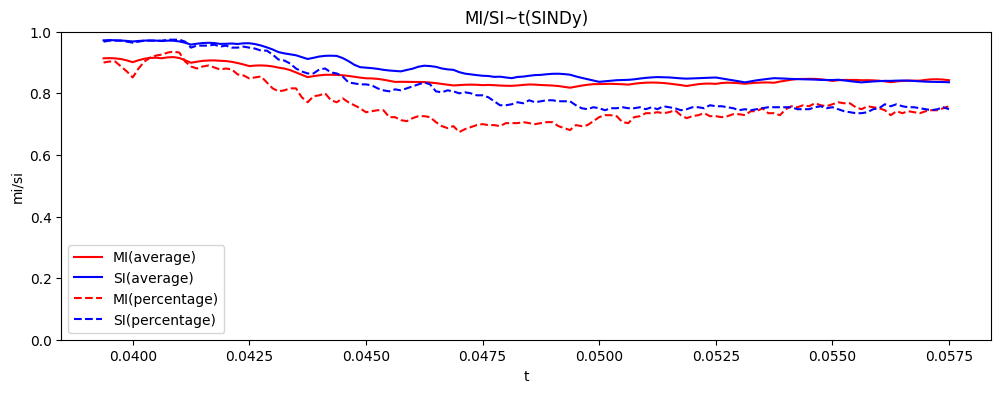

round: 64
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -102.023 1 + -277.361 Vx + 5.856 Vy + 3324.854 t + -147.849 VxVx + -76.482 VyVy + -24588.928 tt + -69.141 VxVy + 5360.373 Vxt + 335.233 Vyt + -13.462 VxVxVy + 3257.227 VxVxt + 1434.584 VyVyt + 1093.235 VxVyt + -605.499 Vx_2 + 475.949 Vy_2 + 737.110 Vx_1 + 594.684 Vy_1 + -803.089 VxVx_2 + -1695.773 VxVy_2 + 19048.389 Vxt_2 + -163.397 VyVx_2 + 466.041 VyVy_2 + -130227.453 Vyt_2 + -103.948 tVx_2 + 14542.281 tVy_2 + 31895.209 tt_2 + 28.128 VxVxVx_2 + 2767.863 VxVxVy_2 + -8648.096 VxVxt_2 + 3482.120 VyVyVx_2 + 659.596 VyVyVy_2 + -21.935 VyVyt_2 + -24581.796 ttVx_2 + 19.463 ttVy_2 + 56.976 ttt_2 + 302614.319 VxVyVx_2 + -177.633 VxVyVy_2 + -13962.320 VxVyt_2 + -114.879 VxtVx_2 + -16.521 VxtVy_2 + -722.253 Vxtt_2 + -1127.904 VytVx_2 + 2976.547 VytVy_2 + -1031.779 VxVx_1 + -279.025 VxVy_1 + -33591.058 Vxt_1 + -233.689 VyVx_1 + 36.657 VyVy_1 + 362146.680 Vyt_1 + 813.274 tVx_1 + 18807.130 tVy_1 + 7164.030 tt_1 + 16.323 VxVxVx_1 + 4435.363 VxVxVy_1 +

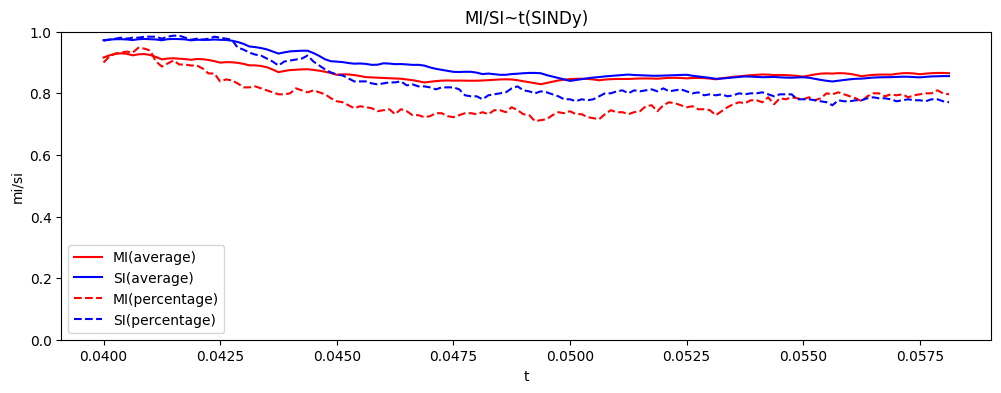

round: 65
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 219.979 1 + -135.353 Vx + 95.457 Vy + -9040.099 t + -13.329 VxVx + -0.153 VyVy + 93181.377 tt + 110.313 VxVy + 2487.552 Vxt + -1396.482 Vyt + -9.719 VxVxVy + 559.832 VxVxt + 1.489 VyVyt + -2147.130 VxVyt + 2296.790 Vx_2 + 2249.317 Vy_2 + 2189.976 Vx_1 + 2140.179 Vy_1 + -860.595 VxVx_2 + -1063.899 VxVy_2 + -95226.878 Vxt_2 + -263.705 VyVx_2 + 672.798 VyVy_2 + 987453.886 Vyt_2 + 88.932 tVx_2 + 16542.743 tVy_2 + 19102.453 tt_2 + 35.436 VxVxVx_2 + 5137.793 VxVxVy_2 + -12812.321 VxVxt_2 + -60.212 VyVyVx_2 + 744.268 VyVyVy_2 + 80.201 VyVyt_2 + -87917.928 ttVx_2 + -52.478 ttVy_2 + 105.897 ttt_2 + 855985.116 VxVyVx_2 + -364.985 VxVyVy_2 + -15686.754 VxVyt_2 + -2112.034 VxtVx_2 + -18.744 VxtVy_2 + 806.111 Vxtt_2 + -1991.874 VytVx_2 + 6930.659 VytVy_2 + -1042.895 VxVx_1 + -60.370 VxVy_1 + -92294.263 Vxt_1 + -403.296 VyVx_1 + -12.675 VyVy_1 + 945723.168 Vyt_1 + 368.357 tVx_1 + 19351.896 tVy_1 + 3544.528 tt_1 + 14.237 VxVxVx_1 + 7970.900 VxVxVy_1 + 1

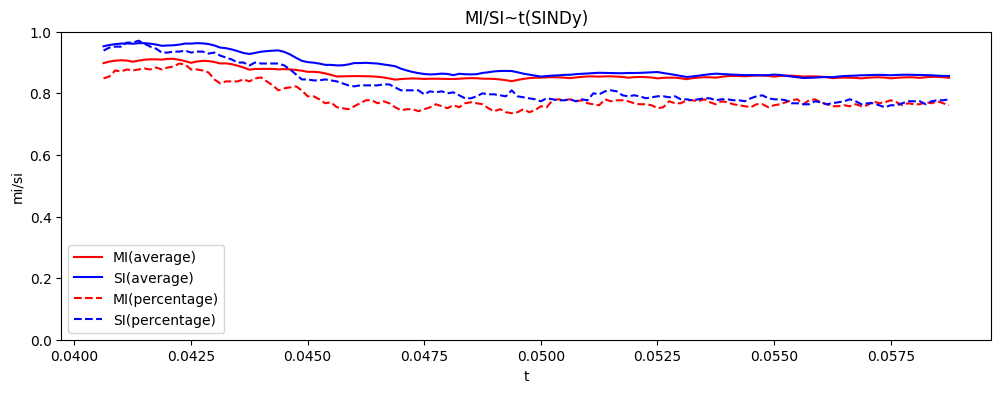

round: 66
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 81.501 1 + -295.966 Vx + 65.875 Vy + -3689.142 t + -105.227 VxVx + -60.113 VyVy + 41081.391 tt + 46.207 VxVy + 5738.089 Vxt + -837.991 Vyt + -13.051 VxVxVy + 2517.659 VxVxt + 1109.152 VyVyt + -1067.405 VxVyt + 252.017 Vx_2 + -1710.027 Vy_2 + -1322.943 Vx_1 + 450.388 Vy_1 + 15.435 VxVx_2 + -1101.220 VxVy_2 + -13221.348 Vxt_2 + 146.124 VyVx_2 + 654.972 VyVy_2 + 169798.258 Vyt_2 + 149.285 tVx_2 + -1800.278 tVy_2 + 20177.184 tt_2 + 37.356 VxVxVx_2 + -3442.111 VxVxVy_2 + -11913.863 VxVxt_2 + -556.669 VyVyVx_2 + 1395.510 VyVyVy_2 + 83.281 VyVyt_2 + 70639.803 ttVx_2 + 289.444 ttVy_2 + 75.424 ttt_2 + -716361.378 VxVyVx_2 + -349.925 VxVyVy_2 + -28967.945 VxVyt_2 + -1921.315 VxtVx_2 + 0.001 VxtVy_2 + -7100.915 Vxtt_2 + -1287.440 VytVx_2 + 6732.042 VytVy_2 + -913.242 VxVx_1 + -223.629 VxVy_1 + 47594.036 Vxt_1 + -216.995 VyVx_1 + 283.702 VyVy_1 + -433714.527 Vyt_1 + 913.184 tVx_1 + 15778.199 tVy_1 + 5967.090 tt_1 + 34.355 VxVxVx_1 + 3761.176 VxVxVy_1

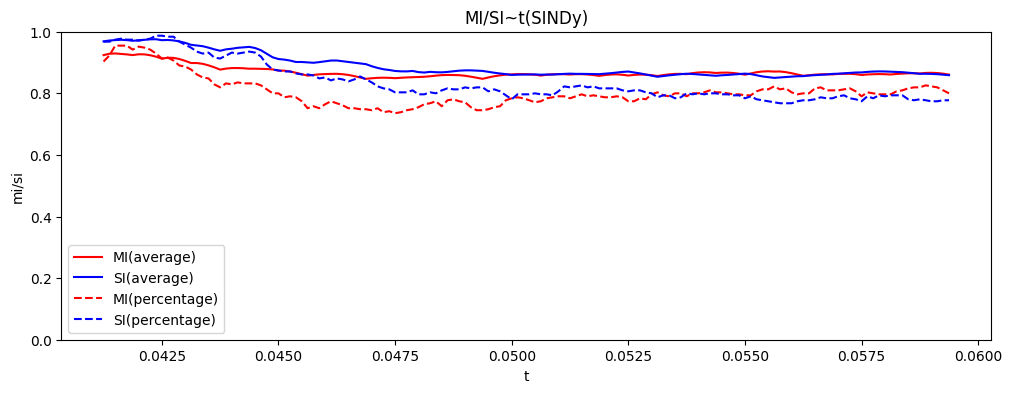

round: 67
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 41.105 1 + -300.840 Vx + 164.679 Vy + -2383.554 t + -95.825 VxVx + -63.512 VyVy + 31169.177 tt + 100.357 VxVy + 5800.088 Vxt + -2699.525 Vyt + -13.226 VxVxVy + 2284.861 VxVxt + 1216.648 VyVyt + -2125.995 VxVyt + -622.733 Vx_2 + -300.995 Vy_2 + 2096.284 Vx_1 + 1921.754 Vy_1 + -490.013 VxVx_2 + -949.136 VxVy_2 + 21932.893 Vxt_2 + -52.568 VyVx_2 + 528.213 VyVy_2 + -182673.663 Vyt_2 + 168.762 tVx_2 + 8649.223 tVy_2 + 17071.036 tt_2 + 30.179 VxVxVx_2 + 797.825 VxVxVy_2 + -10102.935 VxVxt_2 + -1695.391 VyVyVx_2 + 109.198 VyVyVy_2 + 9.402 VyVyt_2 + 10886.022 ttVx_2 + -117.006 ttVy_2 + 64.268 ttt_2 + -95504.958 VxVyVx_2 + -146.075 VxVyVy_2 + -2783.299 VxVyt_2 + -500.611 VxtVx_2 + -38.687 VxtVy_2 + 2240.339 Vxtt_2 + -1289.640 VytVx_2 + 2109.951 VytVy_2 + -821.303 VxVx_1 + 344.376 VxVy_1 + -90534.735 Vxt_1 + -111.366 VyVx_1 + 218.580 VyVy_1 + 948717.596 Vyt_1 + 1012.759 tVx_1 + 14766.334 tVy_1 + -4757.054 tt_1 + 0.065 VxVxVx_1 + 2262.474 VxVxVy_1 +

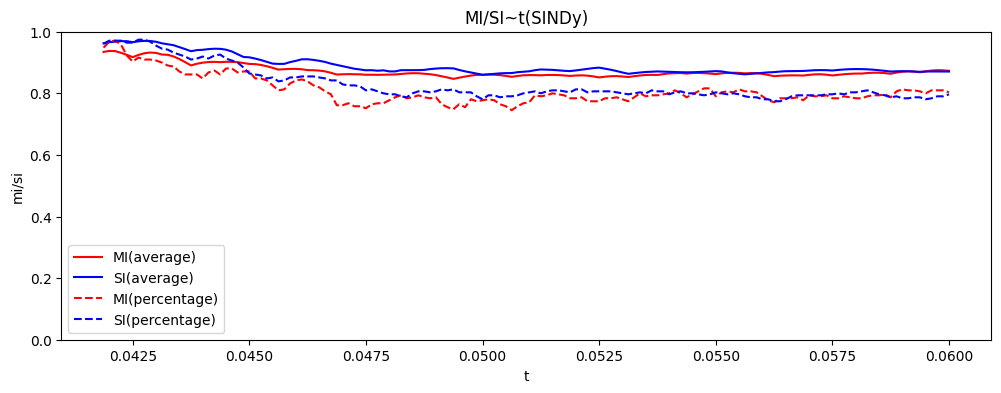

round: 68
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 797.211 1 + -85.833 Vx + 261.220 Vy + -31471.700 t + -23.806 VxVx + 30.610 VyVy + 308711.034 tt + 178.543 VxVy + 1687.078 Vxt + -4450.213 Vyt + -10.728 VxVxVy + 838.245 VxVxt + -512.883 VyVyt + -3442.082 VxVyt + 3031.128 Vx_2 + -525.729 Vy_2 + 1133.866 Vx_1 + 1207.435 Vy_1 + -661.869 VxVx_2 + -1568.690 VxVy_2 + -121909.533 Vxt_2 + -191.946 VyVx_2 + 456.155 VyVy_2 + 1220831.372 Vyt_2 + -234.663 tVx_2 + 11525.957 tVy_2 + 28773.479 tt_2 + 30.474 VxVxVx_2 + 3325.852 VxVxVy_2 + -8767.372 VxVxt_2 + 5839.947 VyVyVx_2 + 1122.719 VyVyVy_2 + 87.483 VyVyt_2 + 20348.403 ttVx_2 + 240.716 ttVy_2 + 31.908 ttt_2 + -189912.985 VxVyVx_2 + -141.971 VxVyVy_2 + -21967.888 VxVyt_2 + -2021.401 VxtVx_2 + -29.079 VxtVy_2 + -4570.102 Vxtt_2 + -652.995 VytVx_2 + 2209.894 VytVy_2 + -843.284 VxVx_1 + -268.590 VxVy_1 + -53204.989 Vxt_1 + -23.629 VyVx_1 + 222.766 VyVy_1 + 590214.930 Vyt_1 + 1161.856 tVx_1 + 14689.329 tVy_1 + 7219.338 tt_1 + 15.448 VxVxVx_1 + 276.686 Vx

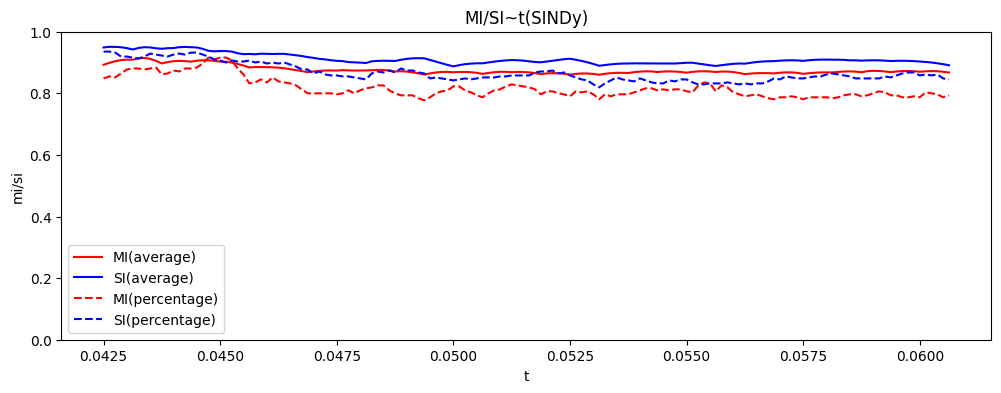

round: 69
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 504.424 1 + -157.246 Vx + 141.282 Vy + -20247.053 t + -64.335 VxVx + -23.902 VyVy + 201893.995 tt + 43.922 VxVy + 3101.942 Vxt + -2163.491 Vyt + -9.442 VxVxVy + 1647.114 VxVxt + 554.007 VyVyt + -746.196 VxVyt + 1861.240 Vx_2 + -2215.963 Vy_2 + -1110.732 Vx_1 + -382.638 Vy_1 + -220.405 VxVx_2 + -333.416 VxVy_2 + -71720.978 Vxt_2 + -45.353 VyVx_2 + 693696.964 Vyt_2 + 33.301 tVx_2 + 3568.217 tVy_2 + 5182.040 tt_2 + 2.991 VxVxVx_2 + 661.195 VxVxVy_2 + -600.508 VxVxt_2 + -1137.050 VyVyVx_2 + 32.121 VyVyVy_2 + 122.728 VyVyt_2 + 83796.012 ttVx_2 + -235.552 ttVy_2 + 29.045 ttt_2 + -780861.079 VxVyVx_2 + 75.767 VxVyVy_2 + -436.719 VxVyt_2 + -2248.034 VxtVx_2 + -39.540 VxtVy_2 + 5294.679 Vxtt_2 + -506.242 VytVx_2 + -1548.794 VytVy_2 + -621.605 VxVx_1 + 239.936 VxVy_1 + 31733.305 Vxt_1 + 46.003 VyVx_1 + 410.749 VyVy_1 + -207799.059 Vyt_1 + 1181.908 tVx_1 + 10321.296 tVy_1 + -3014.259 tt_1 + 4.554 VxVxVx_1 + -982.563 VxVxVy_1 + -7183.164 VxVxt_1 + -2

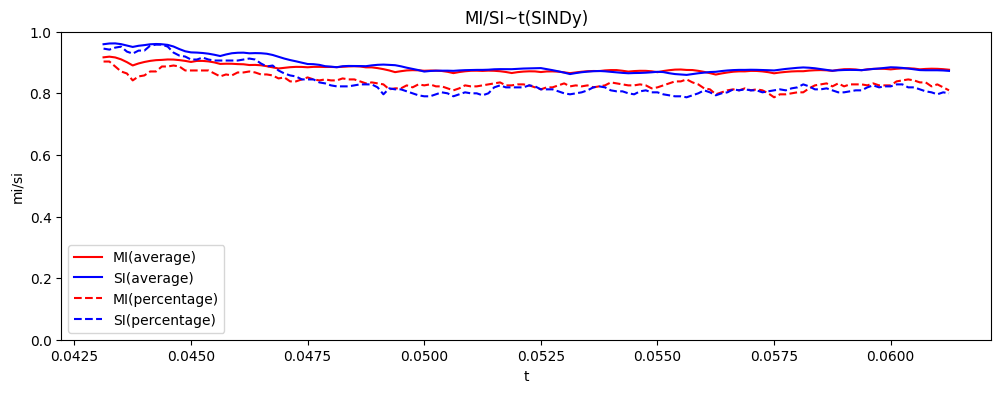

round: 70
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -107.307 1 + -123.461 Vx + 159.566 Vy + 3342.618 t + 31.447 VxVx + -57.495 VyVy + -23310.048 tt + 78.182 VxVy + 2265.694 Vxt + -2621.571 Vyt + -9.438 VxVxVy + -200.865 VxVxt + 1092.320 VyVyt + -1428.170 VxVyt + 2093.200 Vx_2 + -2296.517 Vy_2 + 115.699 Vx_1 + 1220.512 Vy_1 + -533.508 VxVx_2 + -624.450 VxVy_2 + -82032.986 Vxt_2 + -93.582 VyVx_2 + 515.344 VyVy_2 + 804687.465 Vyt_2 + 191.755 tVx_2 + 8643.118 tVy_2 + 10952.856 tt_2 + 26.367 VxVxVx_2 + 1176.256 VxVxVy_2 + -9680.534 VxVxt_2 + -2393.147 VyVyVx_2 + 202.222 VyVyVy_2 + -97.473 VyVyt_2 + 87438.914 ttVx_2 + -370.072 ttVy_2 + -36.530 ttt_2 + -820304.704 VxVyVx_2 + -540.591 VxVyVy_2 + -4430.893 VxVyt_2 + 1607.874 VxtVx_2 + -27.341 VxtVy_2 + 6882.791 Vxtt_2 + 651.470 VytVx_2 + 9745.817 VytVy_2 + -599.903 VxVx_1 + 418.762 VxVy_1 + -13021.278 Vxt_1 + 27.966 VyVx_1 + 318.331 VyVy_1 + 198022.255 Vyt_1 + 849.437 tVx_1 + 10568.653 tVy_1 + -6184.201 tt_1 + -5.235 VxVxVx_1 + -177.242 VxVxVy_1 + 

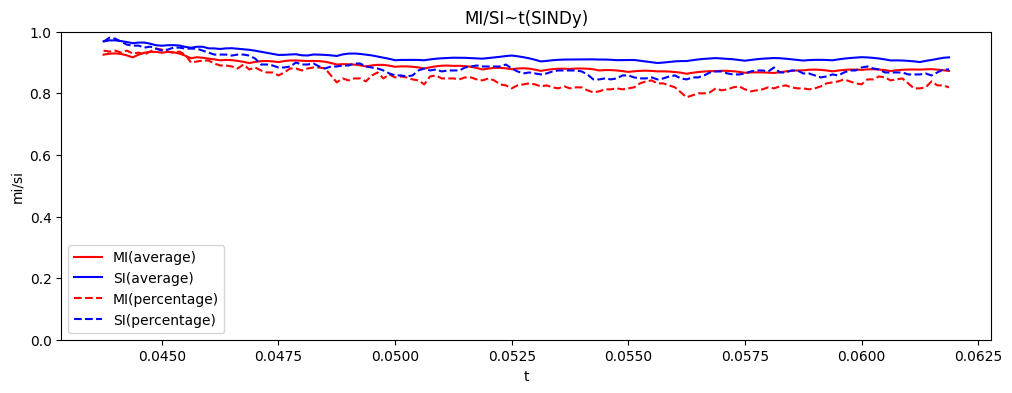

round: 71
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 195.445 1 + -137.953 Vx + 131.591 Vy + -8115.610 t + -27.426 VxVx + -30.612 VyVy + 84571.807 tt + 41.530 VxVy + 2462.970 Vxt + -2018.195 Vyt + -12.902 VxVxVy + 873.104 VxVxt + 610.150 VyVyt + -770.547 VxVyt + 1393.985 Vx_2 + -3935.761 Vy_2 + -5414.172 Vx_1 + -2550.140 Vy_1 + -362.838 VxVx_2 + -148.420 VxVy_2 + -53779.020 Vxt_2 + -76.529 VyVx_2 + 489.601 VyVy_2 + 524102.359 Vyt_2 + 452.462 tVx_2 + 5800.288 tVy_2 + 1822.479 tt_2 + 31.121 VxVxVx_2 + 1055.839 VxVxVy_2 + -9390.574 VxVxt_2 + -7378.834 VyVyVx_2 + -331.468 VyVyVy_2 + -42.554 VyVyt_2 + 145848.598 ttVx_2 + -502.209 ttVy_2 + 4.820 ttt_2 + -1337482.064 VxVyVx_2 + -535.127 VxVyVy_2 + 5233.967 VxVyt_2 + 583.252 VxtVx_2 + -40.664 VxtVy_2 + 9826.529 Vxtt_2 + -87.872 VytVx_2 + 9583.166 VytVy_2 + -784.161 VxVx_1 + 538.349 VxVy_1 + 194877.940 Vxt_1 + -29.243 VyVx_1 + 152.073 VyVy_1 + -1743934.613 Vyt_1 + 953.614 tVx_1 + 13746.646 tVy_1 + -8180.065 tt_1 + -10.148 VxVxVx_1 + 696.162 VxVxVy_1 

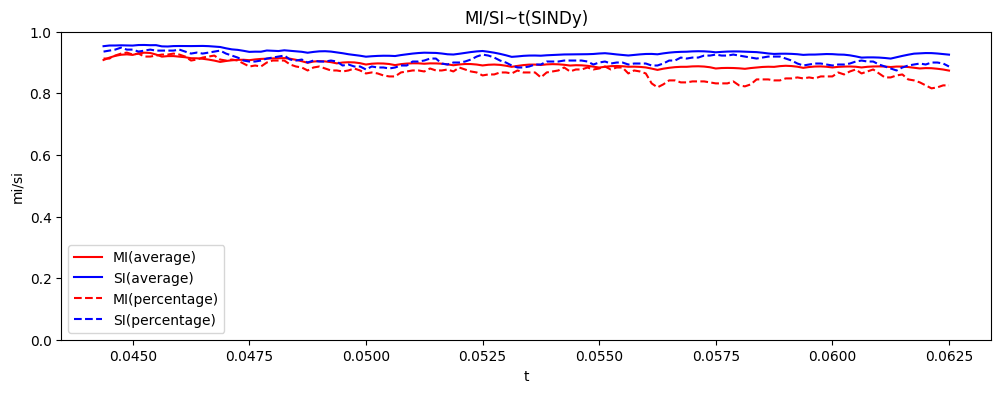

round: 72
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 411.571 1 + -65.862 Vx + 200.406 Vy + -16186.072 t + 69.491 VxVx + -14.870 VyVy + 159002.146 tt + 132.302 VxVy + 1112.820 Vxt + -3260.433 Vyt + -9.567 VxVxVy + -885.636 VxVxt + 354.276 VyVyt + -2347.106 VxVyt + 3213.600 Vx_2 + -1253.190 Vy_2 + -1568.210 Vx_1 + -1083.598 Vy_1 + -136.536 VxVx_2 + -428.813 VxVy_2 + -120726.246 Vxt_2 + 12.135 VyVx_2 + 108.854 VyVy_2 + 1133803.205 Vyt_2 + -28.970 tVx_2 + 1670.123 tVy_2 + 7429.927 tt_2 + 22.739 VxVxVx_2 + -546.905 VxVxVy_2 + -2473.072 VxVxt_2 + 1444.265 VyVyVx_2 + 43.466 VyVyVy_2 + -47.394 VyVyt_2 + 48948.715 ttVx_2 + 19.599 ttVy_2 + 39.381 ttt_2 + -464663.366 VxVyVx_2 + 139.496 VxVyVy_2 + -1354.579 VxVyt_2 + 801.994 VxtVx_2 + -48.918 VxtVy_2 + 167.824 Vxtt_2 + -722.119 VytVx_2 + -2748.217 VytVy_2 + -69.683 VxVx_1 + 294.267 VxVy_1 + 53593.542 Vxt_1 + 260.165 VyVx_1 + 320.680 VyVy_1 + -453877.119 Vyt_1 + 738.697 tVx_1 + 668.325 tVy_1 + -3876.853 tt_1 + -15.014 VxVxVx_1 + -4501.279 VxVxVy_1 + -56

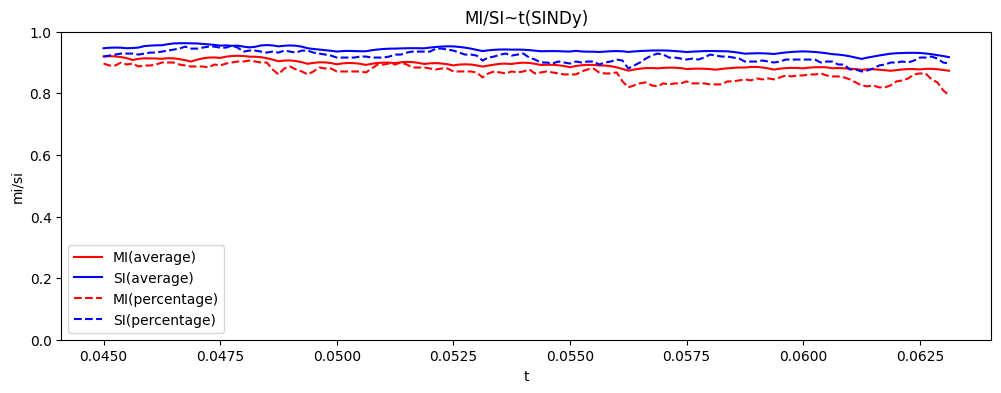

round: 73
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 489.183 1 + -180.525 Vx + 95.418 Vy + -18767.889 t + 25.917 VxVx + -1.184 VyVy + 179965.540 tt + 201.401 VxVy + 3394.584 Vxt + -1294.161 Vyt + -13.069 VxVxVy + -26.767 VxVxt + 63.584 VyVyt + -3757.525 VxVyt + 1610.187 Vx_2 + -2102.169 Vy_2 + -1936.812 Vx_1 + -892.065 Vy_1 + -85.630 VxVx_2 + 329.350 VxVy_2 + -61219.863 Vxt_2 + 67.378 VyVx_2 + 71.843 VyVy_2 + 586241.441 Vyt_2 + 278.032 tVx_2 + 1040.807 tVy_2 + -6875.244 tt_2 + 28.085 VxVxVx_2 + -1434.896 VxVxVy_2 + -1468.718 VxVxt_2 + -4060.398 VyVyVx_2 + -945.973 VyVyVy_2 + -143.727 VyVyt_2 + 77499.760 ttVx_2 + -56.026 ttVy_2 + 10.061 ttt_2 + -705458.064 VxVyVx_2 + 74.930 VxVyVy_2 + 16666.615 VxVyt_2 + 2468.126 VxtVx_2 + -44.974 VxtVy_2 + 1407.963 Vxtt_2 + -170.869 VytVx_2 + -1862.302 VytVy_2 + -353.862 VxVx_1 + 694.675 VxVy_1 + 65333.452 Vxt_1 + 42.837 VyVx_1 + 37.048 VyVy_1 + -547427.270 Vyt_1 + 567.767 tVx_1 + 5592.817 tVy_1 + -10837.129 tt_1 + -8.639 VxVxVx_1 + -756.167 VxVxVy_1 + 161.

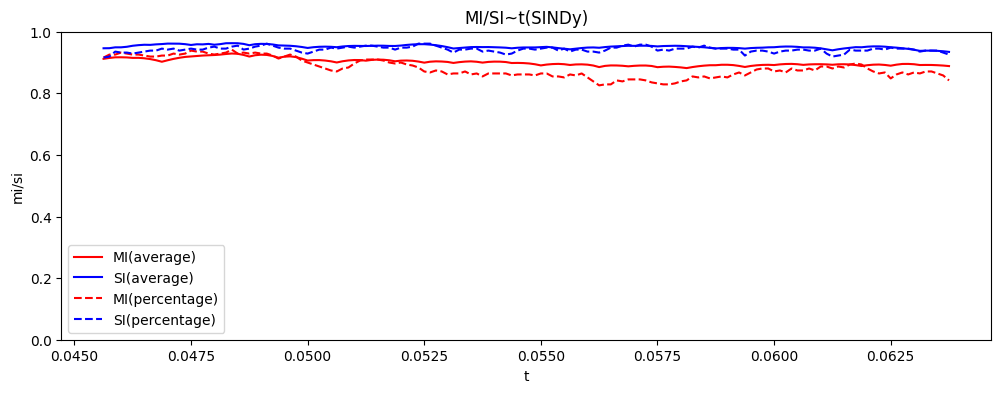

round: 74
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 131.296 1 + -103.415 Vx + 182.575 Vy + -5155.649 t + -58.345 VxVx + -45.227 VyVy + 51742.235 tt + 39.053 VxVy + 1879.946 Vxt + -2944.165 Vyt + -8.380 VxVxVy + 1461.504 VxVxt + 854.614 VyVyt + -702.331 VxVyt + 1389.912 Vx_2 + -2816.709 Vy_2 + -2929.607 Vx_1 + -1342.943 Vy_1 + -231.144 VxVx_2 + 419.718 VxVy_2 + -52524.803 Vxt_2 + -50.087 VyVx_2 + 194.800 VyVy_2 + 500619.046 Vyt_2 + 458.060 tVx_2 + 3929.886 tVy_2 + -8265.972 tt_2 + 13.740 VxVxVx_2 + 864.550 VxVxVy_2 + -3695.504 VxVxt_2 + -7599.286 VyVyVx_2 + -470.833 VyVyVy_2 + -168.614 VyVyt_2 + 101562.011 ttVx_2 + -387.839 ttVy_2 + -9.384 ttt_2 + -903954.011 VxVyVx_2 + -407.102 VxVyVy_2 + 8109.031 VxVyt_2 + 2845.993 VxtVx_2 + -41.304 VxtVy_2 + 7254.947 Vxtt_2 + 131.322 VytVx_2 + 6770.754 VytVy_2 + -83.800 VxVx_1 + 635.223 VxVy_1 + 100070.491 Vxt_1 + 117.835 VyVx_1 + 708.525 VyVy_1 + -846385.928 Vyt_1 + 1120.009 tVx_1 + 956.325 tVy_1 + -9901.926 tt_1 + -8.450 VxVxVx_1 + -2036.872 VxVxVy_1 +

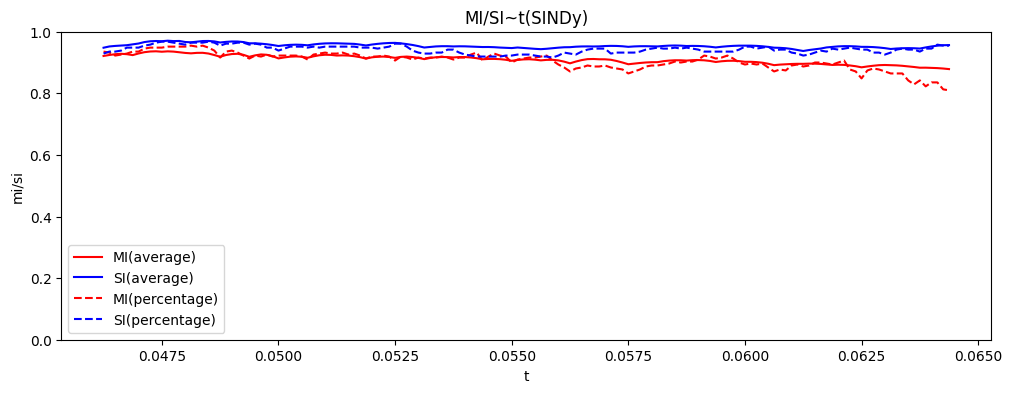

round: 75
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 161.602 1 + 95.831 Vx + 328.585 Vy + -6113.147 t + 20.442 VxVx + 28.243 VyVy + 59737.289 tt + 216.568 VxVy + -1609.618 Vxt + -5564.593 Vyt + -6.909 VxVxVy + 23.271 VxVxt + -467.635 VyVyt + -3840.074 VxVyt + 1586.702 Vx_2 + -4562.424 Vy_2 + -1007.537 Vx_1 + -1298.888 Vy_1 + 189.039 VxVx_2 + -112.092 VxVy_2 + -58964.177 Vxt_2 + 117.146 VyVx_2 + -28.640 VyVy_2 + 555085.131 Vyt_2 + 53.899 tVx_2 + -3356.469 tVy_2 + 1115.464 tt_2 + 14.117 VxVxVx_2 + -2073.352 VxVxVy_2 + 108.830 VxVxt_2 + -612.761 VyVyVx_2 + -86.941 VyVyVy_2 + -291.681 VyVyt_2 + 161952.467 ttVx_2 + 43.791 ttVy_2 + 13.628 ttt_2 + -1421648.705 VxVyVx_2 + -98.377 VxVyVy_2 + 1298.680 VxVyt_2 + 5025.535 VxtVx_2 + -45.514 VxtVy_2 + -217.965 Vxtt_2 + -334.818 VytVx_2 + 1278.284 VytVy_2 + -4.437 VxVx_1 + 506.398 VxVy_1 + 31408.624 Vxt_1 + 133.107 VyVx_1 + 598.931 VyVy_1 + -239308.597 Vyt_1 + 1370.894 tVx_1 + -83.782 tVy_1 + -7408.706 tt_1 + 4.111 VxVxVx_1 + -2174.792 VxVxVy_1 + -10263.2

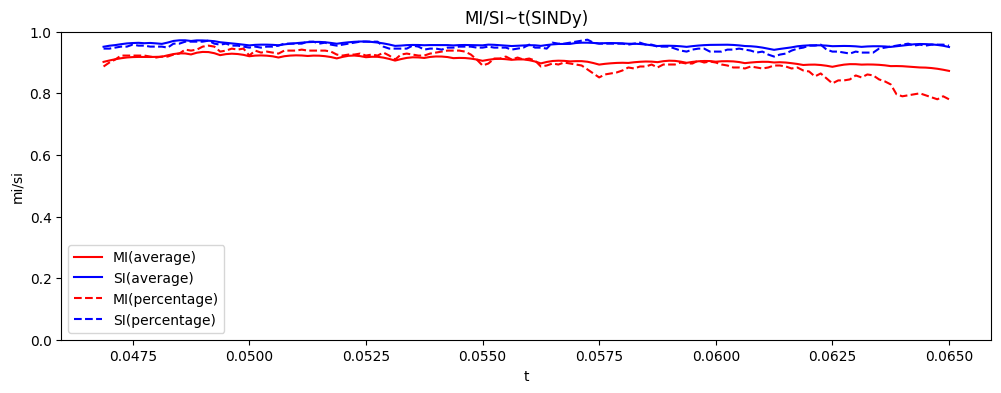

round: 76
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 82.233 1 + 99.239 Vx + 221.364 Vy + -3161.767 t + 9.036 VxVx + -13.539 VyVy + 32143.314 tt + 35.318 VxVy + -1483.336 Vxt + -3625.149 Vyt + -8.704 VxVxVy + 258.761 VxVxt + 299.770 VyVyt + -671.021 VxVyt + 70.644 Vx_2 + -1546.453 Vy_2 + 965.988 Vx_1 + -1316.952 Vy_1 + -123.532 VxVx_2 + 668.719 VxVy_2 + -2720.352 Vxt_2 + -133.446 VyVx_2 + -277.185 VyVy_2 + 36396.963 Vyt_2 + 165.699 tVx_2 + 1585.244 tVy_2 + -12528.216 tt_2 + 27.834 VxVxVx_2 + 2075.884 VxVxVy_2 + 4436.206 VxVxt_2 + -2172.102 VyVyVx_2 + 89.927 VyVyVy_2 + 102.598 VyVyt_2 + 59831.759 ttVx_2 + 75.825 ttVy_2 + -20.045 ttt_2 + -564288.286 VxVyVx_2 + 188.183 VxVyVy_2 + -1589.202 VxVyt_2 + -1778.340 VxtVx_2 + -33.494 VxtVy_2 + -787.899 Vxtt_2 + 401.128 VytVx_2 + -3109.881 VytVy_2 + -33.678 VxVx_1 + 574.590 VxVy_1 + -34589.115 Vxt_1 + 81.326 VyVx_1 + 341.658 VyVy_1 + 306514.554 Vyt_1 + 894.017 tVx_1 + 331.941 tVy_1 + -8432.114 tt_1 + -19.955 VxVxVx_1 + -1085.600 VxVxVy_1 + -5494.793 Vx

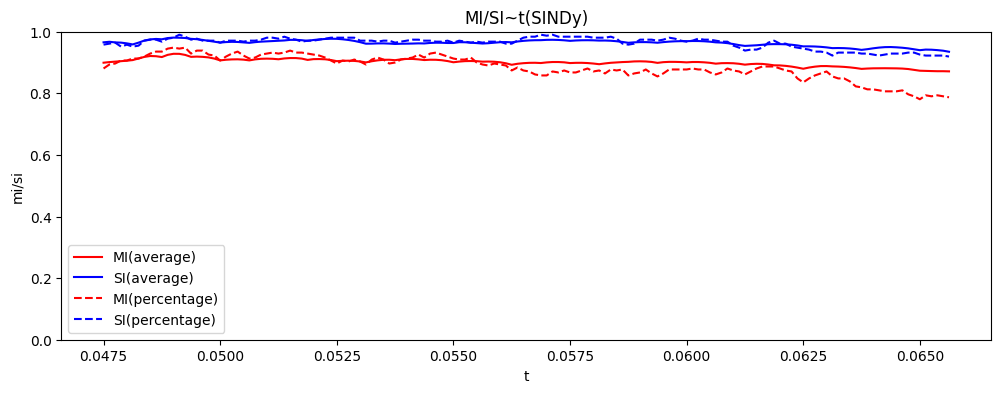

round: 77
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 429.303 1 + 14.502 Vx + 229.570 Vy + -16222.532 t + -76.631 VxVx + 44.276 VyVy + 153413.161 tt + 74.191 VxVy + -227.718 Vxt + -3717.052 Vyt + -3.079 VxVxVy + 1709.530 VxVxt + -720.104 VyVyt + -1278.345 VxVyt + 2982.164 Vx_2 + -4023.939 Vy_2 + -1159.103 Vx_1 + -6.943 Vy_1 + 71.817 VxVx_2 + 494.056 VxVy_2 + -107316.138 Vxt_2 + -101.630 VyVx_2 + -546.463 VyVy_2 + 967899.376 Vyt_2 + -429.888 tVx_2 + -1304.718 tVy_2 + -9747.422 tt_2 + 19.687 VxVxVx_2 + 1758.801 VxVxVy_2 + 9498.118 VxVxt_2 + 8302.138 VyVyVx_2 + -26.243 VyVyVy_2 + -110.644 VyVyt_2 + 140116.916 ttVx_2 + 588.917 ttVy_2 + 36.120 ttt_2 + -1202545.742 VxVyVx_2 + 632.616 VxVyVy_2 + 527.985 VxVyt_2 + 1874.944 VxtVx_2 + -49.491 VxtVy_2 + -10060.453 Vxtt_2 + -702.429 VytVx_2 + -11812.578 VytVy_2 + -397.873 VxVx_1 + 543.070 VxVy_1 + 36937.619 Vxt_1 + 16.616 VyVx_1 + 515.176 VyVy_1 + -287367.593 Vyt_1 + 1070.477 tVx_1 + 6742.251 tVy_1 + -7918.974 tt_1 + 2.414 VxVxVx_1 + -170.891 VxVxVy_1 +

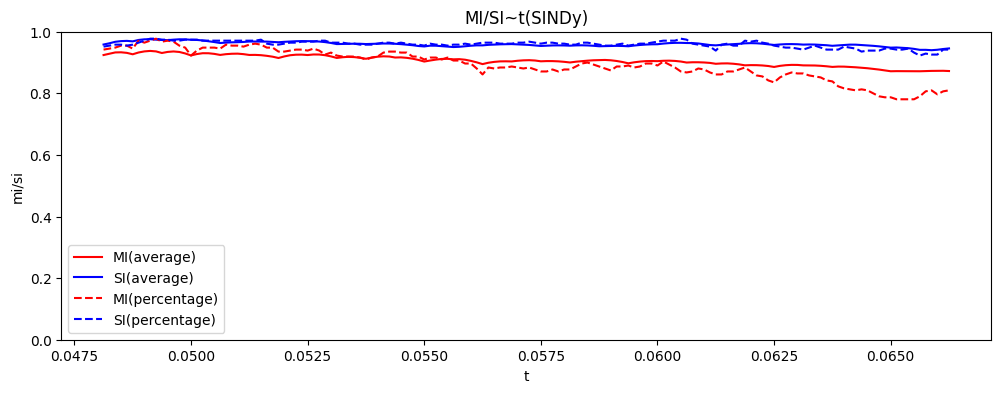

round: 78
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 527.463 1 + 129.399 Vx + 219.804 Vy + -18987.788 t + 1.554 VxVx + -6.604 VyVy + 171742.199 tt + -25.492 VxVy + -2062.318 Vxt + -3546.523 Vyt + -5.579 VxVxVy + 396.406 VxVxt + 149.765 VyVyt + 325.827 VxVyt + 2392.530 Vx_2 + -238.060 Vy_2 + -1870.177 Vx_1 + -1504.082 Vy_1 + 341.577 VxVx_2 + 961.487 VxVy_2 + -83954.881 Vxt_2 + -2.349 VyVx_2 + -259.348 VyVy_2 + 742724.311 Vyt_2 + 289.266 tVx_2 + -6034.343 tVy_2 + -17546.411 tt_2 + 20.536 VxVxVx_2 + 12.422 VxVxVy_2 + 4400.154 VxVxt_2 + -4269.405 VyVyVx_2 + 37.877 VyVyVy_2 + -162.998 VyVyt_2 + 8578.415 ttVx_2 + 15.676 ttVy_2 + -55.937 ttt_2 + -67942.186 VxVyVx_2 + 39.506 VxVyVy_2 + -942.566 VxVyt_2 + 2679.805 VxtVx_2 + -37.568 VxtVy_2 + -118.841 Vxtt_2 + 936.164 VytVx_2 + -1133.184 VytVy_2 + -189.376 VxVx_1 + 950.346 VxVy_1 + 61015.233 Vxt_1 + 156.731 VyVx_1 + 461.308 VyVy_1 + -490271.367 Vyt_1 + 1004.226 tVx_1 + 2618.765 tVy_1 + -15154.397 tt_1 + 13.363 VxVxVx_1 + -2975.882 VxVxVy_1 + -7267.23

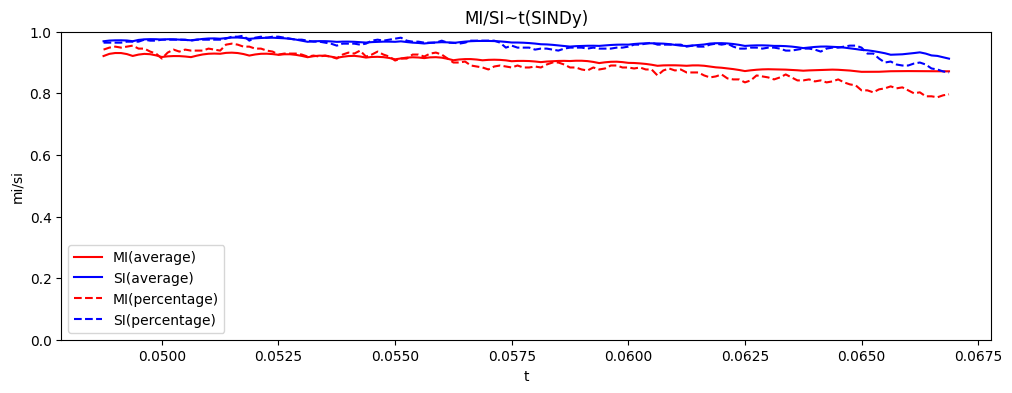

round: 79
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -626.616 1 + 79.012 Vx + 82.013 Vy + 20950.857 t + -37.814 VxVx + -52.615 VyVy + -171491.411 tt + -54.017 VxVy + -1179.803 Vxt + -1167.781 Vyt + -4.846 VxVxVy + 1018.561 VxVxt + 923.884 VyVyt + 794.038 VxVyt + -82.665 Vx_2 + -560.266 Vy_2 + 296.779 Vx_1 + -733.573 Vy_1 + 100.437 VxVx_2 + 626.666 VxVy_2 + 1904.004 Vxt_2 + -143.968 VyVx_2 + -439.296 VyVy_2 + 2288.400 Vyt_2 + -236.473 tVx_2 + -2077.372 tVy_2 + -12599.370 tt_2 + 25.151 VxVxVx_2 + 2342.012 VxVxVy_2 + 7357.706 VxVxt_2 + 4619.105 VyVyVx_2 + 323.128 VyVyVy_2 + -89.761 VyVyt_2 + 18352.976 ttVx_2 + 323.148 ttVy_2 + -25.353 ttt_2 + -141894.018 VxVyVx_2 + 224.331 VxVyVy_2 + -4861.494 VxVyt_2 + 1373.549 VxtVx_2 + -26.885 VxtVy_2 + -5262.454 Vxtt_2 + 401.265 VytVx_2 + -4162.268 VytVy_2 + -597.120 VxVx_1 + 852.741 VxVy_1 + -15985.413 Vxt_1 + -165.085 VyVx_1 + 290.214 VyVy_1 + 187413.453 Vyt_1 + 839.527 tVx_1 + 9434.492 tVy_1 + -14202.302 tt_1 + 19.176 VxVxVx_1 + 2550.118 VxVxVy_1 + -460

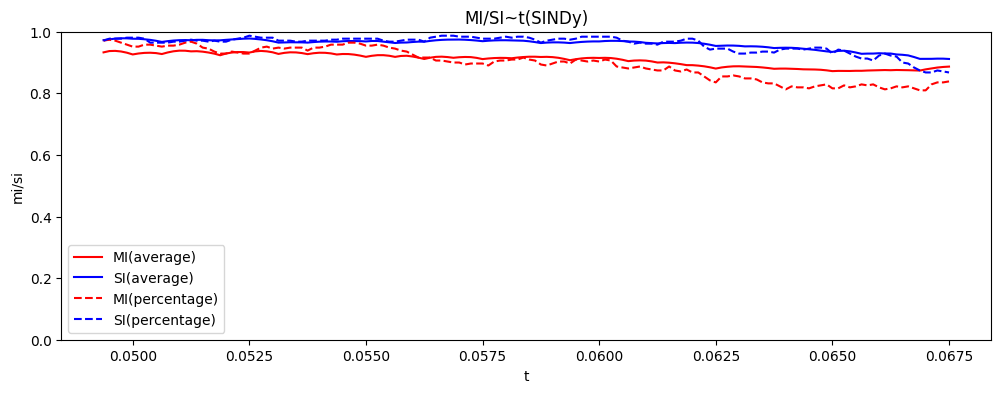

round: 80
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 351.704 1 + 107.770 Vx + 121.254 Vy + -12091.306 t + -124.823 VxVx + 12.148 VyVy + 105641.277 tt + 60.323 VxVy + -1622.764 Vxt + -1771.457 Vyt + -4.920 VxVxVy + 2454.139 VxVxt + -116.063 VyVyt + -1094.225 VxVyt + 1975.827 Vx_2 + -3069.877 Vy_2 + 1707.471 Vx_1 + -1573.927 Vy_1 + 177.631 VxVx_2 + 1414.070 VxVy_2 + -67456.140 Vxt_2 + -152.892 VyVx_2 + -587.488 VyVy_2 + 582323.683 Vyt_2 + -167.899 tVx_2 + -3517.571 tVy_2 + -25331.723 tt_2 + 39.828 VxVxVx_2 + 2458.133 VxVxVy_2 + 9699.100 VxVxt_2 + 4300.760 VyVyVx_2 + -309.570 VyVyVy_2 + -133.276 VyVyt_2 + 102467.241 ttVx_2 + 635.867 ttVy_2 + -0.072 ttt_2 + -845114.883 VxVyVx_2 + 285.666 VxVyVy_2 + 5936.574 VxVyt_2 + 2103.942 VxtVx_2 + -47.623 VxtVy_2 + -10330.337 Vxtt_2 + -67.222 VytVx_2 + -5508.652 VytVy_2 + -326.959 VxVx_1 + 1122.239 VxVy_1 + -61524.996 Vxt_1 + -97.249 VyVx_1 + 502.544 VyVy_1 + 551438.380 Vyt_1 + 1135.592 tVx_1 + 5289.332 tVy_1 + -18083.051 tt_1 + 11.091 VxVxVx_1 + 1533.444 

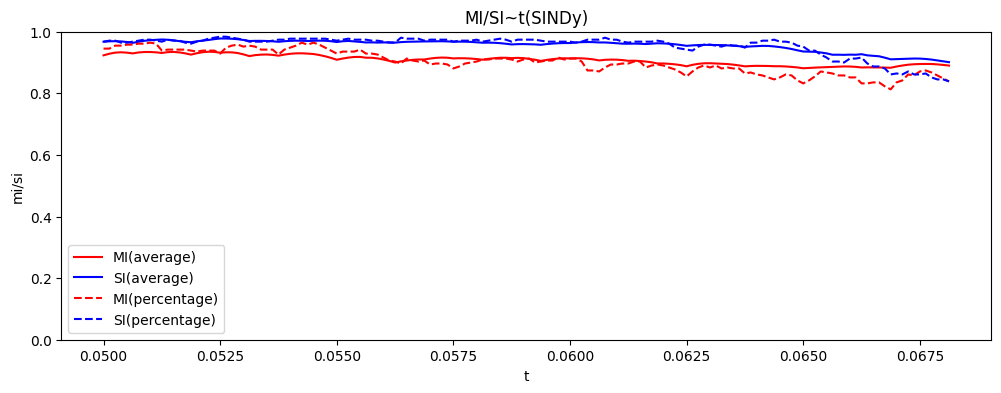

round: 81
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -35.063 1 + 253.211 Vx + -23.700 Vy + 1213.081 t + 39.066 VxVx + -92.157 VyVy + -7841.745 tt + 21.280 VxVy + -3961.486 Vxt + 623.952 Vyt + -7.560 VxVxVy + -195.926 VxVxt + 1561.092 VyVyt + -588.205 VxVyt + -1419.348 Vx_2 + -3411.876 Vy_2 + -2078.132 Vx_1 + -3462.365 Vy_1 + 443.991 VxVx_2 + 1594.419 VxVy_2 + 47321.505 Vxt_2 + -46.327 VyVx_2 + -208.157 VyVy_2 + -381872.288 Vyt_2 + -66.314 tVx_2 + -7470.124 tVy_2 + -28333.561 tt_2 + 32.359 VxVxVx_2 + 893.698 VxVxVy_2 + 3566.473 VxVxt_2 + 2444.843 VyVyVx_2 + -1575.420 VyVyVy_2 + -287.250 VyVyt_2 + 112403.439 ttVx_2 + 363.546 ttVy_2 + -23.890 ttt_2 + -913534.772 VxVyVx_2 + 423.351 VxVyVy_2 + 26499.912 VxVyt_2 + 4365.263 VxtVx_2 + -16.225 VxtVy_2 + -6659.279 Vxtt_2 + 315.014 VytVx_2 + -7594.447 VytVy_2 + -41.772 VxVx_1 + 205.691 VxVy_1 + 63982.097 Vxt_1 + 17.525 VyVx_1 + 429.108 VyVy_1 + -483288.677 Vyt_1 + 604.914 tVx_1 + 494.525 tVy_1 + -3349.957 tt_1 + 26.212 VxVxVx_1 + -478.448 VxVxVy_1 + -

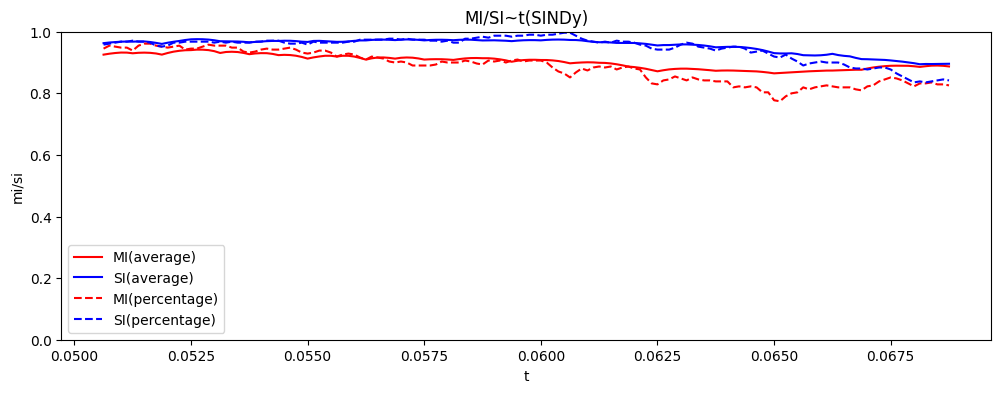

round: 82
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 133.763 1 + 157.307 Vx + -121.767 Vy + -4768.386 t + 83.766 VxVx + -66.228 VyVy + 44828.548 tt + -47.766 VxVy + -2377.868 Vxt + 2195.107 Vyt + -9.149 VxVxVy + -971.158 VxVxt + 1126.758 VyVyt + 496.818 VxVyt + 876.259 Vx_2 + 701.419 Vy_2 + -1253.778 Vx_1 + -1135.000 Vy_1 + 441.556 VxVx_2 + 1946.852 VxVy_2 + -27956.587 Vxt_2 + -28.152 VyVx_2 + -324.088 VyVy_2 + 232897.926 Vyt_2 + 3.301 tVx_2 + -7762.535 tVy_2 + -33698.672 tt_2 + 34.623 VxVxVx_2 + 400.480 VxVxVy_2 + 5433.605 VxVxt_2 + 1424.820 VyVyVx_2 + -1249.164 VyVyVy_2 + -52.438 VyVyt_2 + -23395.484 ttVx_2 + 228.016 ttVy_2 + -3.474 ttt_2 + 198325.450 VxVyVx_2 + 220.011 VxVyVy_2 + 20692.159 VxVyt_2 + 535.716 VxtVx_2 + -13.510 VxtVy_2 + -4191.291 Vxtt_2 + 52.104 VytVx_2 + -3890.747 VytVy_2 + 161.379 VxVx_1 + 744.669 VxVy_1 + 39075.225 Vxt_1 + 8.505 VyVx_1 + 419.646 VyVy_1 + -298674.234 Vyt_1 + 160.601 tVx_1 + -2943.908 tVy_1 + -12136.510 tt_1 + 17.945 VxVxVx_1 + -159.765 VxVxVy_1 + -6481.6

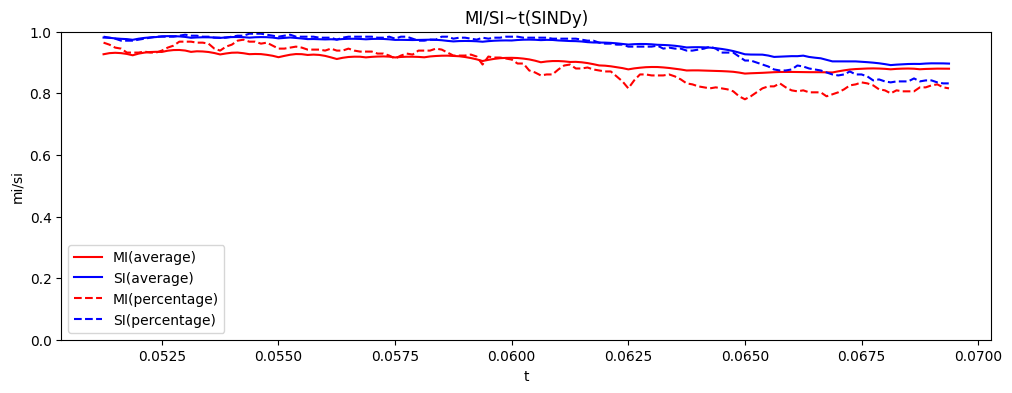

round: 83
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 41.974 1 + 99.415 Vx + -148.931 Vy + -1481.444 t + 29.556 VxVx + -73.771 VyVy + 15843.466 tt + -4.884 VxVy + -1371.623 Vxt + 2702.120 Vyt + -6.646 VxVxVy + -131.201 VxVxt + 1296.149 VyVyt + -99.359 VxVyt + 983.295 Vx_2 + -838.760 Vy_2 + -2063.088 Vx_1 + -334.262 Vy_1 + 354.625 VxVx_2 + 1764.781 VxVy_2 + -30486.535 Vxt_2 + -129.555 VyVx_2 + -231.647 VyVy_2 + 244439.417 Vyt_2 + -165.157 tVx_2 + -6055.530 tVy_2 + -30973.411 tt_2 + 31.807 VxVxVx_2 + 2129.499 VxVxVy_2 + 3802.922 VxVxt_2 + 4022.094 VyVyVx_2 + -819.430 VyVyVy_2 + 79.467 VyVyt_2 + 30057.421 ttVx_2 + 271.057 ttVy_2 + -114.465 ttt_2 + -260286.938 VxVyVx_2 + -124.754 VxVyVy_2 + 13804.255 VxVyt_2 + -1641.810 VxtVx_2 + -23.745 VxtVy_2 + -4774.792 Vxtt_2 + 1931.244 VytVx_2 + 1841.514 VytVy_2 + 256.135 VxVx_1 + 357.208 VxVy_1 + 66268.981 Vxt_1 + 64.439 VyVx_1 + 131.868 VyVy_1 + -523243.264 Vyt_1 + -328.409 tVx_1 + -4439.221 tVy_1 + -5924.843 tt_1 + 5.887 VxVxVx_1 + -1083.383 VxVxVy_1 + 

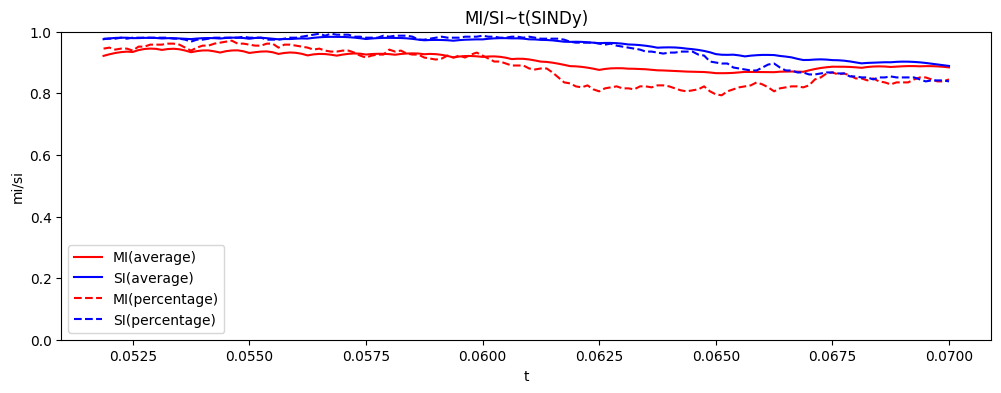

round: 84
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -614.583 1 + 103.127 Vx + -171.818 Vy + 19901.309 t + 129.453 VxVx + -68.509 VyVy + -156786.616 tt + 19.543 VxVy + -1448.999 Vxt + 3073.010 Vyt + -11.148 VxVxVy + -1789.033 VxVxt + 1152.139 VyVyt + -652.783 VxVyt + 1656.281 Vx_2 + -50.664 Vy_2 + 646.830 Vx_1 + -195.721 Vy_1 + 97.791 VxVx_2 + 1360.349 VxVy_2 + -51838.107 Vxt_2 + -157.729 VyVx_2 + -365.750 VyVy_2 + 414817.075 Vyt_2 + -446.202 tVx_2 + -2042.772 tVy_2 + -24224.635 tt_2 + 28.174 VxVxVx_2 + 2476.507 VxVxVy_2 + 5852.894 VxVxt_2 + 8255.671 VyVyVx_2 + -901.027 VyVyVy_2 + 21.398 VyVyt_2 + 5596.510 ttVx_2 + 405.374 ttVy_2 + -87.557 ttt_2 + -73044.395 VxVyVx_2 + -6.014 VxVyVy_2 + 14805.875 VxVyt_2 + -768.485 VxtVx_2 + -19.999 VxtVy_2 + -6869.590 Vxtt_2 + 1485.408 VytVx_2 + 22.160 VytVy_2 + 401.390 VxVx_1 + 75.015 VxVy_1 + -22394.107 Vxt_1 + 68.303 VyVx_1 + 348.201 VyVy_1 + 194475.450 Vyt_1 + -509.188 tVx_1 + -6655.379 tVy_1 + -1356.305 tt_1 + -2.772 VxVxVx_1 + -921.993 VxVxVy_1 + -52

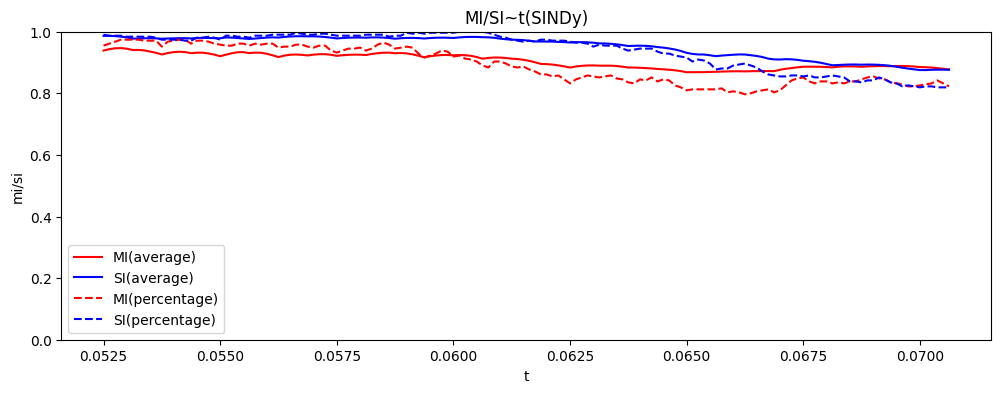

round: 85
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -157.815 1 + 27.270 Vx + -239.928 Vy + 5074.178 t + 134.663 VxVx + -123.890 VyVy + -37222.937 tt + 20.020 VxVy + -166.282 Vxt + 4145.330 Vyt + -10.270 VxVxVy + -1847.913 VxVxt + 2076.148 VyVyt + -557.469 VxVyt + 3106.950 Vx_2 + -2915.901 Vy_2 + -2221.853 Vx_1 + -240.201 Vy_1 + 464.255 VxVx_2 + 1125.841 VxVy_2 + -96525.967 Vxt_2 + -9.279 VyVx_2 + -116.801 VyVy_2 + 756564.137 Vyt_2 + -385.011 tVx_2 + -7616.234 tVy_2 + -20280.435 tt_2 + 22.409 VxVxVx_2 + 254.010 VxVxVy_2 + 1779.550 VxVxt_2 + 7129.832 VyVyVx_2 + -802.164 VyVyVy_2 + 291.865 VyVyt_2 + 96537.798 ttVx_2 + 61.435 ttVy_2 + -88.865 ttt_2 + -790856.754 VxVyVx_2 + -358.188 VxVyVy_2 + 12794.652 VxVyt_2 + -5127.785 VxtVx_2 + -24.329 VxtVy_2 + -1213.172 Vxtt_2 + 1587.896 VytVx_2 + 5903.765 VytVy_2 + 359.409 VxVx_1 + 21.685 VxVy_1 + 67338.791 Vxt_1 + -24.912 VyVx_1 + -7.427 VyVy_1 + -502486.707 Vyt_1 + -864.865 tVx_1 + -6090.427 tVy_1 + -792.501 tt_1 + -7.787 VxVxVx_1 + 607.563 VxVxVy_1 +

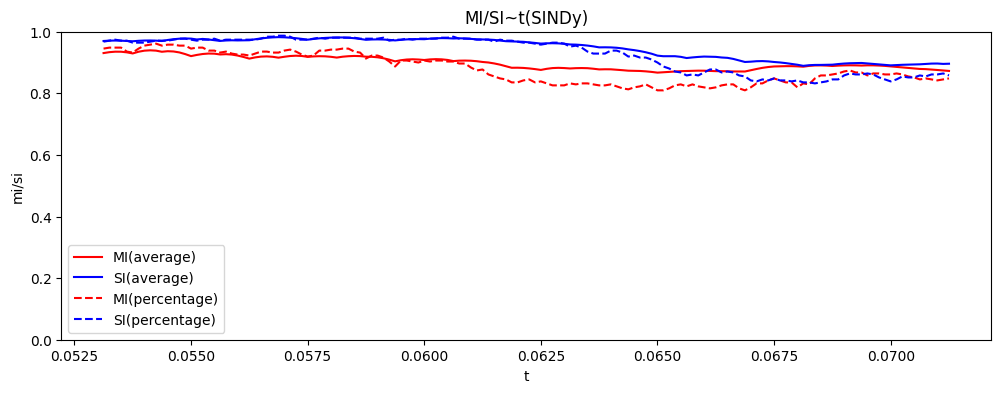

round: 86
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = -339.877 1 + 11.667 Vx + -222.223 Vy + 10354.379 t + 216.951 VxVx + -166.267 VyVy + -74869.940 tt + -158.882 VxVy + 110.447 Vxt + 3941.383 Vyt + -12.913 VxVxVy + -3151.885 VxVxt + 2745.269 VyVyt + 2248.362 VxVyt + 2478.974 Vx_2 + -3433.455 Vy_2 + -2583.641 Vx_1 + 1327.288 Vy_1 + 443.397 VxVx_2 + 802.396 VxVy_2 + -77405.788 Vxt_2 + -41.943 VyVx_2 + 304.962 VyVy_2 + 611618.701 Vyt_2 + -344.522 tVx_2 + -7379.222 tVy_2 + -15327.986 tt_2 + 29.002 VxVxVx_2 + 772.061 VxVxVy_2 + -4886.378 VxVxt_2 + 6337.202 VyVyVx_2 + -124.758 VyVyVy_2 + 411.577 VyVyt_2 + 112534.770 ttVx_2 + -388.510 ttVy_2 + -21.804 ttt_2 + -913040.913 VxVyVx_2 + -766.259 VxVyVy_2 + 1508.879 VxVyt_2 + -7049.951 VxtVx_2 + -20.909 VxtVy_2 + 6058.989 Vxtt_2 + 566.317 VytVx_2 + 12504.492 VytVy_2 + -214.292 VxVx_1 + 349.147 VxVy_1 + 80761.692 Vxt_1 + -166.443 VyVx_1 + 400.621 VyVy_1 + -620912.844 Vyt_1 + -776.109 tVx_1 + 2663.566 tVy_1 + -5652.336 tt_1 + -6.984 VxVxVx_1 + 2688.752 Vx

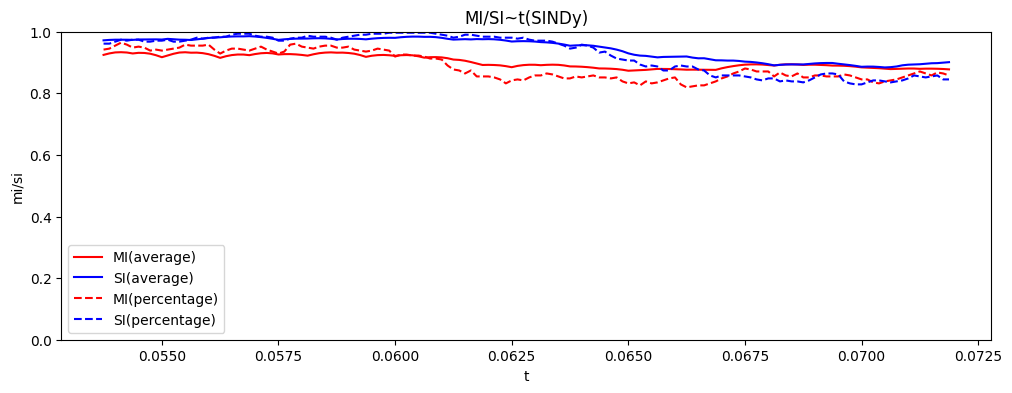

round: 87
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 153.913 1 + 56.595 Vx + -202.543 Vy + -5006.061 t + 261.254 VxVx + -212.745 VyVy + 44164.178 tt + -81.792 VxVy + -539.559 Vxt + 3573.479 Vyt + -9.769 VxVxVy + -3800.986 VxVxt + 3472.890 VyVyt + 1108.937 VxVyt + 1223.195 Vx_2 + -5823.421 Vy_2 + -2159.476 Vx_1 + -1351.361 Vy_1 + 72.639 VxVx_2 + 507.840 VxVy_2 + -36301.529 Vxt_2 + -180.517 VyVx_2 + 266.818 VyVy_2 + 280637.696 Vyt_2 + -264.804 tVx_2 + -1545.527 tVy_2 + -10669.729 tt_2 + 29.764 VxVxVx_2 + 2860.057 VxVxVy_2 + -4503.561 VxVxt_2 + 5066.986 VyVyVx_2 + 311.159 VyVyVy_2 + 412.413 VyVyt_2 + 183064.664 ttVx_2 + 69.966 ttVy_2 + -56.697 ttt_2 + -1430434.121 VxVyVx_2 + -802.710 VxVyVy_2 + -5263.174 VxVyt_2 + -7234.218 VxtVx_2 + -25.830 VxtVy_2 + -830.784 Vxtt_2 + 1139.586 VytVx_2 + 13321.040 VytVy_2 + 152.481 VxVx_1 + 266.569 VxVy_1 + 62289.799 Vxt_1 + -46.112 VyVx_1 + 285.508 VyVy_1 + -439767.401 Vyt_1 + -1200.441 tVx_1 + -2920.095 tVy_1 + -5014.444 tt_1 + -5.965 VxVxVx_1 + 1127.681 VxV

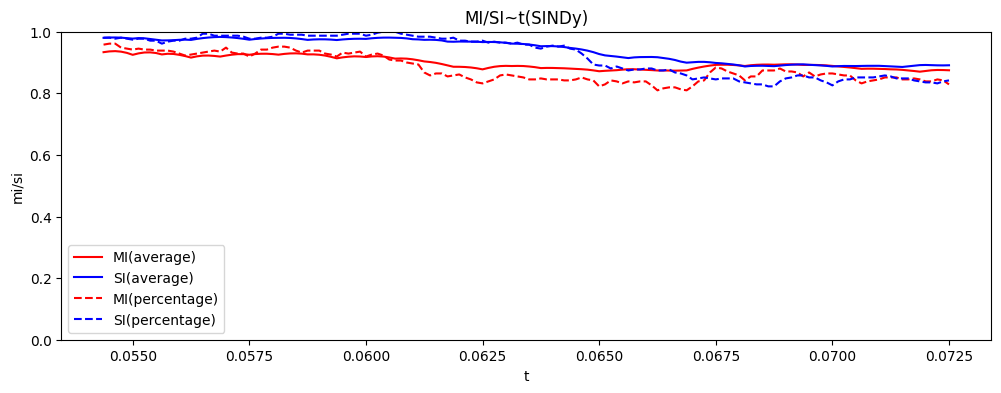

round: 88
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 167.405 1 + -17.842 Vx + -204.556 Vy + -5402.208 t + 248.820 VxVx + -196.399 VyVy + 47042.610 tt + -199.046 VxVy + 535.739 Vxt + 3653.161 Vyt + -14.175 VxVxVy + -3596.161 VxVxt + 3252.689 VyVyt + 2960.569 VxVyt + 2463.844 Vx_2 + -6622.799 Vy_2 + -3286.812 Vx_1 + 18.445 Vy_1 + 226.174 VxVx_2 + 397.382 VxVy_2 + -75486.961 Vxt_2 + -111.619 VyVx_2 + 227.580 VyVy_2 + 587163.463 Vyt_2 + -195.194 tVx_2 + -4006.774 tVy_2 + -9069.382 tt_2 + 32.215 VxVxVx_2 + 1831.706 VxVxVy_2 + -3914.749 VxVxt_2 + 3786.197 VyVyVx_2 + 585.973 VyVyVy_2 + 451.286 VyVyt_2 + 209687.358 ttVx_2 + -149.294 ttVy_2 + -143.069 ttt_2 + -1649918.728 VxVyVx_2 + -832.665 VxVyVy_2 + -9663.639 VxVyt_2 + -7878.816 VxtVx_2 + -16.340 VxtVy_2 + 2613.154 Vxtt_2 + 2482.411 VytVx_2 + 13856.892 VytVy_2 + 289.572 VxVx_1 + 469.478 VxVy_1 + 100776.165 Vxt_1 + -57.273 VyVx_1 + 105.927 VyVy_1 + -764826.467 Vyt_1 + -1675.687 tVx_1 + -5107.963 tVy_1 + -7753.124 tt_1 + -13.622 VxVxVx_1 + 1315.489

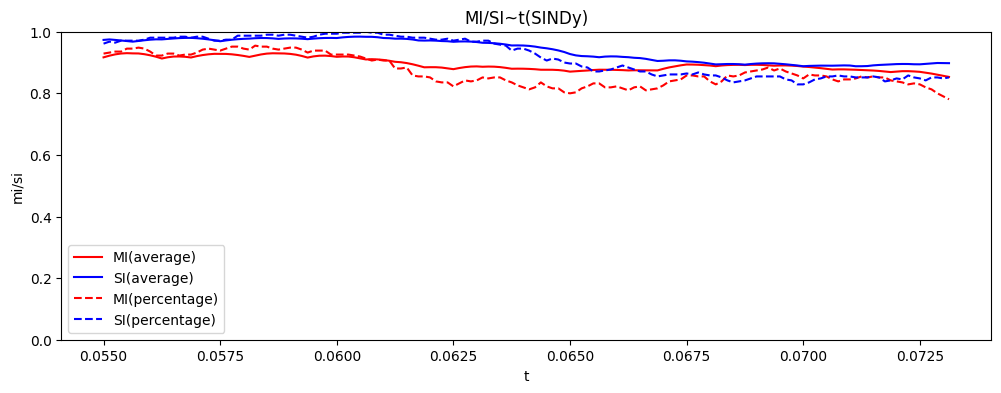

round: 89
(25, 25, 146, 3)
(146,)
SINDy
(Vx)' = 643.087 1 + -109.186 Vx + -295.209 Vy + -19741.048 t + 196.024 VxVx + -248.904 VyVy + 154418.387 tt + -192.487 VxVy + 2052.366 Vxt + 4972.758 Vyt + -6.092 VxVxVy + -2777.100 VxVxt + 4024.889 VyVyt + 2834.092 VxVyt + 1296.964 Vx_2 + -6640.069 Vy_2 + -6119.564 Vx_1 + -2397.698 Vy_1 + -126.831 VxVx_2 + 665.239 VxVy_2 + -37442.384 Vxt_2 + -318.397 VyVx_2 + 566.365 VyVy_2 + 281436.246 Vyt_2 + 251.332 tVx_2 + 1403.335 tVy_2 + -12607.358 tt_2 + 23.683 VxVxVx_2 + 4951.993 VxVxVy_2 + -9301.130 VxVxt_2 + -2960.583 VyVyVx_2 + 341.744 VyVyVy_2 + 327.294 VyVyt_2 + 204419.540 ttVx_2 + -316.317 ttVy_2 + -12.355 ttt_2 + -1564840.203 VxVyVx_2 + -739.333 VxVyVy_2 + -5574.042 VxVyt_2 + -5865.893 VxtVx_2 + -5.195 VxtVy_2 + 5004.014 Vxtt_2 + 407.009 VytVx_2 + 12520.410 VytVy_2 + -10.546 VxVx_1 + 616.542 VxVy_1 + 184610.267 Vxt_1 + -70.377 VyVx_1 + 396.196 VyVy_1 + -1380086.352 Vyt_1 + -1058.893 tVx_1 + -558.633 tVy_1 + -10273.794 tt_1 + 0.486 VxVxVx_1 + 1454.

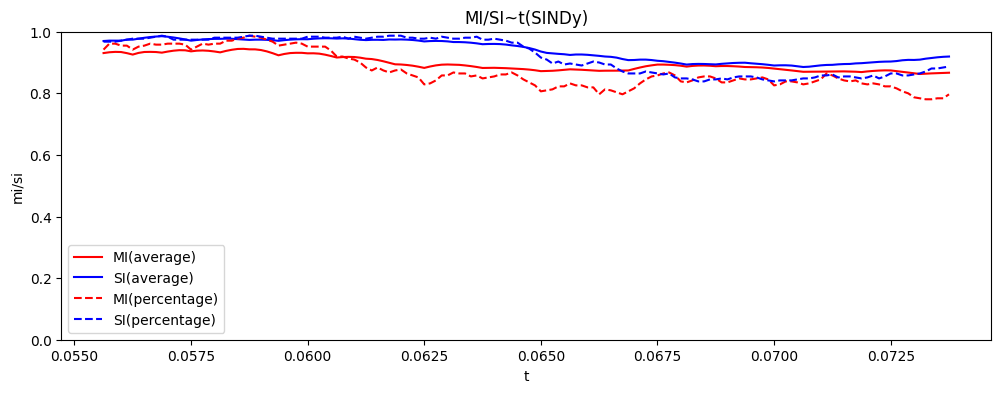

In [6]:
left_bond=0
test_range=90
good_time=np.zeros(test_range)

v_train=np.zeros((n,n,p_tot,3))
t_train=np.zeros(p_tot)
v_test=np.zeros((n,n,p_tot,3))



for k in range(test_range):
    print('round:',k)
    startp=left_bond+k
    endp=left_bond+k+dp
    v_train=u_train[:,:,startp*addp:(endp-1)*addp+1]   
    t_train=v_train[0,0,:,2]
    
    dt_train=v_train[0,0,1,2]-v_train[0,0,0,2]
    
    
    v_test=u_test[:,:,startp*addp:(endp-1)*addp+1]
    
    print(v_train.shape)
    print(t_train.shape)
    
    
    '''
    np.save('v_train.npy',v_train)
    np.savetxt('v_train_dot.txt',v_train_dot)
    np.savetxt('t_train.txt',t_train)
    '''
    model=getmodel(v_train,spatial_grid, dt_train)
    
    x_dot_test_predicted = model.predict(v_test)
    x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
    tlen=p_tot
    dot_tmp=np.array(x_dot_test_predicted)
    pltpredict=np.zeros((n,n,tlen,2))
    #print(dot_tmp[10,10])

    
    pltpredict[:,:,0]=v_train[:,:,0,:2]
    for i in range(tlen-1):
        pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
    
    for i in range(p_tot):
        j=i
        mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
        if mi_t_per[i]>0.8 and si_t_per[i]>0.8:
            good_time[k]=good_time[k]+1

        '''
        if i%(addp)==0:
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 3, 1)
            plt.title('MI percetage '+str(mi_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.subplot(1, 3, 2)
            plt.title('SI percetage '+str(si_t_per[i]))
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
            plt.legend()
            plt.subplot(1, 3, 3)
            #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
            plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
            plt.legend()
            plt.show()
        '''
    
    plt.figure(figsize=(12, 4))
    plt.title('MI/SI~t(SINDy)')
    plt.ylim(0,1)
    plt.xlabel('t')
    plt.ylabel('mi/si')
    plt.plot(t_train,mi_t,'r',label='MI(average)')
    plt.plot(t_train,si_t,'b',label='SI(average)')
    plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
    plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
    plt.legend()
    plt.ylim(0.0, 1)
    plt.plot
    plt.show()
    good_time[k]=good_time[k]/addp



fit_time: [ 3.4  4.   7.   8.   7.   7.6  6.8  6.4  7.   6.8  7.4  6.2  6.2  5.4
  4.8  6.2  4.   6.2  6.2  6.   6.2  6.   7.8  9.4  8.4  8.   7.6  6.6
  9.   6.6  6.6  8.8  7.6  9.   6.8  9.   7.6  7.   7.6  6.6  6.8  6.2
  5.8  6.   5.   5.6  5.2  6.2  8.   6.   7.2  6.  11.2  9.   9.2 10.4
 10.   8.6  7.8  8.6  8.6  5.6  6.8  6.8  7.   7.   5.8  8.  16.4 22.4
 28.4 29.2 29.  29.2 29.2 27.2 27.6 27.2 28.  29.2 29.2 28.4 28.  28.8
 28.8 29.2 29.2 29.2 28.4 27.2]


<function matplotlib.pyplot.show(close=None, block=None)>

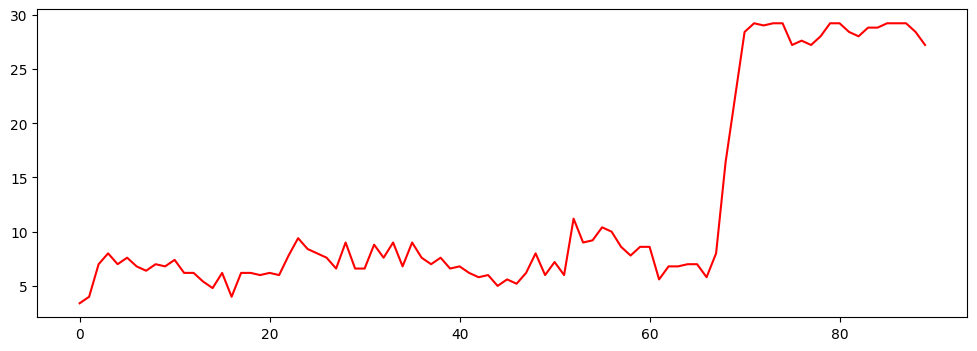

In [7]:
print('fit_time:',good_time)
plt.figure(figsize=(12, 4))
plt.plot(range(test_range),good_time,'r')
plt.show